In [21]:
import os
import nibabel as nib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import random

from scipy import ndimage

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage import transform
from skimage.transform import resize
import skimage.exposure as skie

import ot

import torch
from torch import manual_seed
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms

from torchmetrics.classification import Accuracy

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import Image 

torch.cuda.is_available()

torch.set_num_threads(3)

def compactness(blob_labels):
    import math
    compactness=[]
    region=regionprops(blob_labels)
    for rp in region:
        area=rp.area
        #perimeter=rp.perimeter
        perimeter=rp.perimeter_crofton
        c=(4*math.pi*area)/(perimeter**2)
        compactness.append(c)
    return compactness

def get_blobs(image,lesion_size):
    """
    gets the noise image after pre processing and returns blobs with the size equal to lesion size
    image is the noise image 
    lesion_size can be an int
    """
    
    labeled, nr_objects = ndimage.label(image)
    sizes = ndimage.sum_labels(image,labeled,range(nr_objects+1))    
    mask_size=sizes!=lesion_size
    small_blobs=labeled.copy()
    remove_pixel = mask_size[small_blobs]
    small_blobs[remove_pixel] = 0 
    
    return small_blobs


def list_lesions(image,lesion_size):
    round_lesion_c=0.8 #lesions with compactness above this value are considered round
    not_round_lesion_c=0.4 #lesions with compactness bellow this value are considered not round
    
    border=2
    blur=0.75
    
    less_size=lesion_size*0.05*blur #the lesion is smaller after the blur
    
    small_blobs=get_blobs(image,lesion_size)
    rb=regionprops(small_blobs)
    round_lesions=[]
    not_round_lesions=[]
    c_list=compactness(small_blobs)
    
    for blob in range(len(c_list)):
        
        if c_list[blob]>round_lesion_c:#round lesions

            blob_img=rb[blob].image.astype(float)
            #the image is padded because when it is smoothed it increases a bit
            pad_img=np.pad(array=blob_img, pad_width=border, mode='constant', constant_values=0)
            blur_image=ndimage.gaussian_filter(pad_img, blur)
            blur_image[blur_image<0.2]=0
            energy=round(np.sum(blur_image.astype(float)),2)
            if energy<=lesion_size-less_size+1 and energy>=lesion_size-less_size-1:
                round_lesions.append([blur_image,round(c_list[blob],3)])
        
        
        elif c_list[blob]<not_round_lesion_c:# not round lesions
            blob_img=rb[blob].image.astype(float)
            #the image is padded because when it is smoothed it increases a bit
            pad_img=np.pad(array=blob_img, pad_width=border, mode='constant', constant_values=0)
            blur_image=ndimage.gaussian_filter(pad_img, blur)
            blur_image[blur_image<0.15]=0
            energy=round(np.sum(blur_image.astype(float)),2)
            if energy<=lesion_size-less_size+1 and energy>=lesion_size-less_size-1:
                not_round_lesions.append([blur_image,round(c_list[blob],3)])
            
    return round_lesions, not_round_lesions

def create_lesions(lesion_number,lesion_size,factor=1):
    #factor is the value for which we multiply the sides of the lesion
    round_lesions=[]
    not_round_lesions=[]
    s=0
    size_noise=256
    blur_radius=2

    while len(not_round_lesions)<=lesion_number or len(round_lesions)<=lesion_number:
        #create noise
        np.random.seed(s)
        noise_img=np.random.rand(size_noise,size_noise)

        #smooth noise
        imgf=ndimage.gaussian_filter(noise_img, blur_radius)

        #create binary image
        thr=threshold_otsu(imgf)
        imgf_bin=imgf>thr
        
        #morphologic changes
        erosion_image=ndimage.binary_erosion(imgf_bin)
        open_er_img=ndimage.binary_opening(erosion_image)
        erosion_image2=ndimage.binary_erosion(open_er_img)

        #images
        

        #as a result from one noise image we create several images that can be used to create the lesions
        round_lesions_open, not_round_lesions_open=list_lesions(open_er_img,lesion_size)
        round_lesions_er, not_round_lesions_er=list_lesions(erosion_image2,lesion_size)
        
        round_lesions=round_lesions+round_lesions_open+round_lesions_er
        not_round_lesions=not_round_lesions+not_round_lesions_open+not_round_lesions_er
        
        
        #print('len lists:',len(round_lesions),len(not_round_lesions))
        '''        
        plt.figure(figsize=(15,7))
        plt.subplot(2,4,1)
        plt.imshow(noise_img)
        plt.title('noise')
        plt.subplot(2,4,2)
        plt.imshow(imgf)
        plt.title('blur')
        plt.subplot(2,4,3)
        plt.imshow(imgf_bin)
        plt.title('binary img')
        plt.subplot(2,4,4)
        plt.imshow(erosion_image)
        plt.title('erosion')
        plt.subplot(2,4,5)
        plt.imshow(open_er_img)
        plt.title('open')
        plt.subplot(2,4,6)
        plt.imshow(erosion_image2)
        plt.title('erosion2')
        plt.subplot(2,4,7)
        plt.imshow(dilated_image)
        plt.title('dilation')
        break
        '''
        
        s+=1
    print(f'round lesions: {len(round_lesions)}/{lesion_number} === not round lesions {len(not_round_lesions)}/{lesion_number}')
    print(f'number of seeds used: {s-1}')
    print(f'the lesions have size between {lesion_size-lesion_size*0.05*0.75-1} and {lesion_size-lesion_size*0.05*0.75+1}')
    
    lesions_r=round_lesions[:lesion_number]
    lesions_nr=not_round_lesions[:lesion_number]
    round_lesions=[[np.array(resize(round_lesions[i][0],(round_lesions[i][0].shape[0]*factor,round_lesions[i][0].shape[1]*factor))),round_lesions[i][1]] for i in range(len(lesions_r))]
    not_round_lesions=[[np.array(resize(not_round_lesions[i][0],(not_round_lesions[i][0].shape[0]*factor,not_round_lesions[i][0].shape[1]*factor))),not_round_lesions[i][1]] for i in range(len(lesions_nr))]
    
    return round_lesions, not_round_lesions

def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

def select_coordinates(slice_image, lesions,white_constant,seed):
    '''
    slice_image is the brain slice to use
    lesions is a list of the lesions (with len=number_of_lesions) to use
    colour_lesion is either 'black' or 'white'
    white_constant is the constant that is multiplied with the lesion mask to create lighter or darker lesions
    '''

    np.random.seed(seed)
    
    brain_mask=np.array(slice_image)>0
    brain_mask=brain_mask.astype(float)
    x,y = np.where(brain_mask == 1.)
    
    lesion_brain=slice_image.copy().astype(float)
    lesion_mask=brain_mask.copy() 
    lesion_added=0
    ground_truth=np.zeros(slice_image.shape)
    min_value=0.1 #min value for the lesion intensity 
    max_value=0.9 #max value for the lesion intensity
    brain_image=slice_image.copy()
    
    while lesion_added<len(lesions):
        i=np.random.choice(np.arange(len(x)))
        coordinate=[x[i],y[i]]
        lesion=lesions[lesion_added]
        lesion_rescale = rescale_values(lesion,max_value,min_value)
        lesion_rescale=rescale_values(lesion,white_constant,min_value)
        
        #creating the lesion mask and ground truth
        if (brain_mask[coordinate[0]: coordinate[0] + lesion.shape[0], coordinate[1]: coordinate[1] + lesion.shape[1]] ==1).all():
            #checks if the lesion that will be added is completly in a white space of the lesion mask 
            #(this means that the new lesion is not overlaping an existing one and is completly in the brain area)
            lesion_mask[coordinate[0]: coordinate[0] + lesion.shape[0], coordinate[1]: coordinate[1] + lesion.shape[1]] -= lesion_rescale
            lesion_added+=1
            ground_truth[coordinate[0]: coordinate[0] + lesion.shape[0], coordinate[1]: coordinate[1] + lesion.shape[1]]+=lesion
            brain_mask=lesion_mask

    
    brain_image=slice_image.copy()
    brain_mask=np.array(slice_image)>0
    #creating the white lesions
       
    brain_image[brain_image>0]=1-brain_image[brain_image>0]        
    brain_image[lesion_mask!=0]*=lesion_mask[lesion_mask!=0]
    brain_image[brain_mask]=1-brain_image[brain_mask]
    

    
    return lesion_mask,brain_image,ground_truth
    
def add_lesions(slice_image,round_lesions,not_round_lesions,min_lesion,max_lesion,white_constant,seed,max_brain):
    #for each slice we chose: random number of lesions, random lesions, random coordinates
    
    np.random.seed(seed)
    number_of_lesions=np.random.randint(min_lesion,max_lesion+1)
    lesion_type=np.random.randint(0,2)
    #lesion_type=0 - round
    #lesion_type=1 - not round
    
    #get lesions from type of lesions (and target)
    added=rescale_values(slice_image.copy(),max_brain,0)
    if lesion_type==0: #round
        target=0
        with open('round_lesions.pkl', 'rb') as f:
            lesion_list=pickle.load(f)
        np.random.shuffle(round_lesions)
        
    elif lesion_type==1: #not round
        target=1
        with open('not_round_lesions.pkl', 'rb') as f:
            lesion_list=pickle.load(f) 
        np.random.shuffle(lesion_list)
        
    lesions=[i[0] for i in lesion_list[:number_of_lesions]]
    #add the lesions
    
    lesion_mask,lesion_brain_white,ground_truth=select_coordinates(added, lesions,white_constant,seed)
    
    
    return lesion_mask,lesion_brain_white,ground_truth,target,number_of_lesions

def change_images(image):
    image=np.repeat(image[..., np.newaxis], 3, axis=2)
    image=resize(image, (224, 224))
    image=image.transpose(2,0,1)
    return image

def create_dataset(slices,round_lesions,not_round_lesions,min_lesion=3,max_lesion=5,white_constant=0.85,seed=0,max_brain=1):

    dataset_white=[]
    number_lesions=[]
    lesion_mask_list=[]
    ground_truths=[]
    for slice_idx in range(len(slices)):
        lesion_mask,lesion_brain_white,ground_truth,target,number_of_lesions=add_lesions(slices[slice_idx],
                                                                                         round_lesions,
                                                                                         not_round_lesions,
                                                                                         min_lesion=min_lesion,
                                                                                         max_lesion=max_lesion,
                                                                                         white_constant=white_constant,
                                                                                        seed=seed,
                                                                                        max_brain=max_brain)
        dataset_white.append([change_images(lesion_brain_white),target])
        number_lesions.append(number_of_lesions)
        lesion_mask_list.append(lesion_mask)
        ground_truths.append(ground_truth)
        seed+=1
        
        if slice_idx%1500==0:
            print(f'slice {slice_idx}/{len(slices)} = {round(100*slice_idx/len(slices),2)}%')
        
    return dataset_white,number_lesions,lesion_mask_list,ground_truths
        
    


In [22]:
torchvision.__version__

'0.12.0+cu102'

In [23]:
  
seed=0
np.random.seed(seed)
random.seed(seed)
plt.rc('image',cmap='gray')  

start = time.time()

number_of_lesions=50 #amount of lesions in each lesion list
size_of_lesions=70 #size of all the lesions
factor=2

round_lesions, not_round_lesions=create_lesions(number_of_lesions,size_of_lesions,factor=factor)

done = time.time()
elapsed = done - start
print(f'took {round(elapsed,2)}s')

t0=time.time()

with open('slices_training.pkl', 'rb') as f:
    training_slices,target_train_gender,target_train_age = pickle.load(f)
    
with open('slices_validation.pkl', 'rb') as f:
    validation_slices,target_valid_gender,target_valid_age = pickle.load(f)
    
with open('slices_holdout.pkl', 'rb') as f:
    holdout_slices,target_hold_gender,target_hold_age = pickle.load(f)
    
print(f'total time: {(time.time()-t0) // 60:.0f}m {(time.time()-t0) % 60:.0f}s')

round lesions: 51/50 === not round lesions 207/50
number of seeds used: 886
the lesions have size between 66.375 and 68.375
took 10.18s
total time: 0m 54s


In [4]:
k=2500
training_indexes=random.sample(range(0, len(training_slices)), k)
val_indexes=random.sample(range(0, len(validation_slices)), int(k/2))

trianing_slices_2500=[training_slices[i] for i in training_indexes]
validation_slices_1000=[validation_slices[i] for i in val_indexes]


In [ ]:
plt.imshow(test_hold_slices[0])

In [4]:
lesion_max_intensity=0.5

### Training dataset
start = time.time()
t0=time.time()
initial_seed=0
max_brain_intensity=0.7

print(' ====== training ====== ')
training_dataset,number_lesions_train,lesion_mask_list_train,ground_truths_train=create_dataset(trianing_slices_2500,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=lesion_max_intensity,
                                                                              seed=initial_seed,
                                                                              max_brain=max_brain_intensity)


done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target=[i[1] for i in training_dataset]
print(f'{len([i for i in target if i==1])} slices of target 1 out of {len(target)} slices: {round(100*len([i for i in target if i==1])/len(target),2)} %')
print(f' number of slices: {len(training_dataset)}')
print()



### Validation dataset
print(' ====== validation ====== ')
start = time.time()

validation_dataset,number_lesions_valid,lesion_mask_list_valid,ground_truths_valid=create_dataset(validation_slices_1000,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=white_constant,
                                                                              seed=initial_seed+30000,
                                                                              max_brain=max_brain)


done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target_w=[i[1] for i in validation_dataset]
print(f'{len([i for i in target_w if i==1])} slices of target 1 out of {len(target_w)} slices: {round(100*len([i for i in target_w if i==1])/len(target_w),2)} %')
print(f' number of slices: {len(validation_dataset)}')
print()

### Holdout dataset
start = time.time()
print(' ====== holdout ====== ')

holdout_dataset,number_lesions_hold,lesion_mask_list_hold,ground_truths_hold=create_dataset(holdout_slices,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=white_constant,
                                                                              seed=initial_seed+50000,
                                                                              max_brain=max_brain)

done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target_w=[i[1] for i in holdout_dataset]
print(f'{len([i for i in target_w if i==1])} slices of target 1 out of {len(target_w)} slices: {round(100*len([i for i in target_w if i==1])/len(target_w),2)} %')
print(f' number of slices: {len(holdout_dataset)}')

print(f'total time: {(time.time()-t0) // 60:.0f}m {(time.time()-t0) % 60:.0f}s')

 ====== training ====== 
slice 0/2500 = 0.0%
slice 1500/2500 = 60.0%

took 52.57s
1210 slices of target 1 out of 2500 slices: 48.4 %
 number of slices: 2500

 ====== validation ====== 
slice 0/1250 = 0.0%

took 23.81s
610 slices of target 1 out of 1250 slices: 48.8 %
 number of slices: 1250

 ====== holdout ====== 
slice 0/8319 = 0.0%
slice 1500/8319 = 18.03%
slice 3000/8319 = 36.06%
slice 4500/8319 = 54.09%
slice 6000/8319 = 72.12%
slice 7500/8319 = 90.16%

took 149.6s
4169 slices of target 1 out of 8319 slices: 50.11 %
 number of slices: 8319
total time: 3m 46s


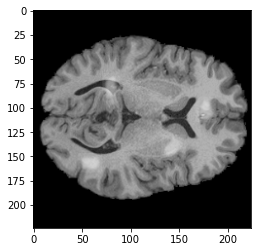

In [5]:
plt.imshow(holdout_dataset[432][0].transpose(1,2,0),vmax=1,vmin=0)

In [24]:

def load_VGG_model(path,device):
    model = models.vgg16(pretrained=True)
    model.classifier=model.classifier[:-1]
    last_layers=[nn.Linear(4096,2)]
    model.classifier = nn.Sequential(*list(model.classifier)+last_layers) 

    model.load_state_dict(torch.load(path,map_location=device))

    model.to(device)
    return model

def train_model(name,DEVICE,train_loader,val_loader, model, criterion, optimizer, scheduler, num_epochs, stop_value, acc_dif_save):
    model.to(DEVICE)

    training_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    validation_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)

    since = time.time()
    best_acc=0
    
    val_acc=[0.0,0.0,0.0]
    train_acc=[0.0,0.0,0.0]
    train_losses=[0.0,0.0,0.0]
    val_losses=[0.0,0.0,0.0]    
    
    out=0

    for epoch in range(num_epochs):
        t0=time.time()
        if out:
            break
        
        epoch_accuracies = list()
        epoch_validation_accuracies = list()
        epoch_loss = 0
        epoch_validation_loss = 0
        num_batches_train = 0
                
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        real_labels=[]
        pred_labels=[]
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            inputs = inputs.to(DEVICE,dtype=torch.float)
            labels = labels.type(torch.LongTensor)
            labels=labels.to(DEVICE)
            
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_batches_train += 1

            acc = training_accuracy(output, labels).item()
            epoch_accuracies.append(acc)
            
        train_acc.append(sum(epoch_accuracies)/len(epoch_accuracies))
        scheduler.step()
        
        num_batches_validation = 0
        
        real_labels=[]
        pred_labels=[]
        
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE,dtype=torch.float)
            labels = labels.type(torch.LongTensor)
            labels=labels.to(DEVICE)
            
            output = model(inputs)
            _, preds = torch.max(output, 1)
            loss = criterion(output, labels)
            
            epoch_validation_loss += loss.item()
            num_batches_validation += 1
#             acc = validation_accuracy(output, labels).item()
#             epoch_validation_accuracies.append(acc)
            
            preds=np.array(torch.Tensor.cpu(preds))
            labels=np.array(torch.Tensor.cpu(labels))

            real_labels=real_labels+list(labels)
            pred_labels=pred_labels+list(preds)
        
        
        compare_lists=np.array(real_labels)==np.array(pred_labels)
        correct_indexes=np.where(compare_lists==True)
        
        acc=round(len(correct_indexes[0])/len(compare_lists),4)
        val_acc.append(acc)
        
       # val_acc.append(sum(epoch_validation_accuracies)/len(epoch_validation_accuracies))

        epoch_loss /= num_batches_train
        epoch_validation_loss /= num_batches_validation

        train_losses.append(epoch_loss)
        val_losses.append(epoch_validation_loss)
        
        if epoch==0:
            PATH='/home/martao/MRI_dataset/2ndTry/new_models_finetune_with_test_slices/'+name+'.pt'
            torch.save(model.state_dict(), PATH)
            
        if val_acc[-1]>best_acc and abs(val_acc[-1]-train_acc[-1])<=acc_dif:
            PATH='/home/martao/MRI_dataset/2ndTry/new_models_finetune_with_test_slices/'+name+'.pt'
            best_acc = val_acc[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            model.load_state_dict(best_model_wts)
            torch.save(model.state_dict(), PATH)
            print('\t \t \t \t *** best model ***')  
        
#         if (val_acc[-1]-train_acc[-1]<-stop_value and val_acc[-2]-train_acc[-2]<-stop_value and val_acc[-3]-train_acc[-3]<-stop_value):# or (val_losses[-1]<val_losses[-2] and val_losses[-2]<val_losses[-3] and val_losses[-3]<val_losses[-4]): 
#             print('out')
#             out=True
            
        if abs(val_acc[-1]-val_acc[-2])<stop_value and abs(val_acc[-2]-val_acc[-3])<stop_value and abs(val_acc[-3]-val_acc[-4])<stop_value and val_acc[-1]<train_acc[-1] and val_acc[-2]<train_acc[-2] and val_acc[-3]<train_acc[-3]:# or (val_losses[-1]<val_losses[-2] and val_losses[-2]<val_losses[-3] and val_losses[-3]<val_losses[-4]): 
            print('out')
            out=True
            
                
#         if abs(val_acc[-1]-val_acc[-2])<=stop_value and abs(val_acc[-2]-val_acc[-3])<=stop_value and abs(val_acc[-3]-val_acc[-4])<=stop_value:# or (val_losses[-1]<val_losses[-2] and val_losses[-2]<val_losses[-3] and val_losses[-3]<val_losses[-4]): 
#             print('out')
#             out=True
            
        print(f'Training Loss: {train_losses[-1]:.4f} Acc: {train_acc[-1]:.4f}')
            
        print(f'Validation Loss: {val_losses[-1]:.4f} Acc: {val_acc[-1]:.4f}')
        
        time_elapsed = time.time() - t0
        print(f'took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
        
    model=None
    best_model_wts=None
    best_acc=None
    hold_loader=None
    val_loader=None
    train_loader=None
    import gc

    
    print()
    
    gc.collect()
    torch.cuda.empty_cache()
      
    return val_acc[2:],train_acc[2:],val_losses[2:],train_losses[2:]


def acc1(data_loader,model,DEVICE):
    accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    acc_tot=[]
    real_labels=[]
    pred_labels=[]
    
    for inputs, labels in data_loader:

        inputs = inputs.to(DEVICE,dtype=torch.float)
        labels = labels.type(torch.LongTensor)
        labels=labels.to(DEVICE)

        model.to(DEVICE)
        output = model(inputs)

        acc = accuracy(output, labels).item()
        acc_tot.append(acc)

        real_labels+=torch.Tensor.cpu(labels).tolist()
        pred_labels+=torch.Tensor.cpu(torch.max(output, 1)[1]).tolist()
        
    acc=sum(acc_tot)/len(acc_tot)
    
        
        
    inputs=None
    labels=None
    model=None
    
    import gc

    
    print()
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return acc,real_labels,pred_labels



In [25]:
!gpustat

cuda01                         Mon Mar 27 17:23:38 2023  470.161.03
[0] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |   278 / 11178 MB | martao(135M) martao(135M) gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |  6249 / 11178 MB | martao(6241M) gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |  7761 / 11178 MB | martao(7753M) gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 32'C,   0 % |  5915 / 11178 MB | martao(5907M) gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |  6949 / 11178 MB | martao(6941M) gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 30'C,   0 % |  1402 / 11178 MB | martao(697M) martao(697M) gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |  8908 / 11178 MB | martao(5163M) martao(3737M) gdm(4M)


In [26]:
import math
import random

def training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                 LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS=40, weight_decay = 0):

    
    DEVICE= torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    manual_seed(SEED)
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.default_rng(SEED)
    np.random.seed(SEED)
    
    print('creating dataloaders...')
    train_loader = DataLoader(training_dataset,batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset,batch_size=batch_size, shuffle=False)
    hold_loader = DataLoader(holdout_dataset,batch_size=batch_size, shuffle=False)
    
    
    #model
    if MRI:
        print('loading MRI model...')
        file_PATH='/home/martao/MRI_dataset/2ndTry/Models/finetuning_MRI_gender_train_79.pt'
        vgg16_pretrained = load_VGG_model(file_PATH,DEVICE)
        vgg16_pretrained.to(DEVICE)
        
        name='zz_new_finetuning_'+block+'_'+str(white_constant)+'_MRI_new_'+str(len(training_dataset))+'_'+str(LR)+'_'+str(SEED)

    else:
        print('loading imagenet model...')
        vgg16_pretrained = models.vgg16(pretrained=True)
        vgg16_pretrained.classifier=vgg16_pretrained.classifier[:-1]
        last_layers=[nn.Linear(4096,2)]
        vgg16_pretrained.classifier = nn.Sequential(*list(vgg16_pretrained.classifier)+last_layers) 
        vgg16_pretrained.to(DEVICE)
        
        name='zz_new_finetuning_'+block+'_'+str(white_constant)+'_img_new_'+str(len(training_dataset))+'_'+str(LR)+'_'+str(SEED)
        

    print('##############',name,'##############')
    
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer_conv = optim.SGD(vgg16_pretrained.parameters(), lr=LR, momentum=0.5,weight_decay=weight_decay)
    #here to change the 
    # Decay LR by a factor of 0.1 every 5 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    training_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    validation_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    
    for param in vgg16_pretrained.parameters():
        param.requires_grad = False
    
    if block=='1conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[25:]]
    elif block=='2conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[18:]]
    elif block=='3conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[11:]]
    elif block=='4conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[6:]]
    elif block=='all':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[:]]
        
    for layer in unfreeze_layers:
        for param in layer.parameters():
            param.requires_grad = True

    print('training...')
    val_acc,train_acc,val_losses,train_losses=train_model(name,DEVICE,train_loader,val_loader, vgg16_pretrained, criterion, optimizer_conv,
                         exp_lr_scheduler, EPOCHS, stop_value, acc_dif)
    

    to_save=[val_acc[1:],train_acc[1:],val_losses[1:],train_losses[1:]]

    with open('/home/martao/MRI_dataset/2ndTry/Models/VGG/new_losses_'+name+'.pkl', 'wb') as f:
         pickle.dump(to_save,f)    

    ax1 = plt.subplot()
    l1, = ax1.plot(val_acc[1:],'c')
    l2, = ax1.plot(train_acc[1:], color='r')

    ax2 = ax1.twinx()
    l3, = ax2.plot(train_losses[1:], '--r')
    l4, = ax2.plot(val_losses[1:], 'c--')

    plt.legend([l1, l2,l3,l4], ["val acc", "train acc","train loss","val loss"])

    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy', color='black')
    ax2.set_ylabel('losses', color='black')

    plt.show()


    DEVICE= torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
    PATH='/home/martao/MRI_dataset/2ndTry/new_models_finetune_with_test_slices/'+name+'.pt'
    model = load_VGG_model(PATH,DEVICE)
    model.to(DEVICE)

    print('getting accuracies...')
    train_acc,_,_=acc1(train_loader,model,DEVICE)
    val_acc,_,_=acc1(val_loader,model,DEVICE)
    hold_acc,real_labels,pred_labels=acc1(hold_loader,model,DEVICE)    

    print(f'Train accuracy: {train_acc}')
    print(f'Validation accuracy: {val_acc}')
    print(f'Holdout accuracy: {hold_acc}')

    parameters_to_save={'SEED':SEED,
                        'acc_dif':acc_dif,
                        'LR':LR,
                        'block':block,
                        'model_name':name,
                       'train_acc':train_acc,
                       'val_acc':val_acc,
                       'hold_acc':hold_acc
                       }

    '''
    print('getting ratios...')
    

   
    
    vgg16_pretrained.features[1]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[3]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[6]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[8]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[11]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[13]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[15]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[18]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[20]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[22]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[25]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[27]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[29]=nn.ReLU(inplace=False)
    vgg16_pretrained.classifier[1]=nn.ReLU(inplace=False)
    vgg16_pretrained.classifier[4]=nn.ReLU(inplace=False)
        
    print()
    print('obtaining ratios of pixels in ground truth...')
    ratios,EMDs=get_ratios_list(vgg16_pretrained,holdout_dataset,DEVICE,ratio=1,emd=0)

    print(hold_acc)
    to_save=[hold_acc,ratios,EMDs,real_labels,pred_labels]

    path='/home/martao/MRI_dataset/2ndTry/Models/Ratios/'

    with open(f'{path}{name}_ratios_.pkl', 'wb') as f:
        pickle.dump(to_save,f)
    
    '''
    
    vgg16_pretrained=None
    train_loader=None
    val_loader=None
    hold_loader=None
    train_acc=None
    val_acc=None
#     hold_acc=None
    real_labels=None
    pred_labels=None
    model=None
    import gc

    
    print()
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return hold_acc
    


In [27]:
vgg16_pretrained=None
train_loader=None
val_loader=None
hold_loader=None
train_acc=None
val_acc=None
hold_acc=None
real_labels=None
pred_labels=None
import gc


print()

gc.collect()
torch.cuda.empty_cache()


In [19]:
!gpustat

cuda01                         Mon Mar 27 13:52:35 2023  470.161.03
[0] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |   143 / 11178 MB | martao(135M) gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |     8 / 11178 MB | gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 34'C,   0 % |   705 / 11178 MB | martao(697M) gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 61'C,   0 % |  5171 / 11178 MB | martao(5163M) gdm(4M)


In [11]:

# EPOCHS=30
# SEED=32323548


# batch_size=32
# acc_dif=0.035
# stop_value=0.02
# Lrs=[(i-1)/10000 for i in range(1,1000,20) if i>0]

# # for LR in Lrs:

# for i in range(1000,1,-20):
#     LR=(i)/100000
#     if LR<0.001:
#         print(LR)
#         MRI=0
#         print('\t\t\t\t\t','********************',LR,'********************') 
#         block='1conv'

#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         block='2conv'

#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         block='3conv'
#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         block='4conv'

#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)


#         block='all'
#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         gc.collect()
#         torch.cuda.empty_cache()

#         MRI=1
#         block='1conv'

#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         block='2conv'

#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         block='3conv'
#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         block='4conv'

#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)


#         block='all'
#         training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                          LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#         gc.collect()
#         torch.cuda.empty_cache()



In [12]:
!gpustat

cuda01                         Fri Mar 24 22:39:57 2023  470.161.03
[0] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |   143 / 11178 MB | martao(135M) gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 84'C, 100 % |  8259 / 11178 MB | martao(8251M) gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 29'C,   0 % |  3703 / 11178 MB | martao(3695M) gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 35'C,   0 % |  1223 / 11178 MB | martao(1215M) gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 41'C,   0 % |     8 / 11178 MB | gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |     8 / 11178 MB | gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 84'C,  87 % |  5989 / 11178 MB | martao(5981M) gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 29'C,   0 % |  1223 / 11178 MB | martao(1215M) gdm(4M)


In [1]:
# SEEDS=[156846,13846469,2154687,2548,1359,546797,978956,47979631]

# EPOCHS=50
# batch_size=32
# acc_dif=0.035
# stop_value=0.01

# for SEED in SEEDS:
#     print('#########',SEED,'############')

#     MRI=0
#     LR=0.02
#     block='1conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
   
#     LR=0.008
#     block='2conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
    
#     LR=0.008
#     block='3conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#     LR=0.008
#     block='4conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#     LR=0.004
#     block='all'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
    
#     MRI=1
#     LR=0.038
#     block='1conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
   
#     LR=0.038
#     block='2conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
    
#     LR=0.016
#     block='3conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#     LR=0.008
#     block='4conv'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

#     MRI=1
#     LR=0.006
#     block='all'
#     training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                      LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
    

#     gc.collect()
#     torch.cuda.empty_cache()
    

creating dataloaders...
loading MRI model...
############## new_finetuning_3conv_0.5_MRI_2500_0.016_123456 ##############
training...
Epoch 0/29
----------
Training Loss: 0.7178 Acc: 0.5016
Validation Loss: 0.6889 Acc: 0.5512
took 0m 28s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6921 Acc: 0.5316
Validation Loss: 0.6862 Acc: 0.5416
took 0m 28s

Epoch 2/29
----------
Training Loss: 0.6883 Acc: 0.5463
Validation Loss: 0.6928 Acc: 0.5200
took 0m 17s

Epoch 3/29
----------
Training Loss: 0.6818 Acc: 0.5570
Validation Loss: 0.7239 Acc: 0.5120
took 0m 19s

Epoch 4/29
----------
Training Loss: 0.6674 Acc: 0.5934
Validation Loss: 0.7346 Acc: 0.5120
took 0m 17s

Epoch 5/29
----------
Training Loss: 0.6573 Acc: 0.6088
Validation Loss: 0.6766 Acc: 0.5368
took 0m 19s

Epoch 6/29
----------
Training Loss: 0.6270 Acc: 0.6630
Validation Loss: 0.6902 Acc: 0.5056
took 0m 18s

Epoch 7/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.4918 Acc: 0.8157
Validation Loss: 0.47

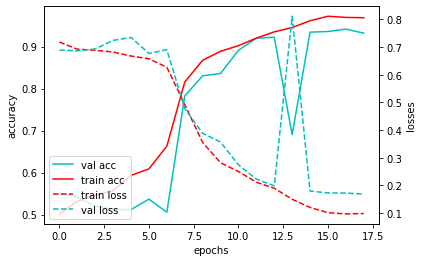

getting accuracies...



Train accuracy: 0.9746835443037974
Validation accuracy: 0.94140625
Holdout accuracy: 0.939167183637619

creating dataloaders...
loading MRI model...
############## new_finetuning_3conv_0.5_MRI_2500_0.016_77777 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7173 Acc: 0.4949
Validation Loss: 0.6949 Acc: 0.5080
took 0m 43s

Epoch 1/29
----------
Training Loss: 0.6909 Acc: 0.5316
Validation Loss: 0.6996 Acc: 0.4912
took 0m 18s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6909 Acc: 0.5348
Validation Loss: 0.6914 Acc: 0.5128
took 0m 29s

Epoch 3/29
----------
Training Loss: 0.6859 Acc: 0.5534
Validation Loss: 0.6777 Acc: 0.6032
took 0m 20s

Epoch 4/29
----------
Training Loss: 0.6718 Acc: 0.5862
Validation Loss: 0.7127 Acc: 0.5008
took 0m 18s

Epoch 5/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6676 Acc: 0.5906
Validation Loss: 0.6686 Acc: 0.6200
took 0m 28s

Epoch 6/29
----------
Train

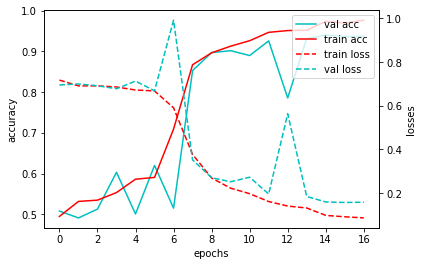

getting accuracies...



Train accuracy: 0.9719145569620253
Validation accuracy: 0.94296875
Holdout accuracy: 0.9338787220991575

creating dataloaders...
loading MRI model...
############## new_finetuning_4conv_0.5_MRI_2500_0.008_18464876 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7149 Acc: 0.5087
Validation Loss: 0.6895 Acc: 0.5328
took 0m 41s

Epoch 1/29
----------
Training Loss: 0.6899 Acc: 0.5471
Validation Loss: 0.6872 Acc: 0.5192
took 0m 20s

Epoch 2/29
----------
Training Loss: 0.6795 Acc: 0.5732
Validation Loss: 0.6935 Acc: 0.5232
took 0m 21s

Epoch 3/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6690 Acc: 0.5843
Validation Loss: 0.6613 Acc: 0.6104
took 0m 31s

Epoch 4/29
----------
Training Loss: 0.6454 Acc: 0.6305
Validation Loss: 0.6535 Acc: 0.6040
took 0m 23s

Epoch 5/29
----------
Training Loss: 0.5937 Acc: 0.7002
Validation Loss: 0.6935 Acc: 0.5560
took 0m 20s

Epoch 6/29
----------
	 	 	 	 *** best model ***
T

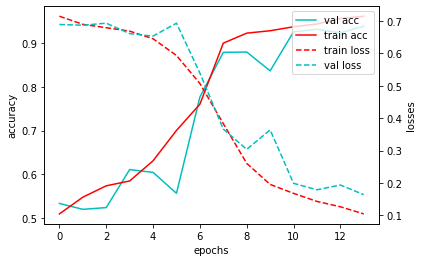

getting accuracies...



Train accuracy: 0.9719145569620253
Validation accuracy: 0.93203125
Holdout accuracy: 0.9355614144068498

creating dataloaders...
loading MRI model...
############## new_finetuning_4conv_0.5_MRI_2500_0.008_6497 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7168 Acc: 0.5131
Validation Loss: 0.6976 Acc: 0.5184
took 0m 43s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6886 Acc: 0.5376
Validation Loss: 0.6812 Acc: 0.5576
took 0m 31s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6773 Acc: 0.5744
Validation Loss: 0.6788 Acc: 0.5728
took 0m 32s

Epoch 3/29
----------
Training Loss: 0.6713 Acc: 0.5732
Validation Loss: 0.6638 Acc: 0.5728
took 0m 20s

Epoch 4/29
----------
Training Loss: 0.6502 Acc: 0.6143
Validation Loss: 0.7101 Acc: 0.5488
took 0m 20s

Epoch 5/29
----------
Training Loss: 0.6066 Acc: 0.6772
Validation Loss: 0.6377 Acc: 0.5808
took 0m 20s

Epoch 6/29
----------
Train

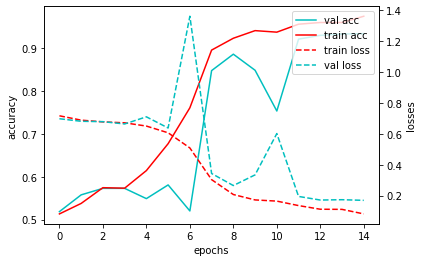

getting accuracies...



Train accuracy: 0.9754746835443038
Validation accuracy: 0.94140625
Holdout accuracy: 0.9356777294323995

creating dataloaders...
loading MRI model...
############## new_finetuning_4conv_0.5_MRI_2500_0.008_12222234 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7114 Acc: 0.5107
Validation Loss: 0.6894 Acc: 0.5432
took 0m 42s

Epoch 1/29
----------
Training Loss: 0.6901 Acc: 0.5309
Validation Loss: 0.6863 Acc: 0.5344
took 0m 19s

Epoch 2/29
----------
Training Loss: 0.6811 Acc: 0.5716
Validation Loss: 0.6869 Acc: 0.5360
took 0m 20s

Epoch 3/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6630 Acc: 0.5961
Validation Loss: 0.6625 Acc: 0.5936
took 0m 30s

Epoch 4/29
----------
Training Loss: 0.6442 Acc: 0.6234
Validation Loss: 0.6981 Acc: 0.5552
took 0m 20s

Epoch 5/29
----------
Training Loss: 0.5803 Acc: 0.6871
Validation Loss: 0.6086 Acc: 0.6488
took 0m 20s

Epoch 6/29
----------
Training Loss: 0.5324 Acc: 0

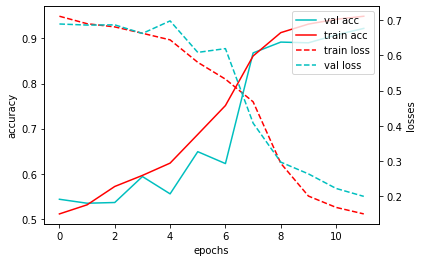

getting accuracies...



Train accuracy: 0.9588607594936709
Validation accuracy: 0.921875
Holdout accuracy: 0.9248642990222344

creating dataloaders...
loading MRI model...
############## new_finetuning_4conv_0.5_MRI_2500_0.008_1111111 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7138 Acc: 0.5265
Validation Loss: 0.6855 Acc: 0.5424
took 0m 38s

Epoch 1/29
----------
Training Loss: 0.6867 Acc: 0.5411
Validation Loss: 0.6842 Acc: 0.5368
took 0m 22s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6833 Acc: 0.5546
Validation Loss: 0.6809 Acc: 0.5496
took 0m 28s

Epoch 3/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6684 Acc: 0.5961
Validation Loss: 0.6564 Acc: 0.6056
took 0m 28s

Epoch 4/29
----------
Training Loss: 0.6380 Acc: 0.6460
Validation Loss: 0.6132 Acc: 0.6856
took 0m 20s

Epoch 5/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.5902 Acc: 0.6966
Validation Loss: 0.5546 Acc: 0.6960
took 0m 29s


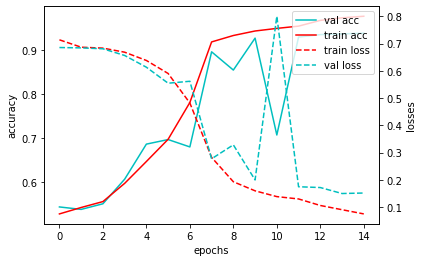

getting accuracies...



Train accuracy: 0.9703322784810127
Validation accuracy: 0.9328125
Holdout accuracy: 0.9382017678939379

creating dataloaders...
loading MRI model...
############## new_finetuning_4conv_0.5_MRI_2500_0.008_134568532 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7192 Acc: 0.5134
Validation Loss: 0.6946 Acc: 0.5104
took 0m 38s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6899 Acc: 0.5400
Validation Loss: 0.6882 Acc: 0.5360
took 0m 29s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6816 Acc: 0.5613
Validation Loss: 0.6809 Acc: 0.5544
took 0m 29s

Epoch 3/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6736 Acc: 0.5799
Validation Loss: 0.6689 Acc: 0.6080
took 0m 28s

Epoch 4/29
----------
Training Loss: 0.6486 Acc: 0.6278
Validation Loss: 0.7275 Acc: 0.5152
took 0m 20s

Epoch 5/29
----------
Training Loss: 0.6120 Acc: 0.6792
Validation Loss: 0.6881 Acc: 0.5536
took 0m 2

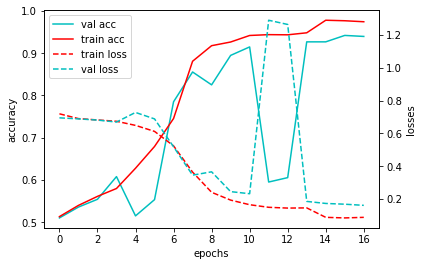

getting accuracies...



Train accuracy: 0.9738924050632911
Validation accuracy: 0.93828125
Holdout accuracy: 0.9363988832785533

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_2500_0.01_58461 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7107 Acc: 0.5071
Validation Loss: 0.7020 Acc: 0.5128
took 0m 43s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6898 Acc: 0.5328
Validation Loss: 0.7070 Acc: 0.5160
took 0m 36s

Epoch 2/29
----------
Training Loss: 0.6791 Acc: 0.5700
Validation Loss: 0.7200 Acc: 0.5176
took 0m 26s

Epoch 3/29
----------
out
Training Loss: 0.6678 Acc: 0.5949
Validation Loss: 0.6921 Acc: 0.5264
took 0m 25s

Training complete in 2m 10s
Best val Acc: 0.516000



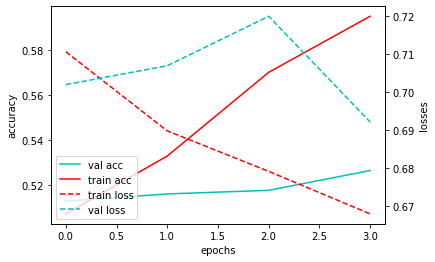

getting accuracies...



Train accuracy: 0.5162183544303798
Validation accuracy: 0.5234375
Holdout accuracy: 0.5046215880375642

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_2500_0.01_18464 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7108 Acc: 0.5079
Validation Loss: 0.6903 Acc: 0.5272
took 0m 44s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6887 Acc: 0.5297
Validation Loss: 0.6876 Acc: 0.5376
took 0m 34s

Epoch 2/29
----------
Training Loss: 0.6869 Acc: 0.5534
Validation Loss: 0.6837 Acc: 0.5216
took 0m 25s

Epoch 3/29
----------
Training Loss: 0.6693 Acc: 0.5934
Validation Loss: 0.7668 Acc: 0.5120
took 0m 25s

Epoch 4/29
----------
Training Loss: 0.6858 Acc: 0.5336
Validation Loss: 0.6545 Acc: 0.6264
took 0m 25s

Epoch 5/29
----------
Training Loss: 0.6170 Acc: 0.6578
Validation Loss: 0.6924 Acc: 0.5432
took 0m 25s

Epoch 6/29
----------
Training Loss: 0.6613 Acc: 0.5779
V

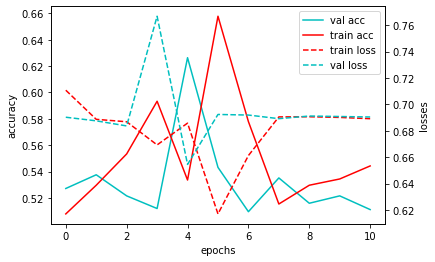

getting accuracies...



Train accuracy: 0.538370253164557
Validation accuracy: 0.53125
Holdout accuracy: 0.5301023572683334

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_2500_0.01_23548 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7139 Acc: 0.5119
Validation Loss: 0.6891 Acc: 0.5128
took 0m 44s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6913 Acc: 0.5218
Validation Loss: 0.6866 Acc: 0.5336
took 0m 34s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6834 Acc: 0.5570
Validation Loss: 0.6786 Acc: 0.5704
took 0m 34s

Epoch 3/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6709 Acc: 0.5957
Validation Loss: 0.6683 Acc: 0.5920
took 0m 35s

Epoch 4/29
----------
Training Loss: 0.6550 Acc: 0.6179
Validation Loss: 0.7152 Acc: 0.5120
took 0m 26s

Epoch 5/29
----------
Training Loss: 0.6953 Acc: 0.5079
Validation Loss: 0.6867 Acc: 0.5480
took 0m 26s

Epoch 

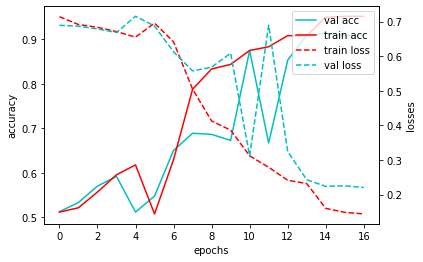

getting accuracies...



Train accuracy: 0.9418512658227848
Validation accuracy: 0.90625
Holdout accuracy: 0.9208979528683883

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_2500_0.01_94515 ##############
training...
Epoch 0/29
----------
Training Loss: 0.7139 Acc: 0.5016
Validation Loss: 0.6864 Acc: 0.5472
took 0m 36s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6898 Acc: 0.5419
Validation Loss: 0.6915 Acc: 0.5256
took 0m 35s

Epoch 2/29
----------
Training Loss: 0.6819 Acc: 0.5696
Validation Loss: 0.6947 Acc: 0.5248
took 0m 28s

Epoch 3/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6651 Acc: 0.5910
Validation Loss: 0.6580 Acc: 0.5928
took 0m 35s

Epoch 4/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6507 Acc: 0.6270
Validation Loss: 0.6216 Acc: 0.6608
took 0m 34s

Epoch 5/29
----------
Training Loss: 0.6357 Acc: 0.6254
Validation Loss: 0.6955 Acc: 0.4896
took 0m 26s

Epoch 6/29
----------
Training L

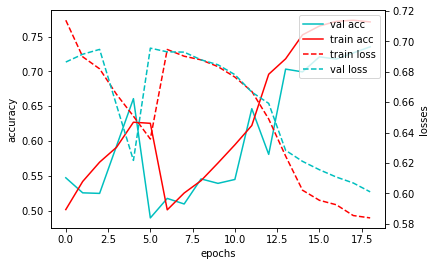

getting accuracies...



Train accuracy: 0.7314082278481012
Validation accuracy: 0.7046875
Holdout accuracy: 0.7211344602016302

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_2500_0.01_124568 ##############
training...
Epoch 0/29
----------
Training Loss: 0.7119 Acc: 0.4996
Validation Loss: 0.6875 Acc: 0.5424
took 0m 36s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6872 Acc: 0.5506
Validation Loss: 0.6883 Acc: 0.5440
took 0m 34s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6802 Acc: 0.5665
Validation Loss: 0.6710 Acc: 0.5920
took 0m 34s

Epoch 3/29
----------
Training Loss: 0.6670 Acc: 0.6025
Validation Loss: 0.6828 Acc: 0.5488
took 0m 25s

Epoch 4/29
----------
Training Loss: 0.6519 Acc: 0.6159
Validation Loss: 0.6943 Acc: 0.4784
took 0m 25s

Epoch 5/29
----------
Training Loss: 0.6963 Acc: 0.4960
Validation Loss: 0.6966 Acc: 0.5120
took 0m 25s

Epoch 6/29
----------
Training Loss: 0.6940 Acc: 0.5127


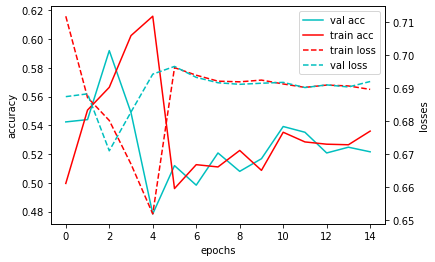

getting accuracies...



Train accuracy: 0.6000791139240507
Validation accuracy: 0.60078125
Holdout accuracy: 0.5637562034221796



In [10]:

EPOCHS=30
SEED=32323548


batch_size=32
acc_dif=0.035
stop_value=0.01
Lrs=[(i-1)/10000 for i in range(1,1000,20) if i>0]



MRI=0

# LR=0.02
# block='1conv'

# SEED=55168461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=98794515
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=23548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=646976
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

LR=0.008
block='2conv'

# SEED=116560000
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=55168461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464876
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=32323548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=23548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

# LR=0.008
# block='3conv'

# SEED=116560000
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=55168461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464876
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=98794515
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

# LR=0.008
# block='4conv'

# SEED=116560000
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464876
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=32323548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=98794515
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=58461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

# LR=0.004
# block='all'

# SEED=116560000
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=55168461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=32323548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=58461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=23548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

# gc.collect()
# torch.cuda.empty_cache()

MRI=1


# LR=0.038
# block='1conv'

# SEED=32323548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=98794515
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=23548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=12222234
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

# LR=0.038
# block='2conv'

# SEED=32323548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=98794515
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=134568532
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=1368
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

LR=0.016
block='3conv'

# SEED=55168461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=58461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=752684248
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=123456
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=77777
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

# LR=0.008
# block='4conv'

# SEED=18464876
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=6497
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=12222234
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=1111111
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=134568532
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

MRI=1
LR=0.01
block='all'

# SEED=58461
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=18464
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=23548
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=94515
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)
# SEED=124568
# training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
#                  LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS)

gc.collect()
torch.cuda.empty_cache()


In [15]:
!gpustat


cuda01                         Mon Mar 27 13:52:01 2023  470.161.03
[0] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |   143 / 11178 MB | martao(135M) gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |     8 / 11178 MB | gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |     8 / 11178 MB | gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 34'C,   0 % |   705 / 11178 MB | martao(697M) gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 71'C,   0 % | 10963 / 11178 MB | martao(10955M) gdm(4M)


In [13]:

block='4conv'
DEVICE='cuda:0'
vgg16_pretrained = models.vgg16(pretrained=True)
vgg16_pretrained.classifier=vgg16_pretrained.classifier[:-1]
last_layers=[nn.Linear(4096,2)]
vgg16_pretrained.classifier = nn.Sequential(*list(vgg16_pretrained.classifier)+last_layers) 
vgg16_pretrained.to(DEVICE)


for param in vgg16_pretrained.parameters():
    param.requires_grad = False

if block=='1conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[25:]]
elif block=='2conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[18:]]
elif block=='3conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[11:]]
elif block=='4conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[6:]]
elif block=='all':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[:]]

for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

summary(vgg16_pretrained,(3,240,240))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           1,792
              ReLU-2         [-1, 64, 240, 240]               0
            Conv2d-3         [-1, 64, 240, 240]          36,928
              ReLU-4         [-1, 64, 240, 240]               0
         MaxPool2d-5         [-1, 64, 120, 120]               0
            Conv2d-6        [-1, 128, 120, 120]          73,856
              ReLU-7        [-1, 128, 120, 120]               0
            Conv2d-8        [-1, 128, 120, 120]         147,584
              ReLU-9        [-1, 128, 120, 120]               0
        MaxPool2d-10          [-1, 128, 60, 60]               0
           Conv2d-11          [-1, 256, 60, 60]         295,168
             ReLU-12          [-1, 256, 60, 60]               0
           Conv2d-13          [-1, 256, 60, 60]         590,080
             ReLU-14          [-1, 256,

In [5]:
help (summary)

Help on function summary in module torchsummary.torchsummary:

summary(model, input_size, batch_size=-1, device='cuda')



### fine-tuning with HCP hold out slices

In [28]:
k=2500
random.seed(0)
val_indexes=random.sample(range(0, len(holdout_slices)), k) 
validation_slices=[holdout_slices[i] for i in val_indexes] # validation dataset with 2500 images

indexes_allowed = [i for i in range(0, len(holdout_slices)) if i not in val_indexes]
test_finetune_indexes=random.sample(indexes_allowed, k)
test_fine_tuning_slices = [holdout_slices[i] for i in test_finetune_indexes] # training dataset with 2500 images (from holdout slices)

indexes_allowed = [i for i in range(0, len(holdout_slices)) if (i not in test_finetune_indexes and i not in val_indexes)]
test_test_indexes = random.sample(indexes_allowed,k)
test_hold_slices = [holdout_slices[i] for i in test_test_indexes] # hold out dataset with 2500 images (from different holdout slices)

print(len(validation_slices),len(test_fine_tuning_slices),len(test_hold_slices))

2500 2500 2500


In [29]:
lesion_max_intensity=0.5

### Training dataset
start = time.time()
t0=time.time()
initial_seed=0
max_brain_intensity=0.7

print(' ====== training ====== ')
training_dataset,number_lesions_train,lesion_mask_list_train,ground_truths_train=create_dataset(test_fine_tuning_slices,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=lesion_max_intensity,
                                                                              seed=initial_seed,
                                                                              max_brain=max_brain_intensity)


done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target=[i[1] for i in training_dataset]
print(f'{len([i for i in target if i==1])} slices of target 1 out of {len(target)} slices: {round(100*len([i for i in target if i==1])/len(target),2)} %')
print(f' number of slices: {len(training_dataset)}')
print()



### Validation dataset
print(' ====== validation ====== ')
start = time.time()

validation_dataset,number_lesions_valid,lesion_mask_list_valid,ground_truths_valid=create_dataset(validation_slices,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=lesion_max_intensity,
                                                                              seed=initial_seed+30000,
                                                                              max_brain=max_brain_intensity)


done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target_w=[i[1] for i in validation_dataset]
print(f'{len([i for i in target_w if i==1])} slices of target 1 out of {len(target_w)} slices: {round(100*len([i for i in target_w if i==1])/len(target_w),2)} %')
print(f' number of slices: {len(validation_dataset)}')
print()

### Holdout dataset
start = time.time()
print(' ====== holdout ====== ')

holdout_dataset,number_lesions_hold,lesion_mask_list_hold,ground_truths_hold=create_dataset(test_hold_slices,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=lesion_max_intensity,
                                                                              seed=initial_seed+50000,
                                                                              max_brain=max_brain_intensity)

done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target_w=[i[1] for i in holdout_dataset]
print(f'{len([i for i in target_w if i==1])} slices of target 1 out of {len(target_w)} slices: {round(100*len([i for i in target_w if i==1])/len(target_w),2)} %')
print(f' number of slices: {len(holdout_dataset)}')

print(f'total time: {(time.time()-t0) // 60:.0f}m {(time.time()-t0) % 60:.0f}s')

 ====== training ====== 
slice 0/2500 = 0.0%
slice 1500/2500 = 60.0%

took 53.89s
1210 slices of target 1 out of 2500 slices: 48.4 %
 number of slices: 2500

 ====== validation ====== 
slice 0/2500 = 0.0%
slice 1500/2500 = 60.0%

took 52.76s
1217 slices of target 1 out of 2500 slices: 48.68 %
 number of slices: 2500

 ====== holdout ====== 
slice 0/2500 = 0.0%
slice 1500/2500 = 60.0%

took 52.88s
1265 slices of target 1 out of 2500 slices: 50.6 %
 number of slices: 2500
total time: 2m 40s


In [18]:
SEED = 55168461
LR = 0.04
MRI = 0
block='4conv'
batch_size=32
acc_dif=0.05
stop_value=0.005
EPOCHS = 40

training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

creating dataloaders...
loading imagenet model...
############## new_finetuning_2conv_0.5_img_new_2500_0.04_55168461 ##############
training...
Epoch 0/39
----------


KeyboardInterrupt: 

creating dataloaders...
loading imagenet model...
############## new_finetuning_all_0.5_img_new_2500_0.005_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7140 Acc: 0.5312
Validation Loss: 0.6803 Acc: 0.5704
took 0m 48s

Epoch 1/39
----------
Training Loss: 0.6405 Acc: 0.6286
Validation Loss: 1.1404 Acc: 0.5132
took 0m 31s

Epoch 2/39
----------
Training Loss: 0.6938 Acc: 0.5380
Validation Loss: 0.6565 Acc: 0.6480
took 0m 32s

Epoch 3/39
----------
Training Loss: 0.5606 Acc: 0.7188
Validation Loss: 0.4656 Acc: 0.7728
took 0m 32s

Epoch 4/39
----------
Training Loss: 0.3319 Acc: 0.8616
Validation Loss: 0.0692 Acc: 0.9764
took 0m 31s

Epoch 5/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.0736 Acc: 0.9703
Validation Loss: 0.0416 Acc: 0.9848
took 0m 40s

Epoch 6/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.0295 Acc: 0.9905
Validation Loss: 0.0190 Acc: 0.9936
took 0m 39s

Epoch 7/39
----------
	 	 	 	 *** best mo

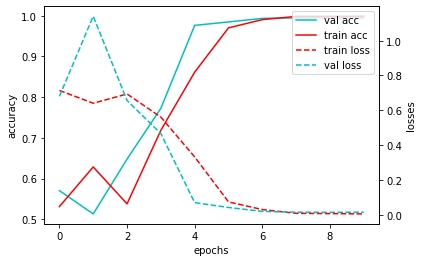

getting accuracies...



Train accuracy: 0.9992088607594937
Validation accuracy: 0.9948575949367089
Holdout accuracy: 0.9940664556962026



In [20]:
SEED = 55168461
LR = 0.005
MRI = 0
block='4conv'
batch_size=32
acc_dif=0.05
stop_value=0.005
EPOCHS = 40

training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.005_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7148 Acc: 0.5083
Validation Loss: 0.6891 Acc: 0.5336
took 0m 48s

Epoch 1/39
----------
Training Loss: 0.6826 Acc: 0.5558
Validation Loss: 0.7150 Acc: 0.5204
took 0m 30s

Epoch 2/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6764 Acc: 0.5570
Validation Loss: 0.6880 Acc: 0.5504
took 0m 38s

Epoch 3/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6695 Acc: 0.5827
Validation Loss: 0.6795 Acc: 0.5664
took 0m 38s

Epoch 4/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6448 Acc: 0.6286
Validation Loss: 0.6681 Acc: 0.5924
took 0m 38s

Epoch 5/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6191 Acc: 0.6559
Validation Loss: 0.6419 Acc: 0.6128
took 0m 37s

Epoch 6/39
----------
Training Loss: 0.6135 Acc: 0.6752
Validation Loss: 0.6547 Acc: 0.6112
took 

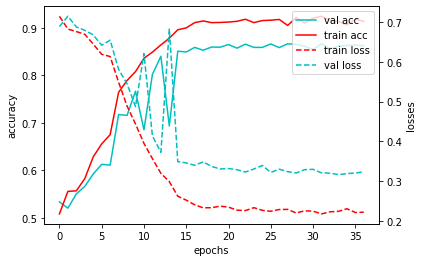

getting accuracies...



Train accuracy: 0.9161392405063291
Validation accuracy: 0.8571993670886076
Holdout accuracy: 0.8615506329113924

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.01_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7139 Acc: 0.5059
Validation Loss: 0.6899 Acc: 0.5388
took 0m 49s

Epoch 1/39
----------
Training Loss: 0.6873 Acc: 0.5459
Validation Loss: 0.7328 Acc: 0.5128
took 0m 32s

Epoch 2/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6836 Acc: 0.5570
Validation Loss: 0.6884 Acc: 0.5408
took 0m 38s

Epoch 3/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6764 Acc: 0.5728
Validation Loss: 0.6851 Acc: 0.5556
took 0m 38s

Epoch 4/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6541 Acc: 0.6187
Validation Loss: 0.6671 Acc: 0.5916
took 0m 39s

Epoch 5/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6243 Acc: 0.6578
Validatio

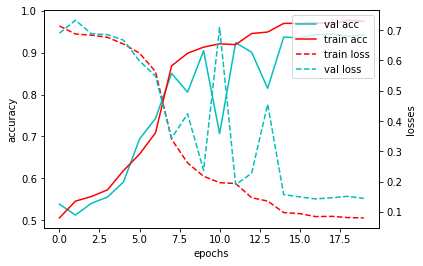

getting accuracies...



Train accuracy: 0.9691455696202531
Validation accuracy: 0.9382911392405063
Holdout accuracy: 0.9382911392405063

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.02_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7118 Acc: 0.4854
Validation Loss: 0.6926 Acc: 0.5192
took 0m 47s

Epoch 1/39
----------
Training Loss: 0.6939 Acc: 0.5047
Validation Loss: 0.7064 Acc: 0.5132
took 0m 28s

Epoch 2/39
----------
Training Loss: 0.6935 Acc: 0.5071
Validation Loss: 0.6942 Acc: 0.4996
took 0m 28s

Epoch 3/39
----------
Training Loss: 0.6953 Acc: 0.4925
Validation Loss: 0.6924 Acc: 0.5108
took 0m 29s

Epoch 4/39
----------
Training Loss: 0.6932 Acc: 0.5040
Validation Loss: 0.6933 Acc: 0.4972
took 0m 31s

Epoch 5/39
----------
Training Loss: 0.6938 Acc: 0.5020
Validation Loss: 0.6948 Acc: 0.5132
took 0m 28s

Epoch 6/39
----------
Training Loss: 0.6923 Acc: 0.5249
Validation L

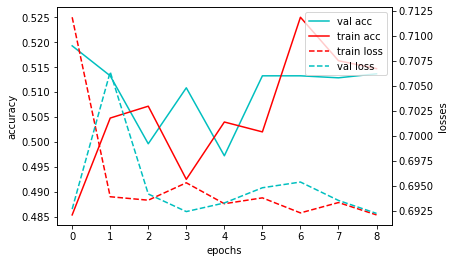

getting accuracies...



Train accuracy: 0.5399525316455697
Validation accuracy: 0.5189873417721519
Holdout accuracy: 0.49485759493670883

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.03_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7104 Acc: 0.4984
Validation Loss: 0.6928 Acc: 0.5172
took 0m 48s

Epoch 1/39
----------
Training Loss: 0.6939 Acc: 0.5059
Validation Loss: 0.7052 Acc: 0.5132
took 0m 29s

Epoch 2/39
----------
Training Loss: 0.6936 Acc: 0.5202
Validation Loss: 0.6939 Acc: 0.4936
took 0m 30s

Epoch 3/39
----------
Training Loss: 0.6949 Acc: 0.4945
Validation Loss: 0.6928 Acc: 0.5112
took 0m 30s

Epoch 4/39
----------
Training Loss: 0.6935 Acc: 0.5032
Validation Loss: 0.6932 Acc: 0.5000
took 0m 31s

Epoch 5/39
----------
Training Loss: 0.6941 Acc: 0.4980
Validation Loss: 0.6946 Acc: 0.5132
took 0m 32s

Epoch 6/39
----------
Training Loss: 0.6929 Acc: 0.5182
Validation 

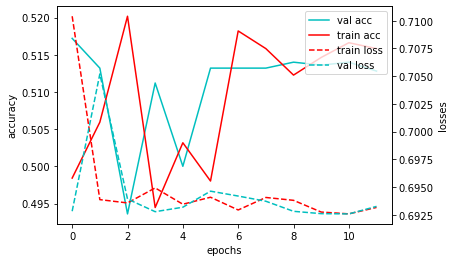

getting accuracies...



Train accuracy: 0.5098892405063291
Validation accuracy: 0.5170094936708861
Holdout accuracy: 0.495253164556962

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.05_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7169 Acc: 0.4893
Validation Loss: 0.6928 Acc: 0.5128
took 0m 46s

Epoch 1/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6928 Acc: 0.4992
Validation Loss: 0.6989 Acc: 0.5132
took 0m 36s

Epoch 2/39
----------
Training Loss: 0.6935 Acc: 0.5067
Validation Loss: 0.6934 Acc: 0.4904
took 0m 28s

Epoch 3/39
----------
Training Loss: 0.6943 Acc: 0.4941
Validation Loss: 0.6928 Acc: 0.5132
took 0m 28s

Epoch 4/39
----------
Training Loss: 0.6932 Acc: 0.4988
Validation Loss: 0.6931 Acc: 0.4964
took 0m 28s

Epoch 5/39
----------
Training Loss: 0.6939 Acc: 0.5016
Validation Loss: 0.6945 Acc: 0.5132
took 0m 30s

Epoch 6/39
----------
Training Loss: 0.693

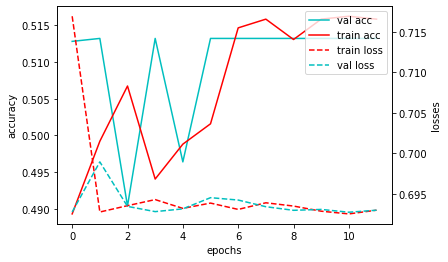

getting accuracies...



Train accuracy: 0.5130537974683544
Validation accuracy: 0.5130537974683544
Holdout accuracy: 0.4912974683544304



In [13]:
SEED = 55168461
LR = 0.005
MRI = 1
block='all'
batch_size=32
acc_dif=0.05
stop_value=0.005
EPOCHS = 40

LRs=[0.005,0.01,0.02,0.03,0.05]

for LR in LRs:
    training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

In [58]:
!gpustat

cuda01                         Fri Mar 24 22:16:25 2023  470.161.03
[0] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |   278 / 11178 MB | martao(135M) martao(135M) gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 85'C,  79 % |  8259 / 11178 MB | martao(8251M) gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 45'C,   0 % | 11044 / 11178 MB | martao(7341M) martao(3695M) gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 36'C,   0 % |   723 / 11178 MB | martao(715M) gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 34'C,   0 % |   705 / 11178 MB | martao(697M) gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |   723 / 11178 MB | martao(715M) gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 86'C,  88 % |  9476 / 11178 MB | martao(697M) martao(8771M) gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 29'C,   0 % |  1223 / 11178 MB | martao(1215M) gdm(4M)


creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.006_116560000 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7146 Acc: 0.5338
Validation Loss: 0.6916 Acc: 0.5408
took 0m 37s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6815 Acc: 0.5685
Validation Loss: 0.6890 Acc: 0.5480
took 0m 26s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6700 Acc: 0.5708
Validation Loss: 0.6879 Acc: 0.5716
took 0m 26s

Epoch 3/29
----------
Training Loss: 0.6538 Acc: 0.6321
Validation Loss: 0.6805 Acc: 0.5776
took 0m 17s

Epoch 4/29
----------
Training Loss: 0.6364 Acc: 0.6361
Validation Loss: 0.6839 Acc: 0.5628
took 0m 17s

Epoch 5/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6171 Acc: 0.6669
Validation Loss: 0.6276 Acc: 0.6620
took 0m 27s

Epoch 6/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.5728 Acc: 0.7050
Validation Loss: 0.6132 Acc: 0.6712

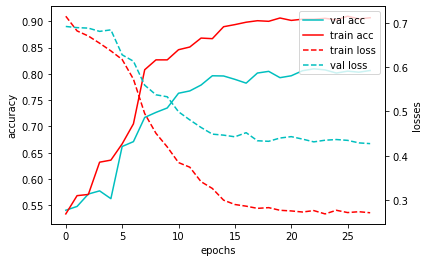

getting accuracies...



Train accuracy: 0.7475989731875333
Validation accuracy: 0.6768196202531646
Holdout accuracy: 0.6637658227848101

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.006_55168461 ##############
training...
Epoch 0/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.7186 Acc: 0.5304
Validation Loss: 0.6874 Acc: 0.5464
took 0m 36s

Epoch 1/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6814 Acc: 0.5594
Validation Loss: 0.6863 Acc: 0.5564
took 0m 27s

Epoch 2/29
----------
	 	 	 	 *** best model ***
Training Loss: 0.6715 Acc: 0.5833
Validation Loss: 0.6813 Acc: 0.5648
took 0m 27s

Epoch 3/29
----------
Training Loss: 0.6525 Acc: 0.6112
Validation Loss: 0.6759 Acc: 0.5696
took 0m 18s

Epoch 4/29
----------


KeyboardInterrupt: 

In [64]:
seeds=[116560000,55168461,18464876,32323548,98794515,58461,18464,23548,94515]

batch_size=32
acc_dif=0.04
stop_value=0.005
EPOCHS = 30
weight_decay=0
    
args = {
#        '2conv':[0.0018,0.03],
       '3conv':[0.0008,0.006],
       '4conv':[0.0006,0.006],
       'all':[0.0006,0.006]}

for block in list(args.keys()):
    for SEED in seeds:
        MRI = 1
        LR = args[block][MRI]

        acc = training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                            LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS,weight_decay)

        

In [15]:
import pickle
with open('val_indexes.pkl', 'wb') as fp:
	pickle.dump(val_indexes, fp)
    
with open('test_test_indexes.pkl', 'wb') as fp:
	pickle.dump(test_test_indexes, fp)
        
with open('test_finetune_indexes.pkl', 'wb') as fp:
	pickle.dump(test_finetune_indexes, fp)

In [16]:
seeds=[116560000,55168461,18464876,32323548,98794515,58461,18464,23548,94515]

batch_size=32
acc_dif=0.04
stop_value=0.005
EPOCHS = 50
weight_decay=0
    
args = {
#        '2conv':[0.0018,0.03],
       '3conv':[0.0008,0.006],
       '4conv':[0.0006,0.006],
       'all':[0.0006,0.006]}

for block in list(args.keys()):
    for SEED in seeds:
        MRI = 1
        LR = args[block][MRI]

        acc = training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                            LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS,weight_decay)


creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.006_116560000 ##############
training...
Epoch 0/49
----------


KeyboardInterrupt: 

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.001_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7771 Acc: 0.5236
Validation Loss: 0.7086 Acc: 0.5368
took 0m 33s

Epoch 1/49
----------
Training Loss: 0.6932 Acc: 0.5515
Validation Loss: 0.6988 Acc: 0.5368
took 0m 16s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6806 Acc: 0.5577
Validation Loss: 0.6933 Acc: 0.5436
took 0m 25s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6737 Acc: 0.5843
Validation Loss: 0.6936 Acc: 0.5564
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6675 Acc: 0.5889
Validation Loss: 0.6877 Acc: 0.5524
took 0m 16s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6578 Acc: 0.6095
Validation Loss: 0.6862 Acc: 0.5728
took 0m 25s

Epoch 6/49
----------
Training Loss: 0.6556 Acc: 0.6123
Validation Loss: 0.6844 Acc: 0.5520
took 0m 16s

Epoch 7/49
--

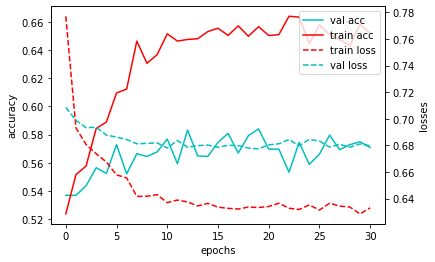

getting accuracies...



Train accuracy: 0.6338526389815591
Validation accuracy: 0.5605221518987342
Holdout accuracy: 0.567246835443038

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.001_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7731 Acc: 0.5282
Validation Loss: 0.7046 Acc: 0.5408
took 0m 33s

Epoch 1/49
----------
Training Loss: 0.6911 Acc: 0.5480
Validation Loss: 0.7001 Acc: 0.5312
took 0m 17s

Epoch 2/49
----------
Training Loss: 0.6843 Acc: 0.5611
Validation Loss: 0.6963 Acc: 0.5372
took 0m 18s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6735 Acc: 0.5794
Validation Loss: 0.6911 Acc: 0.5424
took 0m 27s

Epoch 4/49
----------
Training Loss: 0.6637 Acc: 0.6003
Validation Loss: 0.6967 Acc: 0.5412
took 0m 17s

Epoch 5/49
----------
Training Loss: 0.6596 Acc: 0.6004
Validation Loss: 0.6863 Acc: 0.5592
took 0m 16s

Epoch 6/49
----------
Training Loss:

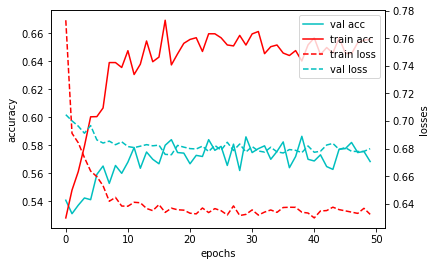

getting accuracies...



Train accuracy: 0.5952529322017323
Validation accuracy: 0.5514240506329114
Holdout accuracy: 0.5419303797468354

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.001_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7774 Acc: 0.5270
Validation Loss: 0.7098 Acc: 0.5296
took 0m 36s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6944 Acc: 0.5395
Validation Loss: 0.6976 Acc: 0.5464
took 0m 25s

Epoch 2/49
----------
Training Loss: 0.6807 Acc: 0.5640
Validation Loss: 0.6942 Acc: 0.5412
took 0m 16s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6704 Acc: 0.5838
Validation Loss: 0.6938 Acc: 0.5540
took 0m 25s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6672 Acc: 0.5970
Validation Loss: 0.6879 Acc: 0.5648
took 0m 25s

Epoch 5/49
----------
Training Loss: 0.6558 Acc: 0.6094
Validation Loss: 0.6934 Acc: 0

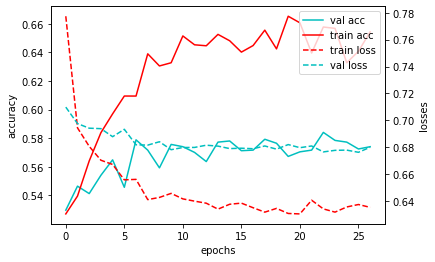

getting accuracies...



Train accuracy: 0.6287756594744596
Validation accuracy: 0.5664556962025317
Holdout accuracy: 0.5557753164556962

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.005_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7180 Acc: 0.5333
Validation Loss: 0.6899 Acc: 0.5532
took 0m 33s

Epoch 1/49
----------
Training Loss: 0.6825 Acc: 0.5714
Validation Loss: 0.6921 Acc: 0.5456
took 0m 16s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6725 Acc: 0.5742
Validation Loss: 0.6857 Acc: 0.5584
took 0m 25s

Epoch 3/49
----------
Training Loss: 0.6556 Acc: 0.6253
Validation Loss: 0.6833 Acc: 0.5700
took 0m 16s

Epoch 4/49
----------
Training Loss: 0.6408 Acc: 0.6429
Validation Loss: 0.6799 Acc: 0.5668
took 0m 16s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6245 Acc: 0.6561
Validation Loss: 0.6443 Acc: 0.6360
took 0m 25s

Epoch 6

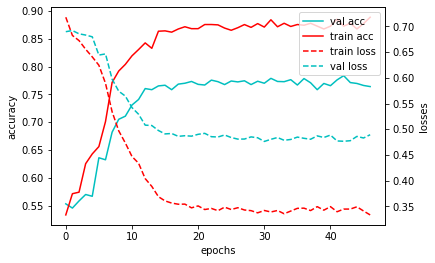

getting accuracies...



Train accuracy: 0.7219391497698697
Validation accuracy: 0.6507120253164557
Holdout accuracy: 0.6352848101265823

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.005_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7196 Acc: 0.5270
Validation Loss: 0.6884 Acc: 0.5356
took 0m 34s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6804 Acc: 0.5593
Validation Loss: 0.6874 Acc: 0.5620
took 0m 25s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6720 Acc: 0.5793
Validation Loss: 0.6852 Acc: 0.5716
took 0m 25s

Epoch 3/49
----------
Training Loss: 0.6505 Acc: 0.6168
Validation Loss: 0.6786 Acc: 0.5740
took 0m 17s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6388 Acc: 0.6367
Validation Loss: 0.6648 Acc: 0.6036
took 0m 25s

Epoch 5/49
----------
Training Loss: 0.6112 Acc: 0.6589
Validation Loss: 0.7036 Acc: 0

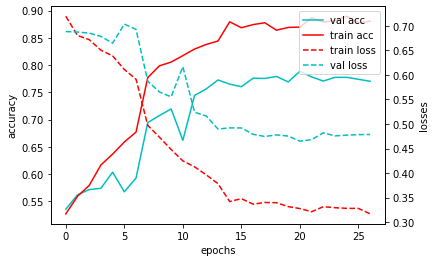

getting accuracies...



Train accuracy: 0.6719208207997409
Validation accuracy: 0.6162974683544303
Holdout accuracy: 0.6028481012658228

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.005_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7206 Acc: 0.5247
Validation Loss: 0.6905 Acc: 0.5396
took 0m 34s

Epoch 1/49
----------
Training Loss: 0.6842 Acc: 0.5486
Validation Loss: 0.6904 Acc: 0.5360
took 0m 16s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6728 Acc: 0.5708
Validation Loss: 0.6820 Acc: 0.5664
took 0m 25s

Epoch 3/49
----------
Training Loss: 0.6534 Acc: 0.6168
Validation Loss: 0.6809 Acc: 0.5740
took 0m 16s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6514 Acc: 0.6100
Validation Loss: 0.6595 Acc: 0.6096
took 0m 26s

Epoch 5/49
----------
Training Loss: 0.6153 Acc: 0.6652
Validation Loss: 0.6595 Acc: 0.6036
took 0m 16s

Epoch 6/

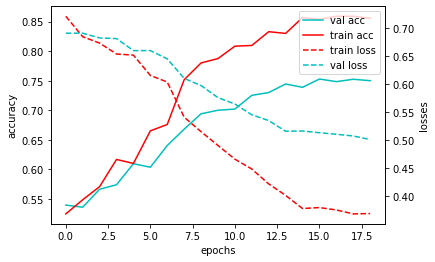

getting accuracies...



Train accuracy: 0.7186033725738525
Validation accuracy: 0.6356803797468354
Holdout accuracy: 0.6162974683544303

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.01_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7156 Acc: 0.5333
Validation Loss: 0.6874 Acc: 0.5632
took 0m 37s

Epoch 1/49
----------
Training Loss: 0.6872 Acc: 0.5447
Validation Loss: 0.6902 Acc: 0.5360
took 0m 16s

Epoch 2/49
----------
Training Loss: 0.6732 Acc: 0.5634
Validation Loss: 0.6932 Acc: 0.5588
took 0m 16s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6631 Acc: 0.6072
Validation Loss: 0.6806 Acc: 0.5744
took 0m 26s

Epoch 4/49
----------
Training Loss: 0.6435 Acc: 0.6321
Validation Loss: 0.7056 Acc: 0.5172
took 0m 16s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6252 Acc: 0.6629
Validation Loss: 0.6132 Acc: 0.6932
took 0m 26s

Epoch 6/

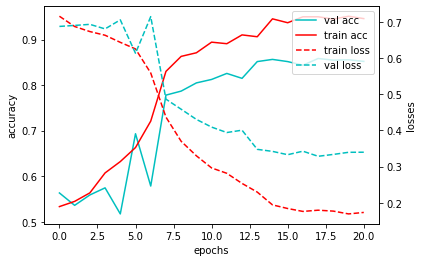

getting accuracies...



Train accuracy: 0.7817631959915161
Validation accuracy: 0.6906645569620253
Holdout accuracy: 0.6894778481012658

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.01_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7225 Acc: 0.5168
Validation Loss: 0.6880 Acc: 0.5416
took 0m 34s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6851 Acc: 0.5497
Validation Loss: 0.6863 Acc: 0.5528
took 0m 24s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6777 Acc: 0.5640
Validation Loss: 0.6807 Acc: 0.5684
took 0m 25s

Epoch 3/49
----------
Training Loss: 0.6597 Acc: 0.6078
Validation Loss: 0.6801 Acc: 0.5588
took 0m 16s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6467 Acc: 0.6226
Validation Loss: 0.6521 Acc: 0.6180
took 0m 26s

Epoch 5/49
----------
Training Loss: 0.6187 Acc: 0.6703
Validation Loss: 0.7477 Acc: 0.

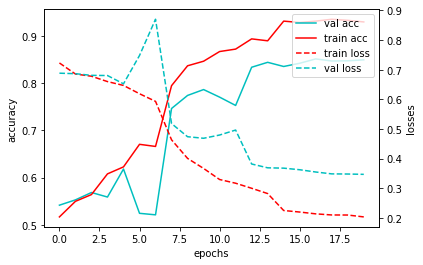

getting accuracies...



Train accuracy: 0.6900109968402169
Validation accuracy: 0.6352848101265823
Holdout accuracy: 0.620253164556962

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.01_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7156 Acc: 0.5161
Validation Loss: 0.6918 Acc: 0.5328
took 0m 35s

Epoch 1/49
----------
Training Loss: 0.6871 Acc: 0.5435
Validation Loss: 0.6935 Acc: 0.5232
took 0m 17s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6780 Acc: 0.5617
Validation Loss: 0.6830 Acc: 0.5572
took 0m 26s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6606 Acc: 0.5923
Validation Loss: 0.6779 Acc: 0.5652
took 0m 25s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6581 Acc: 0.6015
Validation Loss: 0.6597 Acc: 0.6048
took 0m 26s

Epoch 5/49
----------
Training Loss: 0.6207 Acc: 0.6646
Validation Loss: 0.6827 Acc: 0.5

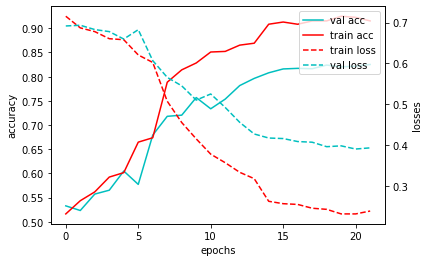

getting accuracies...



Train accuracy: 0.7782991203394803
Validation accuracy: 0.692246835443038
Holdout accuracy: 0.6811708860759493

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.02_116560000 ##############
training...
Epoch 0/49
----------
Training Loss: 0.7274 Acc: 0.4879
Validation Loss: 0.6908 Acc: 0.5308
took 0m 26s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6928 Acc: 0.5264
Validation Loss: 0.6947 Acc: 0.5152
took 0m 26s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6887 Acc: 0.5412
Validation Loss: 0.6900 Acc: 0.5344
took 0m 25s

Epoch 3/49
----------
Training Loss: 0.6831 Acc: 0.5543
Validation Loss: 0.6999 Acc: 0.5236
took 0m 16s

Epoch 4/49
----------
Training Loss: 0.6749 Acc: 0.5753
Validation Loss: 0.6918 Acc: 0.5172
took 0m 16s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6629 Acc: 0.6107
Validation Loss: 0.6529 Acc: 0.6340
took 0m 25s

Epoch 6/4

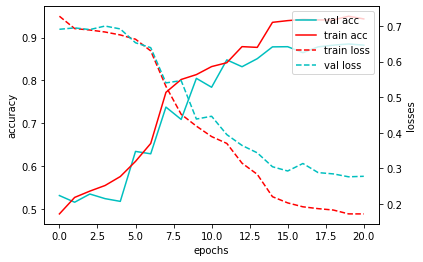

getting accuracies...



Train accuracy: 0.923203811862252
Validation accuracy: 0.8591772151898734
Holdout accuracy: 0.8753955696202531

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.02_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7342 Acc: 0.4889
Validation Loss: 0.6927 Acc: 0.5052
took 0m 33s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6943 Acc: 0.5145
Validation Loss: 0.6933 Acc: 0.5176
took 0m 25s

Epoch 2/49
----------
Training Loss: 0.6933 Acc: 0.4997
Validation Loss: 0.6947 Acc: 0.5132
took 0m 16s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6885 Acc: 0.5435
Validation Loss: 0.6937 Acc: 0.5208
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6851 Acc: 0.5554
Validation Loss: 0.6956 Acc: 0.5168
took 0m 16s

Epoch 5/49
----------
Training Loss: 0.6782 Acc: 0.5725
Validation Loss: 0.7314 Acc: 0.5132
took 0m 16s

Epoch 6/49

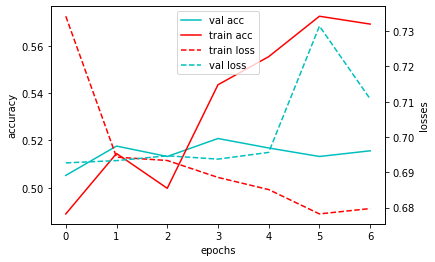

getting accuracies...



Train accuracy: 0.5276576248082248
Validation accuracy: 0.5193829113924051
Holdout accuracy: 0.49485759493670883

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.02_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7202 Acc: 0.5036
Validation Loss: 0.6941 Acc: 0.5164
took 0m 36s

Epoch 1/49
----------
Training Loss: 0.6936 Acc: 0.5088
Validation Loss: 0.6929 Acc: 0.5112
took 0m 17s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6907 Acc: 0.5225
Validation Loss: 0.6878 Acc: 0.5388
took 0m 27s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6809 Acc: 0.5623
Validation Loss: 0.6860 Acc: 0.5556
took 0m 27s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6812 Acc: 0.5748
Validation Loss: 0.6762 Acc: 0.5800
took 0m 26s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6629 Acc: 0.5963
Val

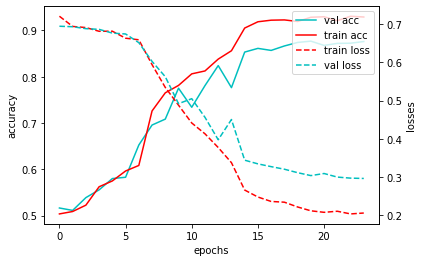

getting accuracies...



Train accuracy: 0.8788856300440702
Validation accuracy: 0.8338607594936709
Holdout accuracy: 0.8481012658227848

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.05_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7452 Acc: 0.4935
Validation Loss: 0.6932 Acc: 0.5132
took 0m 34s

Epoch 1/49
----------
Training Loss: 0.6946 Acc: 0.5032
Validation Loss: 0.6924 Acc: 0.5132
took 0m 16s

Epoch 2/49
----------
Training Loss: 0.6937 Acc: 0.5167
Validation Loss: 0.6934 Acc: 0.4896
took 0m 16s

Epoch 3/49
----------
Training Loss: 0.6932 Acc: 0.5043
Validation Loss: 0.6939 Acc: 0.5132
took 0m 16s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6926 Acc: 0.5179
Validation Loss: 0.6914 Acc: 0.5192
took 0m 26s

Epoch 5/49
----------
Training Loss: 0.6911 Acc: 0.5367
Validation Loss: 0.6913 Acc: 0.5136
took 0m 16s

Epoch 6/49
----------
Training Loss

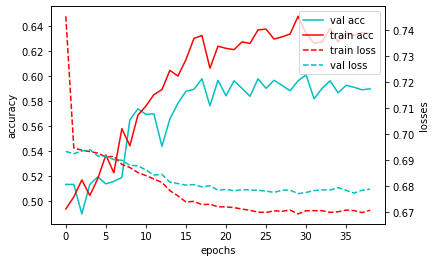

getting accuracies...



Train accuracy: 0.63726172989065
Validation accuracy: 0.6000791139240507
Holdout accuracy: 0.5988924050632911

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.05_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7578 Acc: 0.4912
Validation Loss: 0.6927 Acc: 0.5212
took 0m 34s

Epoch 1/49
----------
Training Loss: 0.6944 Acc: 0.5037
Validation Loss: 0.6930 Acc: 0.5132
took 0m 16s

Epoch 2/49
----------
Training Loss: 0.6943 Acc: 0.4929
Validation Loss: 0.6944 Acc: 0.5132
took 0m 16s

Epoch 3/49
----------
Training Loss: 0.6930 Acc: 0.5168
Validation Loss: 0.6929 Acc: 0.5136
took 0m 16s

Epoch 4/49
----------
Training Loss: 0.6930 Acc: 0.5111
Validation Loss: 0.6949 Acc: 0.5132
took 0m 16s

Epoch 5/49
----------
Training Loss: 0.6921 Acc: 0.5202
Validation Loss: 0.6919 Acc: 0.5168
took 0m 16s

Epoch 6/49
----------
Training Loss: 0.6936 Acc: 0.5053
Validatio

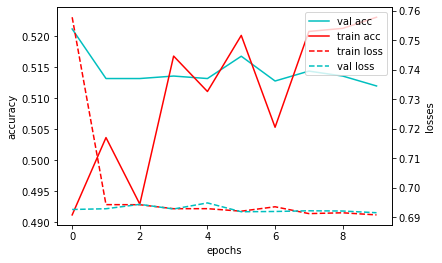

getting accuracies...



Train accuracy: 0.5258064513856714
Validation accuracy: 0.5209651898734177
Holdout accuracy: 0.504746835443038

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_1759_0.05_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7324 Acc: 0.4878
Validation Loss: 0.6930 Acc: 0.5072
took 0m 34s

Epoch 1/49
----------
Training Loss: 0.6948 Acc: 0.4906
Validation Loss: 0.6930 Acc: 0.5040
took 0m 16s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6953 Acc: 0.4975
Validation Loss: 0.6933 Acc: 0.5132
took 0m 26s

Epoch 3/49
----------
Training Loss: 0.6925 Acc: 0.5179
Validation Loss: 0.6935 Acc: 0.5132
took 0m 17s

Epoch 4/49
----------
Training Loss: 0.6939 Acc: 0.4998
Validation Loss: 0.6930 Acc: 0.5132
took 0m 17s

Epoch 5/49
----------
Training Loss: 0.6918 Acc: 0.5258
Validation Loss: 0.6944 Acc: 0.5132
took 0m 16s

Epoch 6/49
----------
Training Loss: 

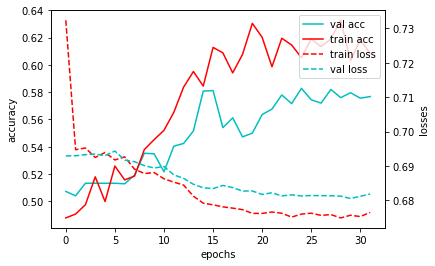

getting accuracies...



Train accuracy: 0.6009347503835505
Validation accuracy: 0.5771360759493671
Holdout accuracy: 0.569620253164557

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.001_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7723 Acc: 0.5276
Validation Loss: 0.7077 Acc: 0.5332
took 0m 36s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6918 Acc: 0.5481
Validation Loss: 0.6980 Acc: 0.5360
took 0m 27s

Epoch 2/49
----------
Training Loss: 0.6797 Acc: 0.5571
Validation Loss: 0.6947 Acc: 0.5340
took 0m 18s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6737 Acc: 0.5843
Validation Loss: 0.6942 Acc: 0.5516
took 0m 28s

Epoch 4/49
----------
Training Loss: 0.6679 Acc: 0.5861
Validation Loss: 0.6891 Acc: 0.5456
took 0m 19s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6585 Acc: 0.6060
Validation Loss: 0.6875 Acc: 0

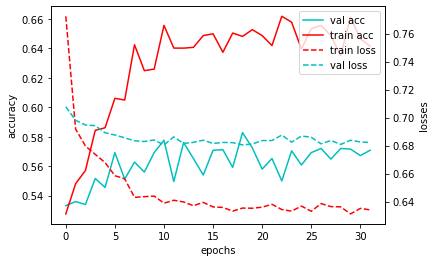

getting accuracies...



Train accuracy: 0.6304435480724682
Validation accuracy: 0.5522151898734177
Holdout accuracy: 0.5537974683544303

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.001_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7681 Acc: 0.5316
Validation Loss: 0.7028 Acc: 0.5388
took 0m 39s

Epoch 1/49
----------
Training Loss: 0.6899 Acc: 0.5560
Validation Loss: 0.6998 Acc: 0.5356
took 0m 18s

Epoch 2/49
----------
Training Loss: 0.6843 Acc: 0.5611
Validation Loss: 0.6964 Acc: 0.5376
took 0m 18s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6726 Acc: 0.5782
Validation Loss: 0.6921 Acc: 0.5436
took 0m 28s

Epoch 4/49
----------
Training Loss: 0.6641 Acc: 0.5889
Validation Loss: 0.6961 Acc: 0.5464
took 0m 18s

Epoch 5/49
----------
Training Loss: 0.6621 Acc: 0.5987
Validation Loss: 0.6879 Acc: 0.5516
took 0m 18s

Epoch 6/49
----------
Training Loss

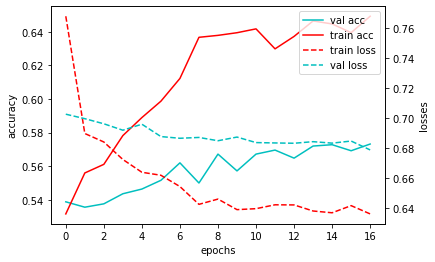

getting accuracies...



Train accuracy: 0.595839442990043
Validation accuracy: 0.5494462025316456
Holdout accuracy: 0.5391613924050633

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.001_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7737 Acc: 0.5247
Validation Loss: 0.7081 Acc: 0.5344
took 0m 36s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6935 Acc: 0.5361
Validation Loss: 0.6966 Acc: 0.5416
took 0m 27s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6814 Acc: 0.5646
Validation Loss: 0.6940 Acc: 0.5480
took 0m 26s

Epoch 3/49
----------
Training Loss: 0.6717 Acc: 0.5838
Validation Loss: 0.6940 Acc: 0.5464
took 0m 18s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6693 Acc: 0.5873
Validation Loss: 0.6892 Acc: 0.5584
took 0m 28s

Epoch 5/49
----------
Training Loss: 0.6593 Acc: 0.6032
Validation Loss: 0.6937 Acc: 0.

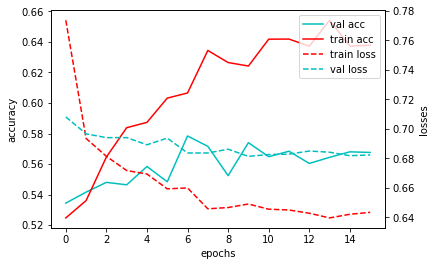

getting accuracies...



Train accuracy: 0.6212976536967537
Validation accuracy: 0.5660601265822784
Holdout accuracy: 0.5534018987341772

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.005_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7152 Acc: 0.5344
Validation Loss: 0.6899 Acc: 0.5484
took 0m 35s

Epoch 1/49
----------
Training Loss: 0.6823 Acc: 0.5703
Validation Loss: 0.6922 Acc: 0.5460
took 0m 18s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6720 Acc: 0.5628
Validation Loss: 0.6876 Acc: 0.5748
took 0m 28s

Epoch 3/49
----------
Training Loss: 0.6579 Acc: 0.6106
Validation Loss: 0.6930 Acc: 0.5740
took 0m 18s

Epoch 4/49
----------
Training Loss: 0.6436 Acc: 0.6316
Validation Loss: 0.6812 Acc: 0.5684
took 0m 18s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6249 Acc: 0.6538
Validation Loss: 0.6471 Acc: 0.6340
took 0m 26s

Epoch 6

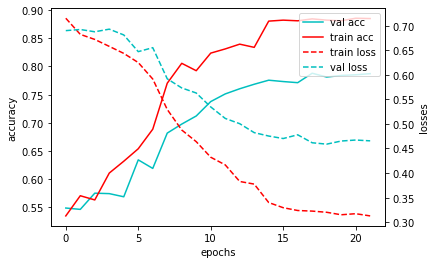

getting accuracies...



Train accuracy: 0.7208760998465799
Validation accuracy: 0.6360759493670886
Holdout accuracy: 0.6289556962025317

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.005_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7196 Acc: 0.5236
Validation Loss: 0.6874 Acc: 0.5376
took 0m 36s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6820 Acc: 0.5662
Validation Loss: 0.6877 Acc: 0.5504
took 0m 27s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6728 Acc: 0.5822
Validation Loss: 0.6864 Acc: 0.5608
took 0m 27s

Epoch 3/49
----------
Training Loss: 0.6575 Acc: 0.6037
Validation Loss: 0.6887 Acc: 0.5492
took 0m 18s

Epoch 4/49
----------
Training Loss: 0.6462 Acc: 0.6310
Validation Loss: 0.6770 Acc: 0.5896
took 0m 18s

Epoch 5/49
----------
Training Loss: 0.6235 Acc: 0.6425
Validation Loss: 0.7044 Acc: 0.5664
took 0m 18s

Epoch 6/

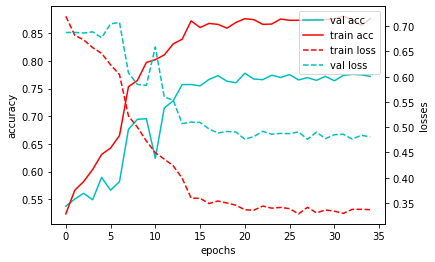

getting accuracies...



Train accuracy: 0.6088159821250222
Validation accuracy: 0.5680379746835443
Holdout accuracy: 0.5470727848101266

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.005_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7183 Acc: 0.5321
Validation Loss: 0.6913 Acc: 0.5388
took 0m 36s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6839 Acc: 0.5508
Validation Loss: 0.6919 Acc: 0.5396
took 0m 27s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6745 Acc: 0.5748
Validation Loss: 0.6849 Acc: 0.5588
took 0m 27s

Epoch 3/49
----------
Training Loss: 0.6550 Acc: 0.6111
Validation Loss: 0.6836 Acc: 0.5612
took 0m 18s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6558 Acc: 0.6032
Validation Loss: 0.6709 Acc: 0.5956
took 0m 27s

Epoch 5/49
----------
Training Loss: 0.6249 Acc: 0.6538
Validation Loss: 0.6652 Acc: 0

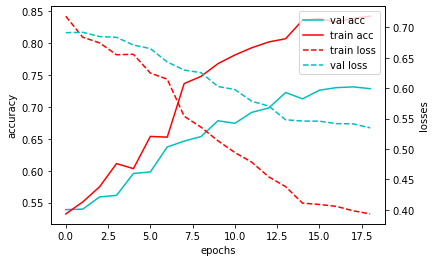

getting accuracies...



Train accuracy: 0.7448130499232899
Validation accuracy: 0.6360759493670886
Holdout accuracy: 0.6313291139240507

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.01_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7149 Acc: 0.5372
Validation Loss: 0.6889 Acc: 0.5508
took 0m 36s

Epoch 1/49
----------
Training Loss: 0.6856 Acc: 0.5572
Validation Loss: 0.6925 Acc: 0.5328
took 0m 19s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6733 Acc: 0.5651
Validation Loss: 0.6910 Acc: 0.5572
took 0m 26s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6602 Acc: 0.6118
Validation Loss: 0.6855 Acc: 0.5760
took 0m 26s

Epoch 4/49
----------
Training Loss: 0.6450 Acc: 0.6213
Validation Loss: 0.7056 Acc: 0.5216
took 0m 18s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6233 Acc: 0.6652
Validation Loss: 0.6207 Acc: 0

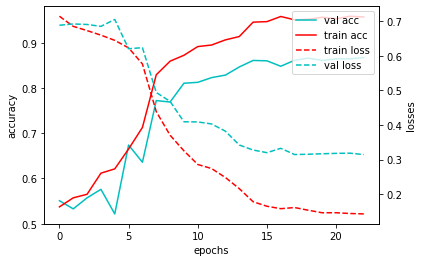

getting accuracies...



Train accuracy: 0.7686217004602606
Validation accuracy: 0.6716772151898734
Holdout accuracy: 0.6712816455696202

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.01_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7237 Acc: 0.5122
Validation Loss: 0.6896 Acc: 0.5404
took 0m 35s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6878 Acc: 0.5446
Validation Loss: 0.6868 Acc: 0.5436
took 0m 26s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6808 Acc: 0.5703
Validation Loss: 0.6861 Acc: 0.5592
took 0m 27s

Epoch 3/49
----------
Training Loss: 0.6663 Acc: 0.5975
Validation Loss: 0.6935 Acc: 0.5296
took 0m 18s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6607 Acc: 0.6157
Validation Loss: 0.6720 Acc: 0.5968
took 0m 27s

Epoch 5/49
----------
Training Loss: 0.6369 Acc: 0.6379
Validation Loss: 0.7424 Acc: 0.

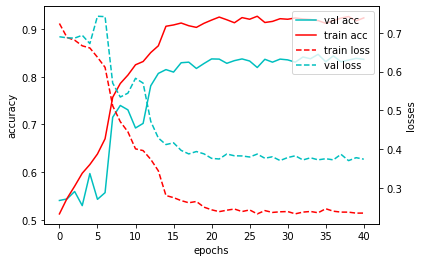

getting accuracies...



Train accuracy: 0.6498167157173157
Validation accuracy: 0.5957278481012658
Holdout accuracy: 0.5771360759493671

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.01_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7136 Acc: 0.5242
Validation Loss: 0.6904 Acc: 0.5324
took 0m 37s

Epoch 1/49
----------
Training Loss: 0.6880 Acc: 0.5395
Validation Loss: 0.6926 Acc: 0.5196
took 0m 18s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6789 Acc: 0.5509
Validation Loss: 0.6833 Acc: 0.5588
took 0m 28s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6590 Acc: 0.5981
Validation Loss: 0.6805 Acc: 0.5676
took 0m 28s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6583 Acc: 0.6067
Validation Loss: 0.6588 Acc: 0.6136
took 0m 28s

Epoch 5/49
----------
Training Loss: 0.6186 Acc: 0.6607
Validation Loss: 0.6875 Acc: 0.

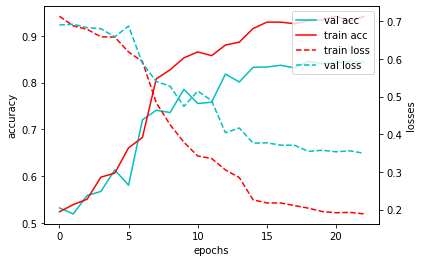

getting accuracies...



Train accuracy: 0.7936217004602606
Validation accuracy: 0.7195411392405063
Holdout accuracy: 0.7072784810126582

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.02_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7251 Acc: 0.5054
Validation Loss: 0.6917 Acc: 0.5288
took 0m 36s

Epoch 1/49
----------
Training Loss: 0.6947 Acc: 0.5293
Validation Loss: 0.6934 Acc: 0.5144
took 0m 18s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6896 Acc: 0.5400
Validation Loss: 0.6885 Acc: 0.5452
took 0m 26s

Epoch 3/49
----------
Training Loss: 0.6839 Acc: 0.5612
Validation Loss: 0.7018 Acc: 0.5180
took 0m 18s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6792 Acc: 0.5708
Validation Loss: 0.6790 Acc: 0.5656
took 0m 27s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6662 Acc: 0.5993
Validation Loss: 0.6702 Acc: 0

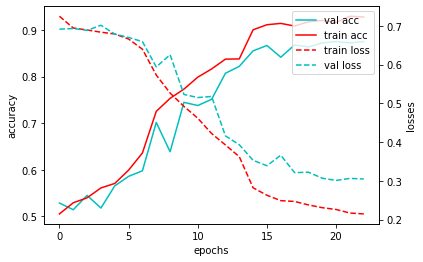

getting accuracies...



Train accuracy: 0.8800953073935075
Validation accuracy: 0.8223892405063291
Holdout accuracy: 0.8393987341772152

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.02_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7339 Acc: 0.4861
Validation Loss: 0.6925 Acc: 0.5236
took 0m 36s

Epoch 1/49
----------
Training Loss: 0.6938 Acc: 0.5162
Validation Loss: 0.6929 Acc: 0.5164
took 0m 18s

Epoch 2/49
----------
Training Loss: 0.6923 Acc: 0.5088
Validation Loss: 0.6946 Acc: 0.5168
took 0m 18s

Epoch 3/49
----------
Training Loss: 0.6864 Acc: 0.5560
Validation Loss: 0.6921 Acc: 0.5160
took 0m 18s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6847 Acc: 0.5537
Validation Loss: 0.6893 Acc: 0.5320
took 0m 27s

Epoch 5/49
----------
Training Loss: 0.6744 Acc: 0.5839
Validation Loss: 0.7128 Acc: 0.5132
took 0m 18s

Epoch 6/49
----------
Training Loss:

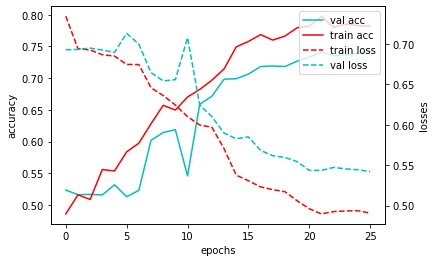

getting accuracies...



Train accuracy: 0.7487353368238969
Validation accuracy: 0.7009493670886076
Holdout accuracy: 0.6981803797468354

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.02_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7201 Acc: 0.4928
Validation Loss: 0.6933 Acc: 0.5232
took 0m 37s

Epoch 1/49
----------
Training Loss: 0.6935 Acc: 0.5145
Validation Loss: 0.6922 Acc: 0.5124
took 0m 18s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6914 Acc: 0.5146
Validation Loss: 0.6882 Acc: 0.5416
took 0m 27s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6805 Acc: 0.5571
Validation Loss: 0.6872 Acc: 0.5460
took 0m 26s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6812 Acc: 0.5645
Validation Loss: 0.6769 Acc: 0.5816
took 0m 27s

Epoch 5/49
----------
Training Loss: 0.6799 Acc: 0.5560
Validation Loss: 0.6915 Acc: 0.

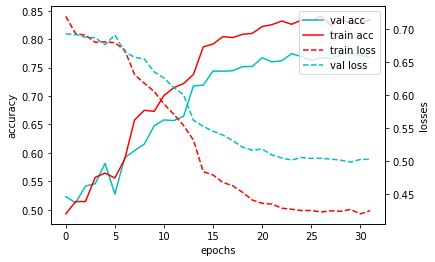

getting accuracies...



Train accuracy: 0.7777492664077065
Validation accuracy: 0.7120253164556962
Holdout accuracy: 0.7219145569620253

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.05_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7397 Acc: 0.5066
Validation Loss: 0.6937 Acc: 0.5132
took 0m 36s

Epoch 1/49
----------
Training Loss: 0.6955 Acc: 0.5015
Validation Loss: 0.6930 Acc: 0.5132
took 0m 18s

Epoch 2/49
----------
Training Loss: 0.6943 Acc: 0.5258
Validation Loss: 0.6944 Acc: 0.4888
took 0m 18s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6941 Acc: 0.5117
Validation Loss: 0.6935 Acc: 0.5136
took 0m 28s

Epoch 4/49
----------
Training Loss: 0.6932 Acc: 0.5105
Validation Loss: 0.6928 Acc: 0.5128
took 0m 19s

Epoch 5/49
----------
Training Loss: 0.6931 Acc: 0.5140
Validation Loss: 0.6938 Acc: 0.5132
took 0m 18s

Epoch 6/49
----------
	 	 	 	 *** b

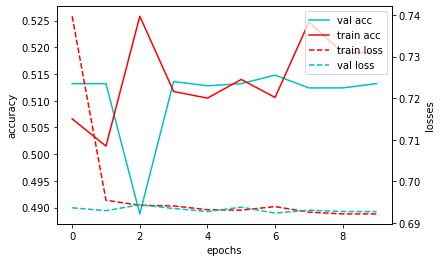

getting accuracies...



Train accuracy: 0.5218291786583987
Validation accuracy: 0.5134493670886076
Holdout accuracy: 0.4924841772151899

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.05_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7557 Acc: 0.4843
Validation Loss: 0.6927 Acc: 0.5140
took 0m 37s

Epoch 1/49
----------
Training Loss: 0.6938 Acc: 0.5184
Validation Loss: 0.6930 Acc: 0.5132
took 0m 18s

Epoch 2/49
----------
Training Loss: 0.6942 Acc: 0.4969
Validation Loss: 0.6941 Acc: 0.5132
took 0m 18s

Epoch 3/49
----------
Training Loss: 0.6934 Acc: 0.5049
Validation Loss: 0.6929 Acc: 0.5132
took 0m 18s

Epoch 4/49
----------
Training Loss: 0.6932 Acc: 0.5083
Validation Loss: 0.6946 Acc: 0.5132
took 0m 18s

Epoch 5/49
----------
Training Loss: 0.6929 Acc: 0.5168
Validation Loss: 0.6928 Acc: 0.5060
took 0m 18s

Epoch 6/49
----------
	 	 	 	 *** best model ***
Training Loss:

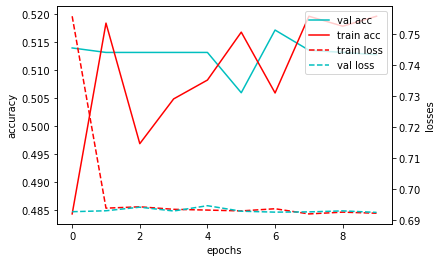

getting accuracies...



Train accuracy: 0.5161840173331174
Validation accuracy: 0.5130537974683544
Holdout accuracy: 0.49050632911392406

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_1759_0.05_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7292 Acc: 0.4884
Validation Loss: 0.6934 Acc: 0.5008
took 0m 36s

Epoch 1/49
----------
Training Loss: 0.6946 Acc: 0.4918
Validation Loss: 0.6932 Acc: 0.5000
took 0m 18s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6957 Acc: 0.4907
Validation Loss: 0.6936 Acc: 0.5132
took 0m 28s

Epoch 3/49
----------
Training Loss: 0.6929 Acc: 0.5179
Validation Loss: 0.6940 Acc: 0.5132
took 0m 18s

Epoch 4/49
----------
Training Loss: 0.6943 Acc: 0.5009
Validation Loss: 0.6938 Acc: 0.5132
took 0m 19s

Epoch 5/49
----------
Training Loss: 0.6932 Acc: 0.5258
Validation Loss: 0.6935 Acc: 0.5132
took 0m 18s

Epoch 6/49
----------
Training Loss

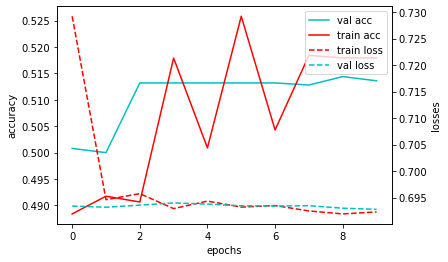

getting accuracies...



Train accuracy: 0.5167705275795677
Validation accuracy: 0.5126582278481012
Holdout accuracy: 0.49169303797468356

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.001_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7700 Acc: 0.5247
Validation Loss: 0.7058 Acc: 0.5332
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6919 Acc: 0.5406
Validation Loss: 0.6975 Acc: 0.5360
took 0m 31s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6793 Acc: 0.5719
Validation Loss: 0.6948 Acc: 0.5400
took 0m 31s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6742 Acc: 0.5815
Validation Loss: 0.6951 Acc: 0.5492
took 0m 32s

Epoch 4/49
----------
Training Loss: 0.6690 Acc: 0.5923
Validation Loss: 0.6886 Acc: 0.5484
took 0m 22s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6595 Acc: 0.6032
Val

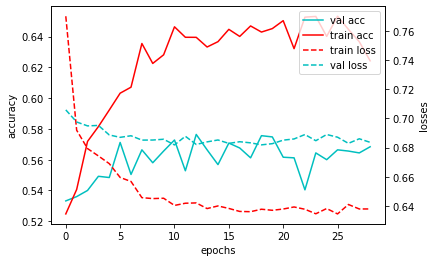

getting accuracies...



Train accuracy: 0.6276576248082247
Validation accuracy: 0.5522151898734177
Holdout accuracy: 0.5526107594936709

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.001_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7646 Acc: 0.5271
Validation Loss: 0.7008 Acc: 0.5352
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6896 Acc: 0.5560
Validation Loss: 0.6981 Acc: 0.5344
took 0m 22s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6840 Acc: 0.5696
Validation Loss: 0.6962 Acc: 0.5360
took 0m 31s

Epoch 3/49
----------
out
Training Loss: 0.6730 Acc: 0.5794
Validation Loss: 0.6918 Acc: 0.5392
took 0m 23s

Training complete in 1m 56s
Best val Acc: 0.536000



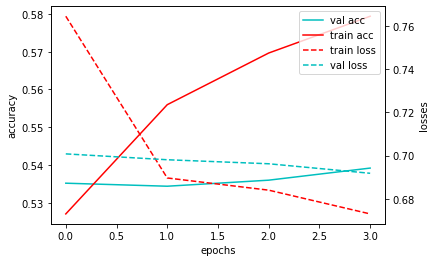

getting accuracies...



Train accuracy: 0.5787573315880515
Validation accuracy: 0.5423259493670886
Holdout accuracy: 0.5340189873417721

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.001_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7709 Acc: 0.5235
Validation Loss: 0.7051 Acc: 0.5320
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6928 Acc: 0.5344
Validation Loss: 0.6966 Acc: 0.5432
took 0m 30s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6816 Acc: 0.5606
Validation Loss: 0.6940 Acc: 0.5464
took 0m 31s

Epoch 3/49
----------
Training Loss: 0.6721 Acc: 0.5867
Validation Loss: 0.6939 Acc: 0.5436
took 0m 22s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6705 Acc: 0.5879
Validation Loss: 0.6891 Acc: 0.5628
took 0m 30s

Epoch 5/49
----------
Training Loss: 0.6597 Acc: 0.5992
Validation Loss: 0.6943 Acc: 0.5

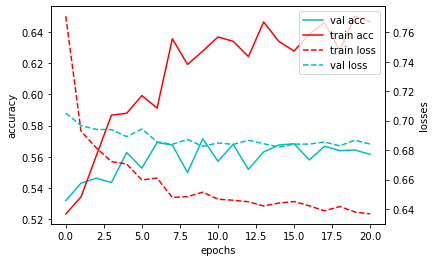

getting accuracies...



Train accuracy: 0.6287573315880516
Validation accuracy: 0.5569620253164557
Holdout accuracy: 0.555379746835443

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.005_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7146 Acc: 0.5292
Validation Loss: 0.6892 Acc: 0.5516
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6810 Acc: 0.5720
Validation Loss: 0.6902 Acc: 0.5496
took 0m 22s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6687 Acc: 0.5759
Validation Loss: 0.6873 Acc: 0.5704
took 0m 30s

Epoch 3/49
----------
Training Loss: 0.6572 Acc: 0.6157
Validation Loss: 0.6895 Acc: 0.5740
took 0m 22s

Epoch 4/49
----------
Training Loss: 0.6453 Acc: 0.6247
Validation Loss: 0.7023 Acc: 0.5356
took 0m 23s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6263 Acc: 0.6505
Validation Loss: 0.6458 Acc: 0.6316
took 0m 32s

Epoch 6/49

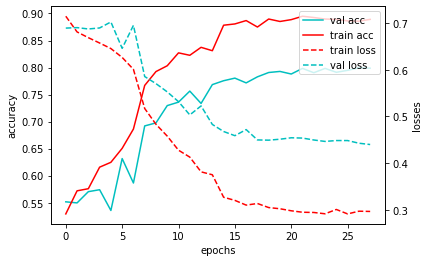

getting accuracies...



Train accuracy: 0.704930352080952
Validation accuracy: 0.6408227848101266
Holdout accuracy: 0.632120253164557

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.005_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7195 Acc: 0.5321
Validation Loss: 0.6874 Acc: 0.5440
took 0m 39s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6805 Acc: 0.5691
Validation Loss: 0.6868 Acc: 0.5556
took 0m 30s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6722 Acc: 0.5816
Validation Loss: 0.6856 Acc: 0.5680
took 0m 31s

Epoch 3/49
----------
Training Loss: 0.6553 Acc: 0.6095
Validation Loss: 0.6865 Acc: 0.5516
took 0m 22s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6448 Acc: 0.6288
Validation Loss: 0.6719 Acc: 0.5928
took 0m 32s

Epoch 5/49
----------
Training Loss: 0.6259 Acc: 0.6522
Validation Loss: 0.6849 Acc: 0.591

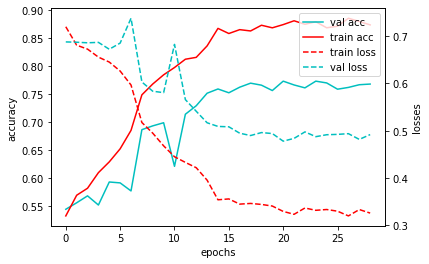

getting accuracies...



Train accuracy: 0.6623533725738525
Validation accuracy: 0.603243670886076
Holdout accuracy: 0.589003164556962

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.005_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7164 Acc: 0.5372
Validation Loss: 0.6892 Acc: 0.5428
took 0m 39s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6813 Acc: 0.5486
Validation Loss: 0.6878 Acc: 0.5452
took 0m 31s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6733 Acc: 0.5719
Validation Loss: 0.6821 Acc: 0.5664
took 0m 32s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6520 Acc: 0.6089
Validation Loss: 0.6777 Acc: 0.5780
took 0m 31s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6546 Acc: 0.6089
Validation Loss: 0.6614 Acc: 0.6068
took 0m 31s

Epoch 5/49
----------
Training Loss: 0.6218 Acc: 0.6652
Validat

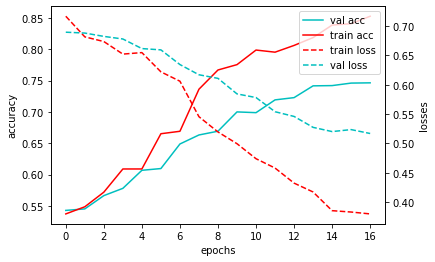

getting accuracies...



Train accuracy: 0.714076245914806
Validation accuracy: 0.6412183544303798
Holdout accuracy: 0.6487341772151899

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.01_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7196 Acc: 0.5236
Validation Loss: 0.6901 Acc: 0.5392
took 0m 39s

Epoch 1/49
----------
Training Loss: 0.6908 Acc: 0.5441
Validation Loss: 0.6902 Acc: 0.5244
took 0m 22s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6815 Acc: 0.5503
Validation Loss: 0.6853 Acc: 0.5604
took 0m 32s

Epoch 3/49
----------
Training Loss: 0.6743 Acc: 0.5844
Validation Loss: 0.6950 Acc: 0.5416
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6659 Acc: 0.6020
Validation Loss: 0.6949 Acc: 0.5292
took 0m 22s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6509 Acc: 0.6299
Validation Loss: 0.6578 Acc: 0.6144
took 0m 31s

Epoch 6/49


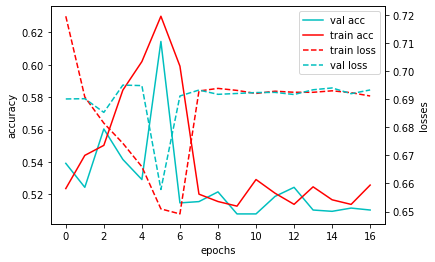

getting accuracies...



Train accuracy: 0.676557918028398
Validation accuracy: 0.6135284810126582
Holdout accuracy: 0.625

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.01_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7289 Acc: 0.5071
Validation Loss: 0.6898 Acc: 0.5388
took 0m 39s

Epoch 1/49
----------
Training Loss: 0.6921 Acc: 0.5145
Validation Loss: 0.6900 Acc: 0.5312
took 0m 22s

Epoch 2/49
----------
Training Loss: 0.6886 Acc: 0.5350
Validation Loss: 0.6875 Acc: 0.5368
took 0m 22s

Epoch 3/49
----------
Training Loss: 0.6805 Acc: 0.5686
Validation Loss: 0.6884 Acc: 0.5268
took 0m 22s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6758 Acc: 0.5736
Validation Loss: 0.6894 Acc: 0.5444
took 0m 30s

Epoch 5/49
----------
Training Loss: 0.6654 Acc: 0.6020
Validation Loss: 0.7188 Acc: 0.5116
took 0m 22s

Epoch 6/49
----------
Training Loss: 0.6629 Acc: 0.6

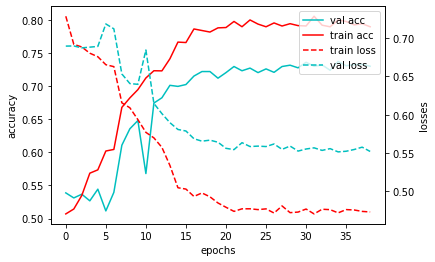

getting accuracies...



Train accuracy: 0.5701612900603902
Validation accuracy: 0.5454905063291139
Holdout accuracy: 0.5249208860759493

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.01_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7154 Acc: 0.5173
Validation Loss: 0.6893 Acc: 0.5440
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6850 Acc: 0.5406
Validation Loss: 0.6926 Acc: 0.5180
took 0m 22s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6796 Acc: 0.5736
Validation Loss: 0.6803 Acc: 0.5704
took 0m 31s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6608 Acc: 0.5924
Validation Loss: 0.6747 Acc: 0.5864
took 0m 31s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6680 Acc: 0.5816
Validation Loss: 0.6612 Acc: 0.6128
took 0m 31s

Epoch 5/49
----------
Training Loss: 0.6334 Acc: 0.6635
Validation Loss: 0.7228 Acc: 0.55

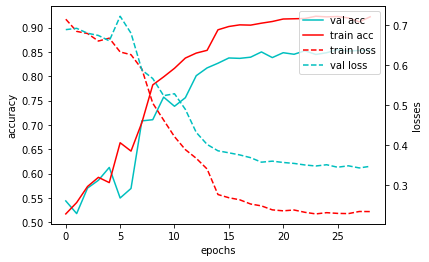

getting accuracies...



Train accuracy: 0.8879398822784423
Validation accuracy: 0.8247626582278481
Holdout accuracy: 0.8287183544303798

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.02_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7324 Acc: 0.4992
Validation Loss: 0.6940 Acc: 0.5148
took 0m 39s

Epoch 1/49
----------
Training Loss: 0.6948 Acc: 0.5026
Validation Loss: 0.6925 Acc: 0.5136
took 0m 22s

Epoch 2/49
----------
Training Loss: 0.6941 Acc: 0.5235
Validation Loss: 0.6945 Acc: 0.4864
took 0m 22s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6938 Acc: 0.5072
Validation Loss: 0.6939 Acc: 0.5152
took 0m 31s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6932 Acc: 0.5144
Validation Loss: 0.6920 Acc: 0.5168
took 0m 30s

Epoch 5/49
----------
Training Loss: 0.6916 Acc: 0.5253
Validation Loss: 0.6929 Acc: 0.5084
took 0m 22s

Epoch 6/49

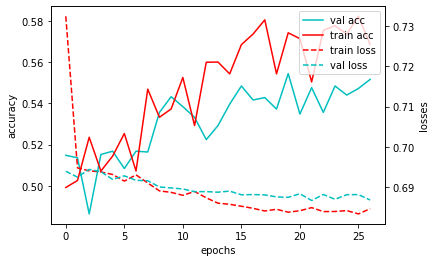

getting accuracies...



Train accuracy: 0.5810483867471868
Validation accuracy: 0.5462816455696202
Holdout accuracy: 0.5474683544303798

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.02_55168461 ##############
training...
Epoch 0/49
----------
Training Loss: 0.7396 Acc: 0.4838
Validation Loss: 0.6925 Acc: 0.5272
took 0m 32s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6941 Acc: 0.5093
Validation Loss: 0.6933 Acc: 0.5156
took 0m 31s

Epoch 2/49
----------
Training Loss: 0.6947 Acc: 0.4855
Validation Loss: 0.6945 Acc: 0.5132
took 0m 22s

Epoch 3/49
----------
Training Loss: 0.6940 Acc: 0.5066
Validation Loss: 0.6936 Acc: 0.5132
took 0m 22s

Epoch 4/49
----------
Training Loss: 0.6929 Acc: 0.5037
Validation Loss: 0.6950 Acc: 0.5132
took 0m 22s

Epoch 5/49
----------
Training Loss: 0.6931 Acc: 0.5008
Validation Loss: 0.6929 Acc: 0.5140
took 0m 22s

Epoch 6/49
----------
Training Loss: 0.6931 Acc: 0.5060
Validatio

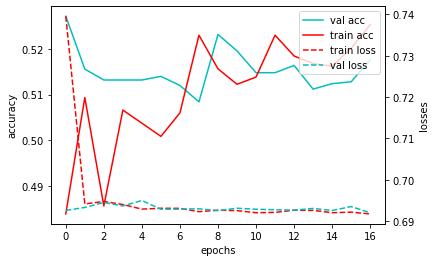

getting accuracies...



Train accuracy: 0.5207478003068404
Validation accuracy: 0.5134493670886076
Holdout accuracy: 0.4920886075949367

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.02_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7216 Acc: 0.4940
Validation Loss: 0.6930 Acc: 0.5028
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6942 Acc: 0.4986
Validation Loss: 0.6936 Acc: 0.5044
took 0m 30s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6957 Acc: 0.4839
Validation Loss: 0.6925 Acc: 0.5144
took 0m 31s

Epoch 3/49
----------
Training Loss: 0.6917 Acc: 0.5259
Validation Loss: 0.6925 Acc: 0.5144
took 0m 22s

Epoch 4/49
----------
Training Loss: 0.6940 Acc: 0.5111
Validation Loss: 0.6928 Acc: 0.5136
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6903 Acc: 0.5327
Validation Loss: 0.6938 Acc: 0.5140
took 0m 23s

Epoch 6/49


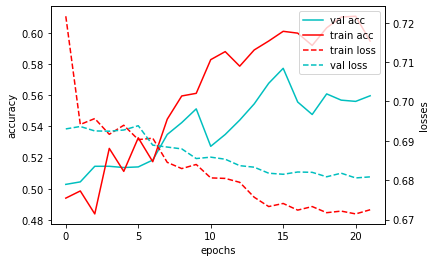

getting accuracies...



Train accuracy: 0.6083211140199141
Validation accuracy: 0.5712025316455697
Holdout accuracy: 0.567246835443038

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.05_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7681 Acc: 0.5055
Validation Loss: 0.6938 Acc: 0.5132
took 0m 41s

Epoch 1/49
----------
Training Loss: 0.6941 Acc: 0.5072
Validation Loss: 0.6930 Acc: 0.5128
took 0m 22s

Epoch 2/49
----------
Training Loss: 0.6937 Acc: 0.5111
Validation Loss: 0.6940 Acc: 0.4808
took 0m 22s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6939 Acc: 0.5066
Validation Loss: 0.6932 Acc: 0.5136
took 0m 31s

Epoch 4/49
----------
Training Loss: 0.6931 Acc: 0.5076
Validation Loss: 0.6931 Acc: 0.5132
took 0m 22s

Epoch 5/49
----------
Training Loss: 0.6932 Acc: 0.5151
Validation Loss: 0.6936 Acc: 0.5132
took 0m 22s

Epoch 6/49
----------
Training Loss: 0

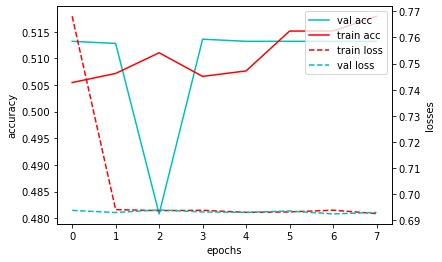

getting accuracies...



Train accuracy: 0.5184567446058447
Validation accuracy: 0.5130537974683544
Holdout accuracy: 0.4912974683544304

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.05_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7738 Acc: 0.4787
Validation Loss: 0.6927 Acc: 0.5132
took 0m 41s

Epoch 1/49
----------
Training Loss: 0.6935 Acc: 0.5156
Validation Loss: 0.6929 Acc: 0.5132
took 0m 22s

Epoch 2/49
----------
Training Loss: 0.6939 Acc: 0.4997
Validation Loss: 0.6936 Acc: 0.5132
took 0m 22s

Epoch 3/49
----------
Training Loss: 0.6932 Acc: 0.5100
Validation Loss: 0.6928 Acc: 0.5132
took 0m 22s

Epoch 4/49
----------
Training Loss: 0.6930 Acc: 0.5139
Validation Loss: 0.6939 Acc: 0.5132
took 0m 22s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6932 Acc: 0.5038
Validation Loss: 0.6929 Acc: 0.5136
took 0m 31s

Epoch 6/49
----------
	 	 	 	 *** best

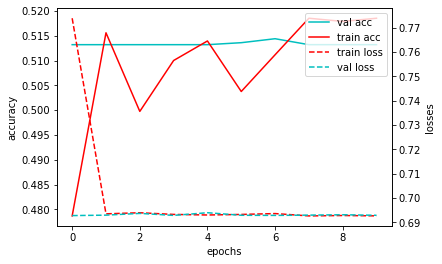

getting accuracies...



Train accuracy: 0.5173020525412126
Validation accuracy: 0.5130537974683544
Holdout accuracy: 0.4924841772151899

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_1759_0.05_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7367 Acc: 0.4850
Validation Loss: 0.6931 Acc: 0.5092
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6945 Acc: 0.4969
Validation Loss: 0.6932 Acc: 0.5016
took 0m 22s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6954 Acc: 0.4878
Validation Loss: 0.6935 Acc: 0.5132
took 0m 30s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6930 Acc: 0.5185
Validation Loss: 0.6939 Acc: 0.5136
took 0m 30s

Epoch 4/49
----------
Training Loss: 0.6944 Acc: 0.4992
Validation Loss: 0.6936 Acc: 0.5132
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6934 Acc: 0.5247
Validation Loss: 0.6933 Acc: 0.5132
took 0m 22s

Epoch 6/49


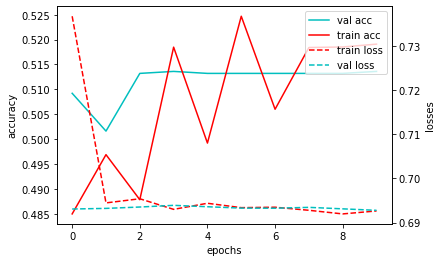

getting accuracies...



Train accuracy: 0.5179068912159313
Validation accuracy: 0.5130537974683544
Holdout accuracy: 0.4912974683544304



In [23]:
batch_size=32
acc_dif=0.04
stop_value=0.005
EPOCHS = 50
weight_decay=0
MRI = 1

LRs=[0.001,0.005,0.01,0.02,0.05]
blocks = ['3conv','4conv','all']

for block in blocks:
    for LR in LRs:
        for SEED in [116560000, 55168461, 18464876]:
            training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                            LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

In [18]:
!gpustat

cuda01                         Sat Mar 25 00:48:01 2023  470.161.03
[0] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |   278 / 11178 MB | martao(135M) martao(135M) gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 84'C,  68 % |  7765 / 11178 MB | martao(7757M) gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 31'C,   0 % |  1741 / 11178 MB | martao(1733M) gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 67'C,   0 % |  7639 / 11178 MB | martao(7631M) gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 35'C,   0 % |   705 / 11178 MB | martao(697M) gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 31'C,   0 % |   705 / 11178 MB | martao(697M) gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |  1223 / 11178 MB | martao(1215M) gdm(4M)


creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.005_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7182 Acc: 0.5194
Validation Loss: 0.7266 Acc: 0.5152
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6908 Acc: 0.5360
Validation Loss: 0.6831 Acc: 0.5640
took 0m 30s

Epoch 2/49
----------
Training Loss: 0.6793 Acc: 0.5649
Validation Loss: 0.6925 Acc: 0.5164
took 0m 21s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6657 Acc: 0.6060
Validation Loss: 0.6744 Acc: 0.5664
took 0m 32s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6485 Acc: 0.6226
Validation Loss: 0.6579 Acc: 0.6008
took 0m 31s

Epoch 5/49
----------
Training Loss: 0.6105 Acc: 0.6713
Validation Loss: 0.7475 Acc: 0.4984
took 0m 22s

Epoch 6/49
----------
Training Loss: 0.5693 Acc: 0.7180
Validation Loss: 1.2022 Acc: 0.5132
took 0m 23s

Epoch 7/49
--

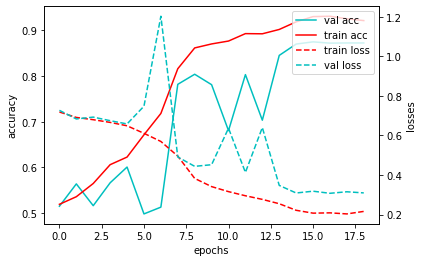

getting accuracies...



Train accuracy: 0.9260284810126582
Validation accuracy: 0.8615506329113924
Holdout accuracy: 0.8659018987341772

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.005_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7228 Acc: 0.5040
Validation Loss: 0.6910 Acc: 0.5312
took 0m 39s

Epoch 1/49
----------
Training Loss: 0.6867 Acc: 0.5574
Validation Loss: 0.7541 Acc: 0.5136
took 0m 21s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6792 Acc: 0.5597
Validation Loss: 0.6821 Acc: 0.5548
took 0m 31s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6682 Acc: 0.5910
Validation Loss: 0.6631 Acc: 0.6024
took 0m 30s

Epoch 4/49
----------
Training Loss: 0.6439 Acc: 0.6365
Validation Loss: 0.6675 Acc: 0.5752
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6120 Acc: 0.6669
Validation Loss: 0.8220 Acc: 0.5084
took 0m 21s

Epoch 6/

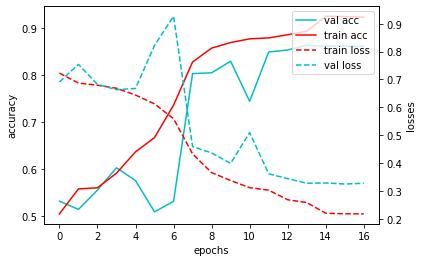

getting accuracies...



Train accuracy: 0.9224683544303798
Validation accuracy: 0.8674841772151899
Holdout accuracy: 0.8674841772151899

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.005_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7281 Acc: 0.5063
Validation Loss: 0.6933 Acc: 0.5288
took 0m 45s

Epoch 1/49
----------
Training Loss: 0.6870 Acc: 0.5463
Validation Loss: 0.6910 Acc: 0.5284
took 0m 20s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6860 Acc: 0.5487
Validation Loss: 0.6801 Acc: 0.5676
took 0m 30s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6696 Acc: 0.5977
Validation Loss: 0.6710 Acc: 0.6012
took 0m 30s

Epoch 4/49
----------
Training Loss: 0.6592 Acc: 0.6072
Validation Loss: 0.6704 Acc: 0.5632
took 0m 20s

Epoch 5/49
----------
Training Loss: 0.6288 Acc: 0.6519
Validation Loss: 0.7649 Acc: 0.5160
took 0m 23s

Epoch 6/

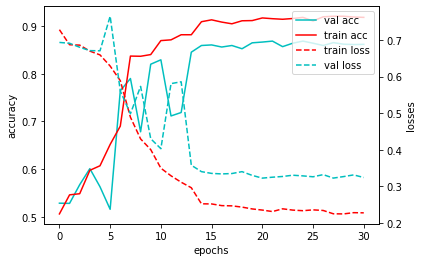

getting accuracies...



Train accuracy: 0.9220727848101266
Validation accuracy: 0.8738132911392406
Holdout accuracy: 0.8651107594936709

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.005_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7190 Acc: 0.5222
Validation Loss: 0.6917 Acc: 0.5220
took 0m 43s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6846 Acc: 0.5649
Validation Loss: 0.6835 Acc: 0.5572
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6768 Acc: 0.5847
Validation Loss: 0.7005 Acc: 0.5288
took 0m 22s

Epoch 3/49
----------
Training Loss: 0.6552 Acc: 0.6064
Validation Loss: 0.7243 Acc: 0.5144
took 0m 22s

Epoch 4/49
----------
Training Loss: 0.6365 Acc: 0.6452
Validation Loss: 1.0075 Acc: 0.4872
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6069 Acc: 0.6729
Validation Loss: 0.5593 Acc: 0.7420
took 0m 22s

Epoch 6/49
----------
Training Loss

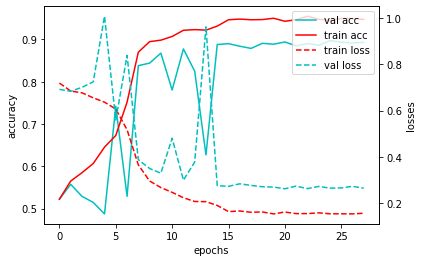

getting accuracies...



Train accuracy: 0.9493670886075949
Validation accuracy: 0.8943829113924051
Holdout accuracy: 0.8928006329113924

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.005_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7173 Acc: 0.5075
Validation Loss: 0.7033 Acc: 0.5136
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6882 Acc: 0.5526
Validation Loss: 0.7032 Acc: 0.5220
took 0m 31s

Epoch 2/49
----------
Training Loss: 0.6831 Acc: 0.5538
Validation Loss: 0.7378 Acc: 0.5140
took 0m 24s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6690 Acc: 0.5934
Validation Loss: 0.6830 Acc: 0.5564
took 0m 31s

Epoch 4/49
----------
Training Loss: 0.6486 Acc: 0.6286
Validation Loss: 0.7513 Acc: 0.5016
took 0m 22s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6212 Acc: 0.6551
Validation Loss: 0.6098 Acc: 0.66

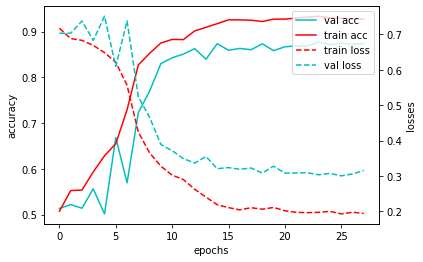

getting accuracies...



Train accuracy: 0.9295886075949367
Validation accuracy: 0.8777689873417721
Holdout accuracy: 0.8757911392405063

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.01_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7109 Acc: 0.5146
Validation Loss: 0.7574 Acc: 0.5132
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6939 Acc: 0.5241
Validation Loss: 0.6866 Acc: 0.5536
took 0m 29s

Epoch 2/49
----------
Training Loss: 0.6831 Acc: 0.5550
Validation Loss: 0.6928 Acc: 0.5060
took 0m 21s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6684 Acc: 0.5811
Validation Loss: 0.6671 Acc: 0.5628
took 0m 30s

Epoch 4/49
----------
Training Loss: 0.6391 Acc: 0.6353
Validation Loss: 0.6632 Acc: 0.5608
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.5569 Acc: 0.7251
Validation Loss: 0.6955 Acc: 0.5076
took 0m 20s

Epoch 6/

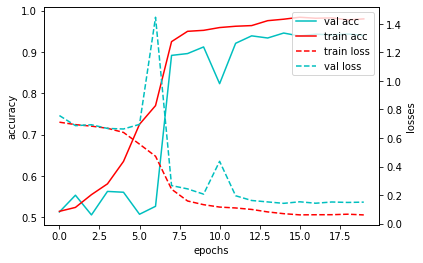

getting accuracies...



Train accuracy: 0.9802215189873418
Validation accuracy: 0.9418512658227848
Holdout accuracy: 0.9386867088607594

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.01_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7167 Acc: 0.4988
Validation Loss: 0.6902 Acc: 0.5352
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6883 Acc: 0.5368
Validation Loss: 0.7694 Acc: 0.5132
took 0m 23s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6843 Acc: 0.5510
Validation Loss: 0.6802 Acc: 0.5808
took 0m 30s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6711 Acc: 0.5854
Validation Loss: 0.6575 Acc: 0.6224
took 0m 29s

Epoch 4/49
----------
Training Loss: 0.6389 Acc: 0.6404
Validation Loss: 0.7624 Acc: 0.5148
took 0m 20s

Epoch 5/49
----------
Training Loss: 0.5918 Acc: 0.7021
Validation Loss: 0.6385 Acc: 0.5916
took 0m 21s

Epoch 6/4

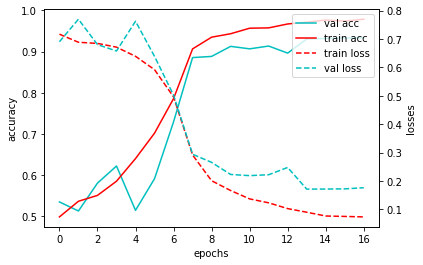

getting accuracies...



Train accuracy: 0.9794303797468354
Validation accuracy: 0.928006329113924
Holdout accuracy: 0.9359177215189873

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.01_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7187 Acc: 0.5047
Validation Loss: 0.6927 Acc: 0.5112
took 0m 36s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6910 Acc: 0.5324
Validation Loss: 0.6930 Acc: 0.5264
took 0m 29s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6908 Acc: 0.5233
Validation Loss: 0.6863 Acc: 0.5332
took 0m 30s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6799 Acc: 0.5649
Validation Loss: 0.6786 Acc: 0.5896
took 0m 32s

Epoch 4/49
----------
Training Loss: 0.6667 Acc: 0.5938
Validation Loss: 0.6672 Acc: 0.5652
took 0m 20s

Epoch 5/49
----------
Training Loss: 0.6231 Acc: 0.6578
Validation Loss: 0.8136 Acc: 0.5

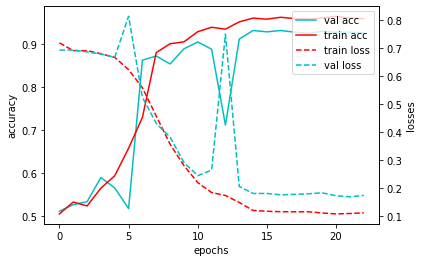

getting accuracies...



Train accuracy: 0.9620253164556962
Validation accuracy: 0.928006329113924
Holdout accuracy: 0.9355221518987342

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.01_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7154 Acc: 0.5040
Validation Loss: 0.6943 Acc: 0.5100
took 0m 41s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6875 Acc: 0.5514
Validation Loss: 0.6872 Acc: 0.5408
took 0m 30s

Epoch 2/49
----------
Training Loss: 0.6820 Acc: 0.5562
Validation Loss: 0.7135 Acc: 0.5140
took 0m 20s

Epoch 3/49
----------
Training Loss: 0.6657 Acc: 0.5906
Validation Loss: 0.8166 Acc: 0.4904
took 0m 20s

Epoch 4/49
----------
Training Loss: 0.6414 Acc: 0.6400
Validation Loss: 1.0557 Acc: 0.4864
took 0m 22s

Epoch 5/49
----------
Training Loss: 0.5753 Acc: 0.7077
Validation Loss: 0.7342 Acc: 0.5444
took 0m 22s

Epoch 6/49
----------
Training Loss: 

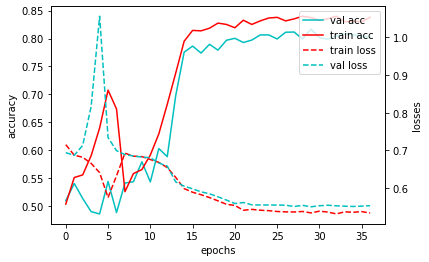

getting accuracies...



Train accuracy: 0.8445411392405063
Validation accuracy: 0.8014240506329114
Holdout accuracy: 0.8113132911392406

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.01_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7141 Acc: 0.5036
Validation Loss: 0.7078 Acc: 0.5128
took 0m 38s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6918 Acc: 0.5475
Validation Loss: 0.7007 Acc: 0.5228
took 0m 32s

Epoch 2/49
----------
Training Loss: 0.6864 Acc: 0.5487
Validation Loss: 0.7286 Acc: 0.5132
took 0m 22s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6747 Acc: 0.5850
Validation Loss: 0.6765 Acc: 0.5608
took 0m 30s

Epoch 4/49
----------
Training Loss: 0.6514 Acc: 0.6262
Validation Loss: 0.7178 Acc: 0.5140
took 0m 20s

Epoch 5/49
----------
Training Loss: 0.6115 Acc: 0.6741
Validation Loss: 0.6617 Acc: 0.5516
took 0m 22s

Epoch 6/49
-

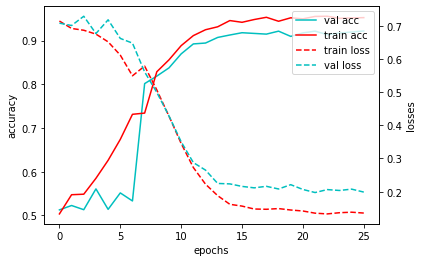

getting accuracies...



Train accuracy: 0.9533227848101266
Validation accuracy: 0.9236550632911392
Holdout accuracy: 0.9276107594936709

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7114 Acc: 0.5063
Validation Loss: 0.7365 Acc: 0.5132
took 0m 46s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6946 Acc: 0.5067
Validation Loss: 0.6892 Acc: 0.5332
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6892 Acc: 0.5348
Validation Loss: 0.6935 Acc: 0.4952
took 0m 21s

Epoch 3/49
----------
Training Loss: 0.6800 Acc: 0.5621
Validation Loss: 0.6754 Acc: 0.5288
took 0m 22s

Epoch 4/49
----------
Training Loss: 0.6534 Acc: 0.6258
Validation Loss: 0.6633 Acc: 0.5444
took 0m 22s

Epoch 5/49
----------
Training Loss: 0.6777 Acc: 0.5882
Validation Loss: 0.6866 Acc: 0.4876
took 0m 22s

Epoch 6/49
----------
Training Loss

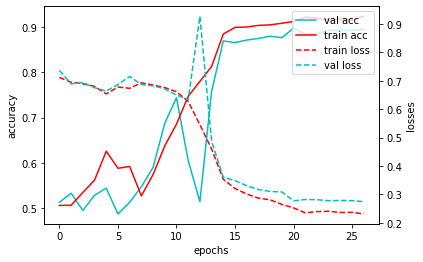

getting accuracies...



Train accuracy: 0.9169303797468354
Validation accuracy: 0.8884493670886076
Holdout accuracy: 0.901503164556962

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7153 Acc: 0.4960
Validation Loss: 0.6904 Acc: 0.5388
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6923 Acc: 0.5293
Validation Loss: 0.7668 Acc: 0.5132
took 0m 21s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6894 Acc: 0.5320
Validation Loss: 0.6860 Acc: 0.5680
took 0m 31s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6815 Acc: 0.5637
Validation Loss: 0.6688 Acc: 0.6012
took 0m 30s

Epoch 4/49
----------
Training Loss: 0.6663 Acc: 0.6195
Validation Loss: 0.6868 Acc: 0.5416
took 0m 22s

Epoch 5/49
----------
Training Loss: 0.6179 Acc: 0.6491
Validation Loss: 0.5189 Acc: 0.7368
took 0m 22s

Epoch 6/49

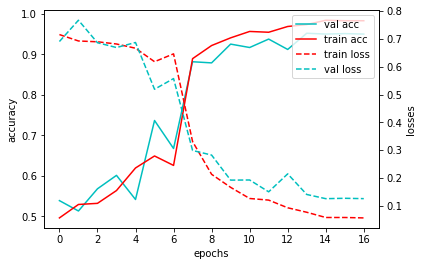

getting accuracies...



Train accuracy: 0.9778481012658228
Validation accuracy: 0.9454113924050633
Holdout accuracy: 0.9406645569620253

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7130 Acc: 0.5095
Validation Loss: 0.6943 Acc: 0.4972
took 0m 39s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6930 Acc: 0.5134
Validation Loss: 0.6935 Acc: 0.5052
took 0m 30s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6916 Acc: 0.5166
Validation Loss: 0.6868 Acc: 0.5372
took 0m 29s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6803 Acc: 0.5732
Validation Loss: 0.6770 Acc: 0.6112
took 0m 29s

Epoch 4/49
----------
Training Loss: 0.6593 Acc: 0.6127
Validation Loss: 0.6633 Acc: 0.5224
took 0m 20s

Epoch 5/49
----------
Training Loss: 0.5876 Acc: 0.6883
Validation Loss: 0.8895 Acc: 0.

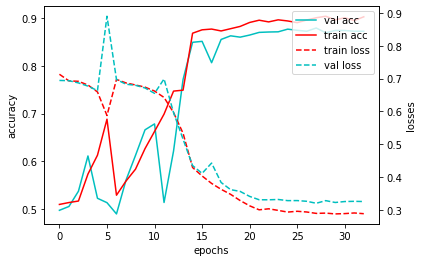

getting accuracies...



Train accuracy: 0.8924050632911392
Validation accuracy: 0.8809335443037974
Holdout accuracy: 0.8829113924050633

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7181 Acc: 0.5087
Validation Loss: 0.6961 Acc: 0.4920
took 0m 37s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6916 Acc: 0.5245
Validation Loss: 0.6911 Acc: 0.5220
took 0m 30s

Epoch 2/49
----------
Training Loss: 0.6871 Acc: 0.5487
Validation Loss: 0.6975 Acc: 0.5132
took 0m 21s

Epoch 3/49
----------
Training Loss: 0.6671 Acc: 0.5882
Validation Loss: 0.8995 Acc: 0.4868
took 0m 21s

Epoch 4/49
----------
Training Loss: 0.6922 Acc: 0.5368
Validation Loss: 0.7321 Acc: 0.4868
took 0m 21s

Epoch 5/49
----------
Training Loss: 0.6416 Acc: 0.6286
Validation Loss: 0.6127 Acc: 0.7196
took 0m 21s

Epoch 6/49
----------
Training Loss:

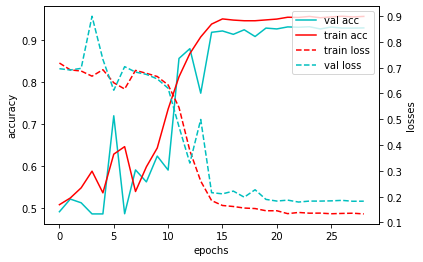

getting accuracies...



Train accuracy: 0.9560917721518988
Validation accuracy: 0.9260284810126582
Holdout accuracy: 0.9406645569620253

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7116 Acc: 0.5044
Validation Loss: 0.7133 Acc: 0.5132
took 0m 43s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6928 Acc: 0.5297
Validation Loss: 0.7075 Acc: 0.5144
took 0m 32s

Epoch 2/49
----------
Training Loss: 0.6902 Acc: 0.5431
Validation Loss: 0.7282 Acc: 0.5132
took 0m 20s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6761 Acc: 0.5854
Validation Loss: 0.6788 Acc: 0.5512
took 0m 33s

Epoch 4/49
----------
Training Loss: 0.6618 Acc: 0.6183
Validation Loss: 0.7276 Acc: 0.5064
took 0m 21s

Epoch 5/49
----------
Training Loss: 0.6875 Acc: 0.5542
Validation Loss: 0.6945 Acc: 0.5132
took 0m 20s

Epoch 6/49
-

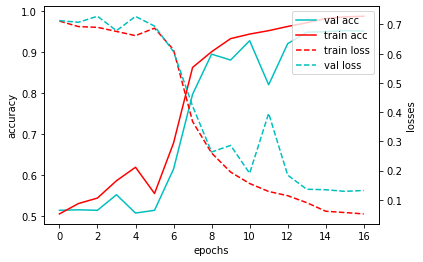

getting accuracies...



Train accuracy: 0.9865506329113924
Validation accuracy: 0.9553006329113924
Holdout accuracy: 0.9489715189873418

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.03_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7121 Acc: 0.5202
Validation Loss: 0.7425 Acc: 0.5132
took 0m 36s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6953 Acc: 0.5083
Validation Loss: 0.6916 Acc: 0.5208
took 0m 29s

Epoch 2/49
----------
Training Loss: 0.6918 Acc: 0.5202
Validation Loss: 0.6952 Acc: 0.4876
took 0m 21s

Epoch 3/49
----------
Training Loss: 0.6878 Acc: 0.5348
Validation Loss: 0.6915 Acc: 0.5128
took 0m 21s

Epoch 4/49
----------
Training Loss: 0.6769 Acc: 0.5803
Validation Loss: 0.6965 Acc: 0.4976
took 0m 21s

Epoch 5/49
----------
Training Loss: 0.6795 Acc: 0.5898
Validation Loss: 0.7289 Acc: 0.4868
took 0m 22s

Epoch 6/49
----------
Training Loss

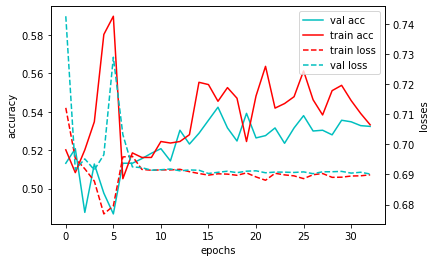

getting accuracies...



Train accuracy: 0.5363924050632911
Validation accuracy: 0.5268987341772152
Holdout accuracy: 0.5268987341772152

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.03_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7135 Acc: 0.5000
Validation Loss: 0.6914 Acc: 0.5316
took 0m 41s

Epoch 1/49
----------
Training Loss: 0.6907 Acc: 0.5305
Validation Loss: 0.8168 Acc: 0.5132
took 0m 22s

Epoch 2/49
----------
Training Loss: 0.6837 Acc: 0.5629
Validation Loss: 0.6669 Acc: 0.6828
took 0m 24s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6841 Acc: 0.5546
Validation Loss: 0.6650 Acc: 0.5424
took 0m 31s

Epoch 4/49
----------
Training Loss: 0.6274 Acc: 0.6511
Validation Loss: 0.6982 Acc: 0.5132
took 0m 21s

Epoch 5/49
----------
Training Loss: 0.6667 Acc: 0.5870
Validation Loss: 0.6596 Acc: 0.5140
took 0m 22s

Epoch 6/49
----------
Training Loss:

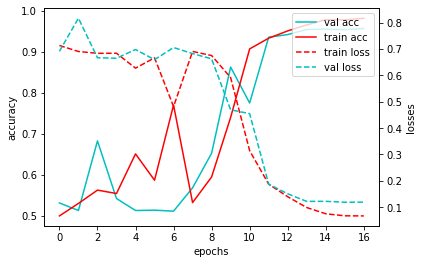

getting accuracies...



Train accuracy: 0.9818037974683544
Validation accuracy: 0.9553006329113924
Holdout accuracy: 0.9568829113924051

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.03_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7156 Acc: 0.5044
Validation Loss: 0.6950 Acc: 0.4860
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6940 Acc: 0.5131
Validation Loss: 0.6941 Acc: 0.4944
took 0m 31s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6942 Acc: 0.5008
Validation Loss: 0.6919 Acc: 0.5184
took 0m 30s

Epoch 3/49
----------
Training Loss: 0.6911 Acc: 0.5356
Validation Loss: 0.6926 Acc: 0.4964
took 0m 20s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6879 Acc: 0.5340
Validation Loss: 0.6882 Acc: 0.5212
took 0m 29s

Epoch 5/49
----------
Training Loss: 0.6730 Acc: 0.5736
Validation Loss: 0.9755 Acc: 0.

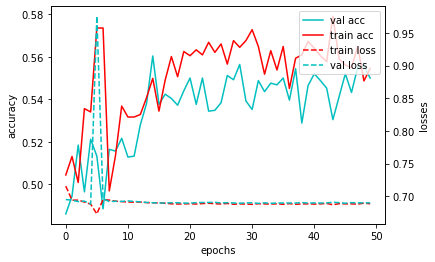

getting accuracies...



Train accuracy: 0.5652689873417721
Validation accuracy: 0.5423259493670886
Holdout accuracy: 0.5387658227848101

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.03_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7264 Acc: 0.4941
Validation Loss: 0.6953 Acc: 0.4876
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6934 Acc: 0.5103
Validation Loss: 0.6942 Acc: 0.4996
took 0m 30s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6933 Acc: 0.5119
Validation Loss: 0.6924 Acc: 0.5148
took 0m 30s

Epoch 3/49
----------
Training Loss: 0.6906 Acc: 0.5253
Validation Loss: 0.7040 Acc: 0.4868
took 0m 22s

Epoch 4/49
----------
Training Loss: 0.6920 Acc: 0.5182
Validation Loss: 0.6982 Acc: 0.4876
took 0m 21s

Epoch 5/49
----------
Training Loss: 0.6895 Acc: 0.5384
Validation Loss: 0.6769 Acc: 0.6296
took 0m 21s

Epoch 6/4

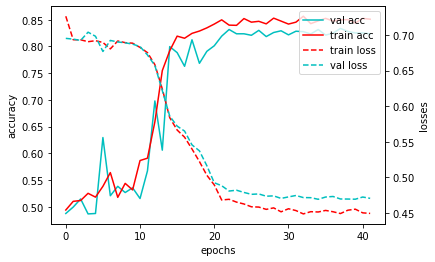

getting accuracies...



Train accuracy: 0.850870253164557
Validation accuracy: 0.8227848101265823
Holdout accuracy: 0.8433544303797469

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.03_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7131 Acc: 0.5115
Validation Loss: 0.7084 Acc: 0.5132
took 0m 44s

Epoch 1/49
----------
Training Loss: 0.6937 Acc: 0.5174
Validation Loss: 0.7045 Acc: 0.5132
took 0m 22s

Epoch 2/49
----------
Training Loss: 0.6935 Acc: 0.5218
Validation Loss: 0.7042 Acc: 0.5132
took 0m 24s

Epoch 3/49
----------
	 	 	 	 *** best model ***
out
Training Loss: 0.6894 Acc: 0.5312
Validation Loss: 0.6928 Acc: 0.5164
took 0m 31s

Training complete in 2m 0s
Best val Acc: 0.516400



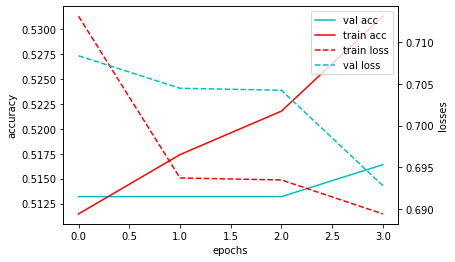

getting accuracies...



Train accuracy: 0.5174050632911392
Validation accuracy: 0.5150316455696202
Holdout accuracy: 0.495253164556962

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.04_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7138 Acc: 0.5044
Validation Loss: 0.7190 Acc: 0.5132
took 0m 43s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6947 Acc: 0.5146
Validation Loss: 0.6932 Acc: 0.5136
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6932 Acc: 0.5055
Validation Loss: 0.6957 Acc: 0.4868
took 0m 23s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6929 Acc: 0.5166
Validation Loss: 0.6915 Acc: 0.5352
took 0m 32s

Epoch 4/49
----------
Training Loss: 0.6904 Acc: 0.5265
Validation Loss: 0.6958 Acc: 0.4860
took 0m 22s

Epoch 5/49
----------
Training Loss: 0.6870 Acc: 0.5526
Validation Loss: 0.7353 Acc: 0.4868
took 0m 23s

Epoch 6/4

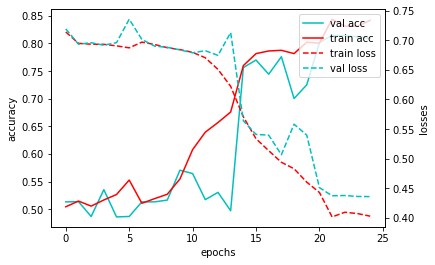

getting accuracies...



Train accuracy: 0.834256329113924
Validation accuracy: 0.8117088607594937
Holdout accuracy: 0.8330696202531646

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.04_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7129 Acc: 0.4992
Validation Loss: 0.6919 Acc: 0.5172
took 0m 42s

Epoch 1/49
----------
Training Loss: 0.6925 Acc: 0.5225
Validation Loss: 0.7470 Acc: 0.5132
took 0m 21s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6913 Acc: 0.5285
Validation Loss: 0.6884 Acc: 0.5700
took 0m 34s

Epoch 3/49
----------
Training Loss: 0.6786 Acc: 0.5653
Validation Loss: 0.6725 Acc: 0.5140
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6661 Acc: 0.5981
Validation Loss: 0.6952 Acc: 0.5124
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6967 Acc: 0.5012
Validation Loss: 0.6906 Acc: 0.5108
took 0m 22s

Epoch 6/49
----------
Training Loss: 

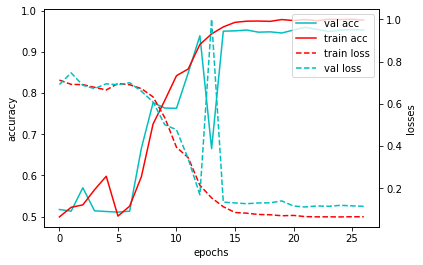

getting accuracies...



Train accuracy: 0.9742879746835443
Validation accuracy: 0.9560917721518988
Holdout accuracy: 0.9576740506329114

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.04_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7183 Acc: 0.4984
Validation Loss: 0.6945 Acc: 0.4872
took 0m 39s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6939 Acc: 0.5111
Validation Loss: 0.6937 Acc: 0.4932
took 0m 30s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6942 Acc: 0.5020
Validation Loss: 0.6920 Acc: 0.5220
took 0m 31s

Epoch 3/49
----------
Training Loss: 0.6926 Acc: 0.5174
Validation Loss: 0.6923 Acc: 0.5060
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6902 Acc: 0.5301
Validation Loss: 0.6906 Acc: 0.5136
took 0m 21s

Epoch 5/49
----------
Training Loss: 0.6847 Acc: 0.5581
Validation Loss: 0.7311 Acc: 0.5132
took 0m 21s

Epoch 6/4

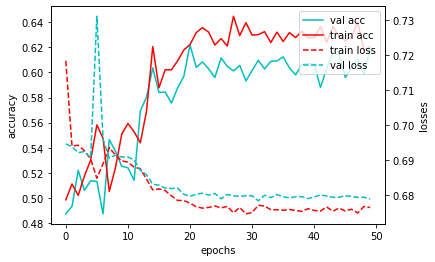

getting accuracies...



Train accuracy: 0.6360759493670886
Validation accuracy: 0.6040348101265823
Holdout accuracy: 0.6111550632911392

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.04_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7344 Acc: 0.4778
Validation Loss: 0.6951 Acc: 0.4876
took 0m 39s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6937 Acc: 0.5107
Validation Loss: 0.6940 Acc: 0.4892
took 0m 32s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6938 Acc: 0.5016
Validation Loss: 0.6942 Acc: 0.5132
took 0m 30s

Epoch 3/49
----------
Training Loss: 0.6928 Acc: 0.5103
Validation Loss: 0.6962 Acc: 0.4868
took 0m 22s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6948 Acc: 0.4953
Validation Loss: 0.6917 Acc: 0.5408
took 0m 32s

Epoch 5/49
----------
Training Loss: 0.6927 Acc: 0.5222
Validation Loss: 0.6941 Acc: 0.

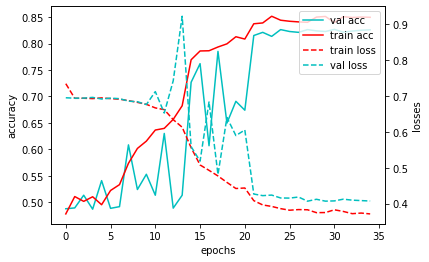

getting accuracies...



Train accuracy: 0.8548259493670886
Validation accuracy: 0.8255537974683544
Holdout accuracy: 0.8318829113924051

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.04_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7150 Acc: 0.5146
Validation Loss: 0.7000 Acc: 0.5132
took 0m 42s

Epoch 1/49
----------
Training Loss: 0.6937 Acc: 0.5044
Validation Loss: 0.7005 Acc: 0.5132
took 0m 22s

Epoch 2/49
----------
Training Loss: 0.6935 Acc: 0.5154
Validation Loss: 0.7009 Acc: 0.5132
took 0m 22s

Epoch 3/49
----------
Training Loss: 0.6916 Acc: 0.5170
Validation Loss: 0.6933 Acc: 0.5132
took 0m 22s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6904 Acc: 0.5328
Validation Loss: 0.6861 Acc: 0.5632
took 0m 31s

Epoch 5/49
----------
Training Loss: 0.6854 Acc: 0.5534
Validation Loss: 0.7031 Acc: 0.5132
took 0m 22s

Epoch 6/49
----------
	 	 	 	 *** best 

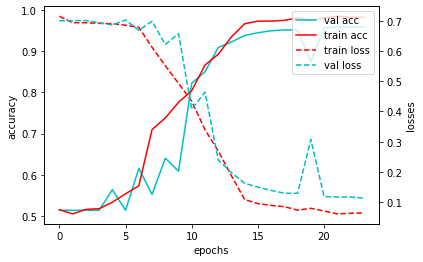

getting accuracies...



Train accuracy: 0.9881329113924051
Validation accuracy: 0.9564873417721519
Holdout accuracy: 0.9647943037974683

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.005_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7155 Acc: 0.5198
Validation Loss: 0.7189 Acc: 0.5136
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6919 Acc: 0.5273
Validation Loss: 0.6863 Acc: 0.5472
took 0m 34s

Epoch 2/49
----------
Training Loss: 0.6843 Acc: 0.5542
Validation Loss: 0.6900 Acc: 0.5268
took 0m 24s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6720 Acc: 0.5815
Validation Loss: 0.6791 Acc: 0.5576
took 0m 33s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6575 Acc: 0.6171
Validation Loss: 0.6619 Acc: 0.5928
took 0m 32s

Epoch 5/49
----------
Training Loss: 0.6270 Acc: 0.6519
Validation Loss: 0.7313 Acc: 

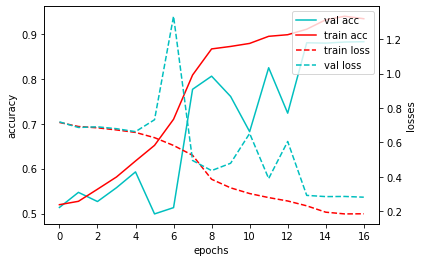

getting accuracies...



Train accuracy: 0.9347310126582279
Validation accuracy: 0.8781645569620253
Holdout accuracy: 0.8825158227848101

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.005_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7214 Acc: 0.5032
Validation Loss: 0.6904 Acc: 0.5328
took 0m 41s

Epoch 1/49
----------
Training Loss: 0.6880 Acc: 0.5443
Validation Loss: 0.7310 Acc: 0.5140
took 0m 24s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6810 Acc: 0.5542
Validation Loss: 0.6819 Acc: 0.5572
took 0m 33s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6715 Acc: 0.5910
Validation Loss: 0.6658 Acc: 0.5948
took 0m 33s

Epoch 4/49
----------
Training Loss: 0.6491 Acc: 0.6282
Validation Loss: 0.6716 Acc: 0.5644
took 0m 24s

Epoch 5/49
----------
Training Loss: 0.6170 Acc: 0.6535
Validation Loss: 0.8074 Acc: 0.5216
took 0m 24s

Epoch 6/

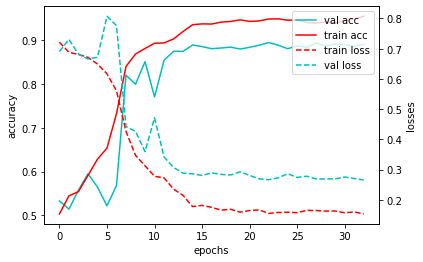

getting accuracies...



Train accuracy: 0.939873417721519
Validation accuracy: 0.8805379746835443
Holdout accuracy: 0.8975474683544303

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.005_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7267 Acc: 0.5020
Validation Loss: 0.6933 Acc: 0.5196
took 0m 45s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6880 Acc: 0.5396
Validation Loss: 0.6892 Acc: 0.5380
took 0m 33s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6865 Acc: 0.5510
Validation Loss: 0.6821 Acc: 0.5688
took 0m 32s

Epoch 3/49
----------
Training Loss: 0.6741 Acc: 0.5862
Validation Loss: 0.6783 Acc: 0.5676
took 0m 24s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6668 Acc: 0.5870
Validation Loss: 0.6714 Acc: 0.5776
took 0m 33s

Epoch 5/49
----------
Training Loss: 0.6430 Acc: 0.6384
Validation Loss: 0.7821 Acc: 0.

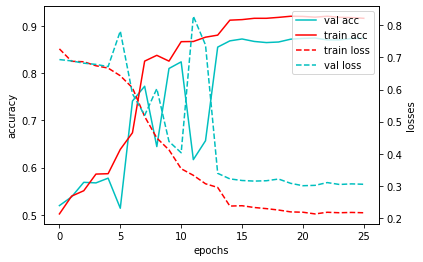

getting accuracies...



Train accuracy: 0.9137658227848101
Validation accuracy: 0.8809335443037974
Holdout accuracy: 0.8742088607594937

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.005_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7175 Acc: 0.5154
Validation Loss: 0.6917 Acc: 0.5180
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6858 Acc: 0.5487
Validation Loss: 0.6865 Acc: 0.5456
took 0m 32s

Epoch 2/49
----------
Training Loss: 0.6778 Acc: 0.5633
Validation Loss: 0.6937 Acc: 0.5376
took 0m 23s

Epoch 3/49
----------
Training Loss: 0.6601 Acc: 0.6036
Validation Loss: 0.7100 Acc: 0.5320
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6451 Acc: 0.6210
Validation Loss: 0.9666 Acc: 0.4868
took 0m 23s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6124 Acc: 0.6634
Validation Loss: 0.5838 Acc: 0.6904
took 0m 32s

Epoch 6/

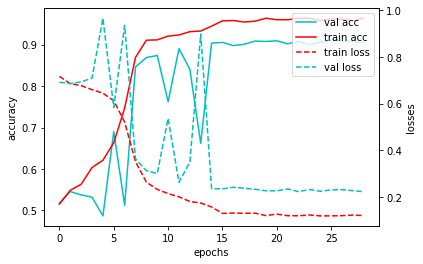

getting accuracies...



Train accuracy: 0.961629746835443
Validation accuracy: 0.903876582278481
Holdout accuracy: 0.9117879746835443

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.005_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7169 Acc: 0.4980
Validation Loss: 0.7004 Acc: 0.5168
took 0m 41s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6896 Acc: 0.5427
Validation Loss: 0.6993 Acc: 0.5248
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6855 Acc: 0.5498
Validation Loss: 0.7224 Acc: 0.5140
took 0m 23s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6735 Acc: 0.5886
Validation Loss: 0.6921 Acc: 0.5444
took 0m 33s

Epoch 4/49
----------
Training Loss: 0.6604 Acc: 0.6052
Validation Loss: 0.6845 Acc: 0.5448
took 0m 23s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6354 Acc: 0.6392
Validation Loss: 0.6434 Acc: 0.5928

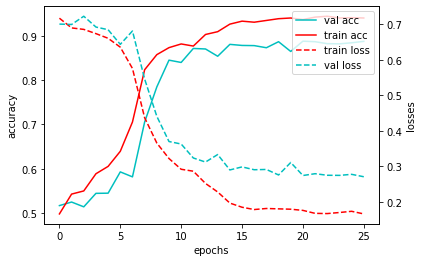

getting accuracies...



Train accuracy: 0.9371044303797469
Validation accuracy: 0.8904272151898734
Holdout accuracy: 0.8880537974683544

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.01_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7110 Acc: 0.5123
Validation Loss: 0.7214 Acc: 0.5136
took 0m 43s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6937 Acc: 0.5301
Validation Loss: 0.6866 Acc: 0.5488
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6856 Acc: 0.5463
Validation Loss: 0.6907 Acc: 0.5144
took 0m 23s

Epoch 3/49
----------
Training Loss: 0.6739 Acc: 0.5744
Validation Loss: 0.6778 Acc: 0.5440
took 0m 24s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6511 Acc: 0.6191
Validation Loss: 0.6404 Acc: 0.6224
took 0m 32s

Epoch 5/49
----------
Training Loss: 0.6114 Acc: 0.6903
Validation Loss: 0.8952 Acc: 0.4868
took 0m 24s

Epoch 6/

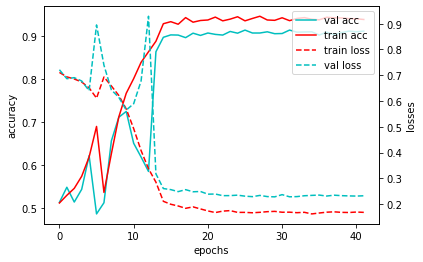

getting accuracies...



Train accuracy: 0.939873417721519
Validation accuracy: 0.903876582278481
Holdout accuracy: 0.9106012658227848

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.01_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7155 Acc: 0.4921
Validation Loss: 0.6898 Acc: 0.5444
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6892 Acc: 0.5344
Validation Loss: 0.7608 Acc: 0.5132
took 0m 23s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6845 Acc: 0.5538
Validation Loss: 0.6820 Acc: 0.5724
took 0m 32s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6749 Acc: 0.5839
Validation Loss: 0.6671 Acc: 0.6052
took 0m 32s

Epoch 4/49
----------
Training Loss: 0.6562 Acc: 0.6135
Validation Loss: 0.6632 Acc: 0.5952
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6095 Acc: 0.6626
Validation Loss: 1.3945 Acc: 0.4988
took 0m 23s

Epoch 6/49


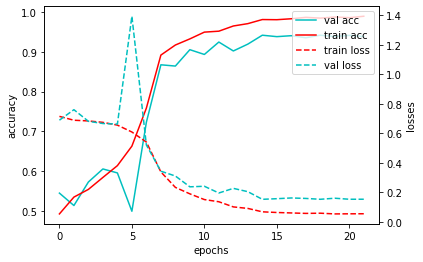

getting accuracies...



Train accuracy: 0.9853639240506329
Validation accuracy: 0.9414556962025317
Holdout accuracy: 0.944620253164557

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.01_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7175 Acc: 0.4956
Validation Loss: 0.6931 Acc: 0.5128
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6922 Acc: 0.5312
Validation Loss: 0.6927 Acc: 0.5204
took 0m 34s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6917 Acc: 0.5312
Validation Loss: 0.6878 Acc: 0.5360
took 0m 33s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6835 Acc: 0.5625
Validation Loss: 0.6872 Acc: 0.5456
took 0m 33s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6743 Acc: 0.5736
Validation Loss: 0.6757 Acc: 0.5592
took 0m 32s

Epoch 5/49
----------
Training Loss: 0.6467 Acc: 0.6333
Valid

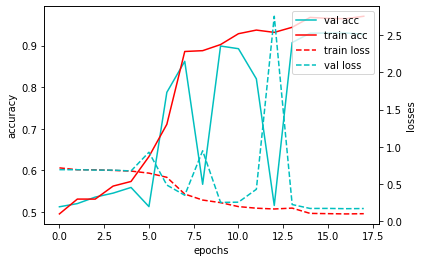

getting accuracies...



Train accuracy: 0.96875
Validation accuracy: 0.9343354430379747
Holdout accuracy: 0.9319620253164557

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.01_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7142 Acc: 0.5040
Validation Loss: 0.6927 Acc: 0.5132
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6882 Acc: 0.5546
Validation Loss: 0.6854 Acc: 0.5472
took 0m 32s

Epoch 2/49
----------
Training Loss: 0.6829 Acc: 0.5649
Validation Loss: 0.7062 Acc: 0.5232
took 0m 24s

Epoch 3/49
----------
Training Loss: 0.6671 Acc: 0.5965
Validation Loss: 0.8188 Acc: 0.4932
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6423 Acc: 0.6373
Validation Loss: 1.4191 Acc: 0.4864
took 0m 23s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6150 Acc: 0.6899
Validation Loss: 0.5729 Acc: 0.6760
took 0m 35s

Epoch 6/49
---------

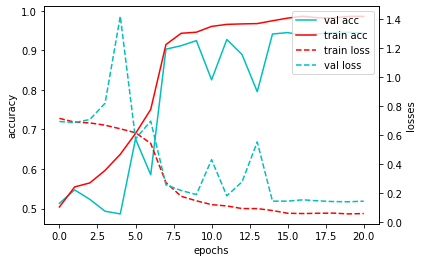

getting accuracies...



Train accuracy: 0.9861550632911392
Validation accuracy: 0.9430379746835443
Holdout accuracy: 0.9493670886075949

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.01_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7124 Acc: 0.4949
Validation Loss: 0.7023 Acc: 0.5140
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6908 Acc: 0.5392
Validation Loss: 0.7032 Acc: 0.5200
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6883 Acc: 0.5392
Validation Loss: 0.7211 Acc: 0.5140
took 0m 25s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6768 Acc: 0.5779
Validation Loss: 0.6883 Acc: 0.5536
took 0m 34s

Epoch 4/49
----------
Training Loss: 0.6622 Acc: 0.6143
Validation Loss: 0.7243 Acc: 0.5116
took 0m 24s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6280 Acc: 0.6456
Validation Loss: 0.6408 Acc: 0.586

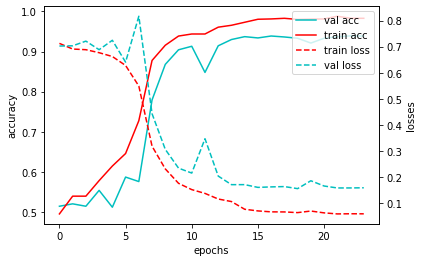

getting accuracies...



Train accuracy: 0.9869462025316456
Validation accuracy: 0.939873417721519
Holdout accuracy: 0.9410601265822784

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7091 Acc: 0.5091
Validation Loss: 0.7407 Acc: 0.5132
took 0m 41s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6957 Acc: 0.5040
Validation Loss: 0.6902 Acc: 0.5316
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6916 Acc: 0.5218
Validation Loss: 0.6941 Acc: 0.4952
took 0m 24s

Epoch 3/49
----------
Training Loss: 0.6866 Acc: 0.5431
Validation Loss: 0.6868 Acc: 0.5168
took 0m 25s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6751 Acc: 0.5961
Validation Loss: 0.6652 Acc: 0.5976
took 0m 33s

Epoch 5/49
----------
Training Loss: 0.6456 Acc: 0.6392
Validation Loss: 0.7113 Acc: 0.4868
took 0m 24s

Epoch 6/4

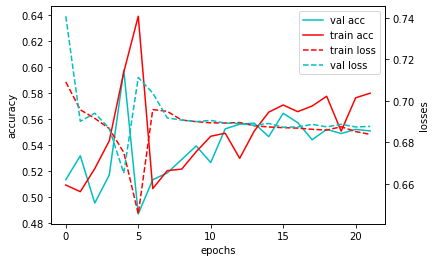

getting accuracies...



Train accuracy: 0.617879746835443
Validation accuracy: 0.6052215189873418
Holdout accuracy: 0.6190664556962026

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7132 Acc: 0.4968
Validation Loss: 0.6915 Acc: 0.5276
took 0m 41s

Epoch 1/49
----------
Training Loss: 0.6915 Acc: 0.5293
Validation Loss: 0.7519 Acc: 0.5132
took 0m 23s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6915 Acc: 0.5233
Validation Loss: 0.6901 Acc: 0.5456
took 0m 33s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6872 Acc: 0.5403
Validation Loss: 0.6804 Acc: 0.5624
took 0m 32s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6767 Acc: 0.5633
Validation Loss: 0.6755 Acc: 0.5748
took 0m 32s

Epoch 5/49
----------
Training Loss: 0.6469 Acc: 0.6171
Validation Loss: 0.7341 Acc: 0.5

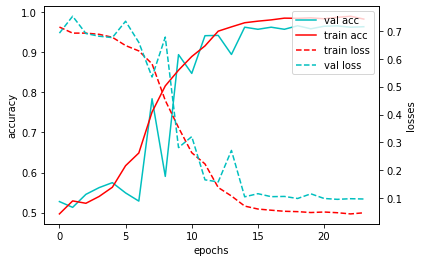

getting accuracies...



Train accuracy: 0.9869462025316456
Validation accuracy: 0.9628164556962026
Holdout accuracy: 0.9612341772151899

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7137 Acc: 0.5036
Validation Loss: 0.6944 Acc: 0.4912
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6941 Acc: 0.5099
Validation Loss: 0.6937 Acc: 0.5040
took 0m 34s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6937 Acc: 0.5028
Validation Loss: 0.6914 Acc: 0.5304
took 0m 33s

Epoch 3/49
----------
Training Loss: 0.6902 Acc: 0.5273
Validation Loss: 0.6941 Acc: 0.5056
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6874 Acc: 0.5447
Validation Loss: 0.6903 Acc: 0.5192
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6804 Acc: 0.5672
Validation Loss: 0.7182 Acc: 0.5132
took 0m 24s

Epoch 6/4

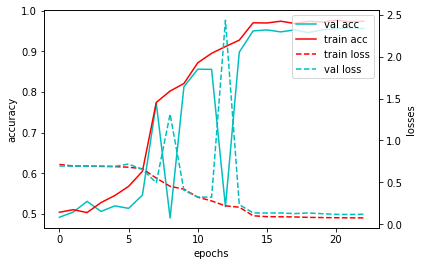

getting accuracies...



Train accuracy: 0.9750791139240507
Validation accuracy: 0.9529272151898734
Holdout accuracy: 0.9572784810126582

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7208 Acc: 0.4850
Validation Loss: 0.6955 Acc: 0.4912
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6923 Acc: 0.5237
Validation Loss: 0.6934 Acc: 0.5088
took 0m 33s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6919 Acc: 0.5237
Validation Loss: 0.6911 Acc: 0.5188
took 0m 33s

Epoch 3/49
----------
Training Loss: 0.6850 Acc: 0.5479
Validation Loss: 0.7478 Acc: 0.4872
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6857 Acc: 0.5487
Validation Loss: 0.7650 Acc: 0.4888
took 0m 24s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6833 Acc: 0.5601
Validation Loss: 0.6701 Acc: 0.

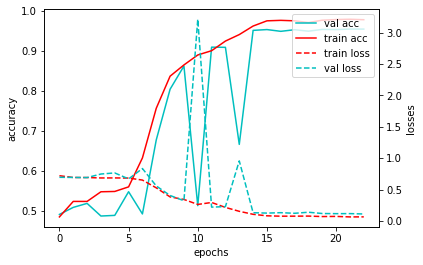

getting accuracies...



Train accuracy: 0.975870253164557
Validation accuracy: 0.9588607594936709
Holdout accuracy: 0.959256329113924

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7113 Acc: 0.5040
Validation Loss: 0.7089 Acc: 0.5140
took 0m 41s

Epoch 1/49
----------
Training Loss: 0.6932 Acc: 0.5142
Validation Loss: 0.7082 Acc: 0.5132
took 0m 24s

Epoch 2/49
----------
Training Loss: 0.6916 Acc: 0.5396
Validation Loss: 0.7155 Acc: 0.5132
took 0m 25s

Epoch 3/49
----------
	 	 	 	 *** best model ***
out
Training Loss: 0.6851 Acc: 0.5491
Validation Loss: 0.6972 Acc: 0.5168
took 0m 35s

Training complete in 2m 4s
Best val Acc: 0.516800



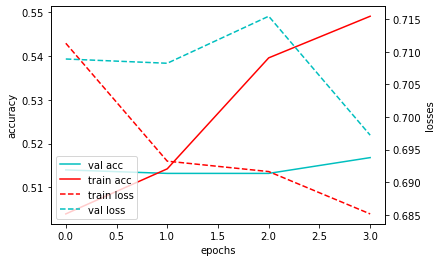

getting accuracies...



Train accuracy: 0.5189873417721519
Validation accuracy: 0.5174050632911392
Holdout accuracy: 0.49723101265822783

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7102 Acc: 0.5079
Validation Loss: 0.7150 Acc: 0.5132
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6951 Acc: 0.5138
Validation Loss: 0.6932 Acc: 0.5112
took 0m 23s

Epoch 2/49
----------
Training Loss: 0.6930 Acc: 0.5047
Validation Loss: 0.6971 Acc: 0.4868
took 0m 23s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6918 Acc: 0.5396
Validation Loss: 0.6902 Acc: 0.5172
took 0m 32s

Epoch 4/49
----------
Training Loss: 0.6889 Acc: 0.5467
Validation Loss: 0.6940 Acc: 0.5048
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6879 Acc: 0.5562
Validation Loss: 0.6953 Acc: 0.4872
took 0m 23s

Epoch 6/49
----------
Training Los

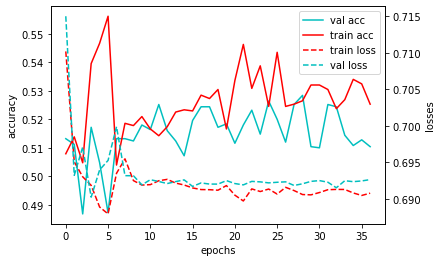

getting accuracies...



Train accuracy: 0.5363924050632911
Validation accuracy: 0.5197784810126582
Holdout accuracy: 0.5106803797468354

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7119 Acc: 0.5000
Validation Loss: 0.6917 Acc: 0.5168
took 0m 43s

Epoch 1/49
----------
Training Loss: 0.6925 Acc: 0.5174
Validation Loss: 0.7493 Acc: 0.5132
took 0m 24s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6920 Acc: 0.5229
Validation Loss: 0.6918 Acc: 0.5252
took 0m 32s

Epoch 3/49
----------
Training Loss: 0.6889 Acc: 0.5328
Validation Loss: 0.6845 Acc: 0.5228
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6746 Acc: 0.5882
Validation Loss: 0.6925 Acc: 0.5140
took 0m 24s

Epoch 5/49
----------
Training Loss: 0.6961 Acc: 0.5059
Validation Loss: 0.6915 Acc: 0.5152
took 0m 24s

Epoch 6/49
----------
Training Loss:

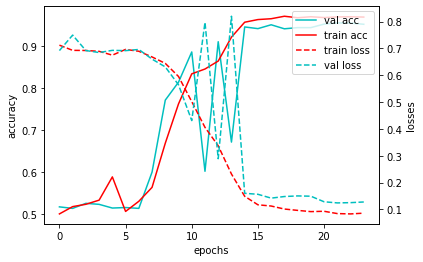

getting accuracies...



Train accuracy: 0.9715189873417721
Validation accuracy: 0.9513449367088608
Holdout accuracy: 0.9584651898734177

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7155 Acc: 0.4913
Validation Loss: 0.6949 Acc: 0.4848
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6941 Acc: 0.5115
Validation Loss: 0.6940 Acc: 0.4932
took 0m 33s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6942 Acc: 0.5000
Validation Loss: 0.6927 Acc: 0.5036
took 0m 33s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6925 Acc: 0.5182
Validation Loss: 0.6926 Acc: 0.5084
took 0m 34s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6912 Acc: 0.5154
Validation Loss: 0.6931 Acc: 0.5096
took 0m 33s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Lo

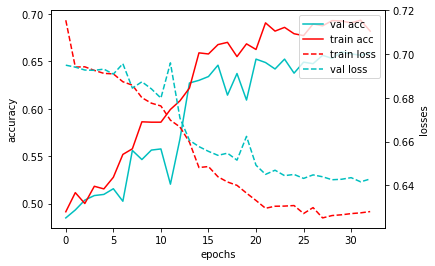

getting accuracies...



Train accuracy: 0.6839398734177216
Validation accuracy: 0.6483386075949367
Holdout accuracy: 0.6843354430379747

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7283 Acc: 0.4755
Validation Loss: 0.6952 Acc: 0.4884
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6933 Acc: 0.5202
Validation Loss: 0.6944 Acc: 0.4932
took 0m 32s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6938 Acc: 0.5083
Validation Loss: 0.6936 Acc: 0.5132
took 0m 32s

Epoch 3/49
----------
Training Loss: 0.6919 Acc: 0.5166
Validation Loss: 0.7013 Acc: 0.4868
took 0m 23s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6946 Acc: 0.5044
Validation Loss: 0.6928 Acc: 0.5144
took 0m 33s

Epoch 5/49
----------
Training Loss: 0.6933 Acc: 0.5202
Validation Loss: 0.6952 Acc: 0.

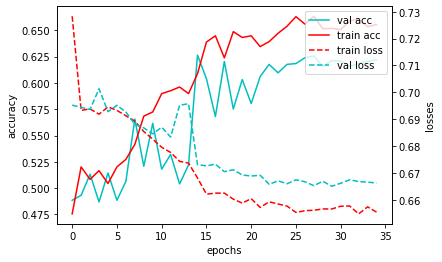

getting accuracies...



Train accuracy: 0.6424050632911392
Validation accuracy: 0.6174841772151899
Holdout accuracy: 0.6329113924050633

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7117 Acc: 0.5174
Validation Loss: 0.7010 Acc: 0.5132
took 0m 44s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6924 Acc: 0.5182
Validation Loss: 0.7032 Acc: 0.5136
took 0m 33s

Epoch 2/49
----------
Training Loss: 0.6919 Acc: 0.5320
Validation Loss: 0.7032 Acc: 0.5132
took 0m 23s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6874 Acc: 0.5392
Validation Loss: 0.6901 Acc: 0.5208
took 0m 33s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6801 Acc: 0.5716
Validation Loss: 0.6740 Acc: 0.5704
took 0m 34s

Epoch 5/49
----------
Training Loss: 0.6332 Acc: 0.6460
Validation Loss: 0.7117 Acc: 0.513

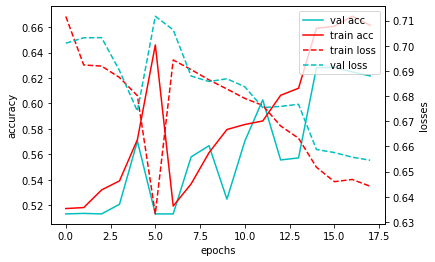

getting accuracies...



Train accuracy: 0.6712816455696202
Validation accuracy: 0.6428006329113924
Holdout accuracy: 0.6479430379746836

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.04_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7105 Acc: 0.5063
Validation Loss: 0.7093 Acc: 0.5132
took 0m 42s

Epoch 1/49
----------
Training Loss: 0.6950 Acc: 0.5138
Validation Loss: 0.6943 Acc: 0.5132
took 0m 24s

Epoch 2/49
----------
Training Loss: 0.6937 Acc: 0.5131
Validation Loss: 0.6961 Acc: 0.4868
took 0m 24s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6936 Acc: 0.5079
Validation Loss: 0.6931 Acc: 0.5148
took 0m 32s

Epoch 4/49
----------
Training Loss: 0.6917 Acc: 0.5182
Validation Loss: 0.6966 Acc: 0.4876
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6917 Acc: 0.5305
Validation Loss: 0.7053 Acc: 0.4868
took 0m 23s

Epoch 6/49
----------
Training Loss

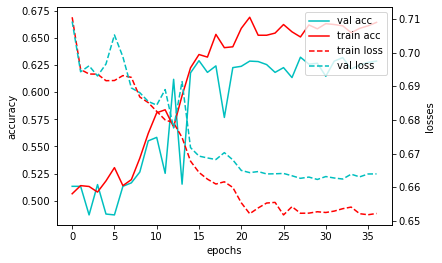

getting accuracies...



Train accuracy: 0.65625
Validation accuracy: 0.6325158227848101
Holdout accuracy: 0.65625

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.04_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7111 Acc: 0.5024
Validation Loss: 0.6922 Acc: 0.5172
took 0m 41s

Epoch 1/49
----------
Training Loss: 0.6926 Acc: 0.5170
Validation Loss: 0.7216 Acc: 0.5132
took 0m 24s

Epoch 2/49
----------
Training Loss: 0.6938 Acc: 0.5115
Validation Loss: 0.6937 Acc: 0.4984
took 0m 24s

Epoch 3/49
----------
Training Loss: 0.6929 Acc: 0.5087
Validation Loss: 0.6908 Acc: 0.5164
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6882 Acc: 0.5502
Validation Loss: 0.6914 Acc: 0.5160
took 0m 24s

Epoch 5/49
----------
Training Loss: 0.6860 Acc: 0.5372
Validation Loss: 0.6739 Acc: 0.6028
took 0m 24s

Epoch 6/49
----------
Training Loss: 0.6662 Acc: 0.6092
Validation Loss: 0.6243 Acc: 

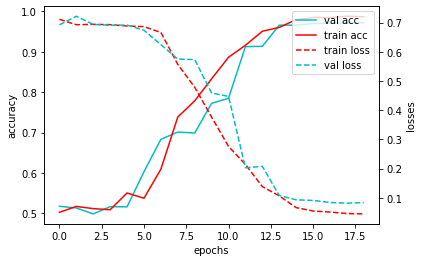

getting accuracies...



Train accuracy: 0.9893196202531646
Validation accuracy: 0.9671677215189873
Holdout accuracy: 0.9762658227848101

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.04_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7183 Acc: 0.4842
Validation Loss: 0.6943 Acc: 0.4868
took 0m 42s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6940 Acc: 0.5095
Validation Loss: 0.6935 Acc: 0.4952
took 0m 31s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6943 Acc: 0.4992
Validation Loss: 0.6932 Acc: 0.4968
took 0m 32s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6936 Acc: 0.5063
Validation Loss: 0.6927 Acc: 0.5252
took 0m 32s

Epoch 4/49
----------
Training Loss: 0.6927 Acc: 0.5146
Validation Loss: 0.6938 Acc: 0.5132
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6932 Acc: 0.5099
Validation Loss: 0.6926 Acc: 0.

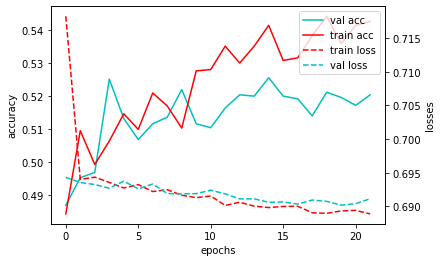

getting accuracies...



Train accuracy: 0.5419303797468354
Validation accuracy: 0.521756329113924
Holdout accuracy: 0.5181962025316456

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.04_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7355 Acc: 0.4885
Validation Loss: 0.6948 Acc: 0.4872
took 0m 41s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6933 Acc: 0.5119
Validation Loss: 0.6944 Acc: 0.4892
took 0m 32s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6937 Acc: 0.5036
Validation Loss: 0.6944 Acc: 0.5132
took 0m 32s

Epoch 3/49
----------
Training Loss: 0.6932 Acc: 0.5051
Validation Loss: 0.6958 Acc: 0.4868
took 0m 23s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6950 Acc: 0.4889
Validation Loss: 0.6926 Acc: 0.5168
took 0m 33s

Epoch 5/49
----------
Training Loss: 0.6935 Acc: 0.5142
Validation Loss: 0.6942 Acc: 0.4

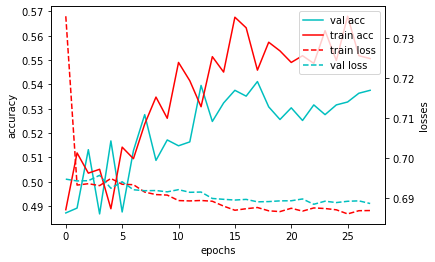

getting accuracies...



Train accuracy: 0.5625
Validation accuracy: 0.5478639240506329
Holdout accuracy: 0.5379746835443038

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.04_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7128 Acc: 0.5138
Validation Loss: 0.6979 Acc: 0.5132
took 0m 44s

Epoch 1/49
----------
Training Loss: 0.6939 Acc: 0.5016
Validation Loss: 0.7008 Acc: 0.5132
took 0m 24s

Epoch 2/49
----------
Training Loss: 0.6938 Acc: 0.5178
Validation Loss: 0.6985 Acc: 0.5132
took 0m 23s

Epoch 3/49
----------
Training Loss: 0.6924 Acc: 0.5202
Validation Loss: 0.6937 Acc: 0.5132
took 0m 23s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6919 Acc: 0.5186
Validation Loss: 0.6901 Acc: 0.5356
took 0m 33s

Epoch 5/49
----------
Training Loss: 0.6891 Acc: 0.5510
Validation Loss: 0.7036 Acc: 0.5132
took 0m 23s

Epoch 6/49
----------
Training Loss: 0.6935 Acc: 0.

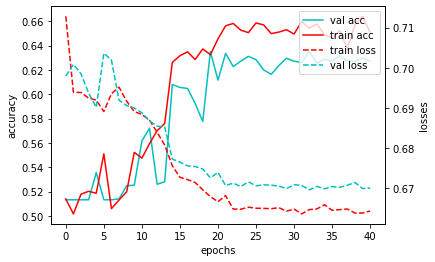

getting accuracies...



Train accuracy: 0.6566455696202531
Validation accuracy: 0.6289556962025317
Holdout accuracy: 0.649129746835443

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.005_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7151 Acc: 0.5111
Validation Loss: 0.7071 Acc: 0.5120
took 0m 48s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6914 Acc: 0.5289
Validation Loss: 0.6847 Acc: 0.5532
took 0m 40s

Epoch 2/49
----------
Training Loss: 0.6837 Acc: 0.5467
Validation Loss: 0.6893 Acc: 0.5324
took 0m 30s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6719 Acc: 0.5858
Validation Loss: 0.6806 Acc: 0.5580
took 0m 39s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6590 Acc: 0.6139
Validation Loss: 0.6621 Acc: 0.5972
took 0m 39s

Epoch 5/49
----------
Training Loss: 0.6280 Acc: 0.6404
Validation Loss: 0.7061 Acc: 0.5

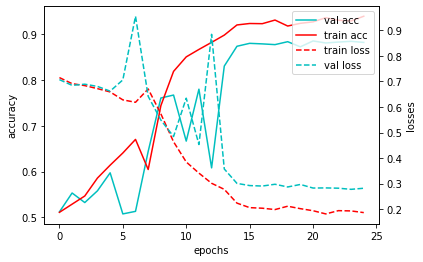

getting accuracies...



Train accuracy: 0.9236550632911392
Validation accuracy: 0.8777689873417721
Holdout accuracy: 0.8825158227848101

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.005_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7192 Acc: 0.5071
Validation Loss: 0.6895 Acc: 0.5384
took 0m 48s

Epoch 1/49
----------
Training Loss: 0.6879 Acc: 0.5419
Validation Loss: 0.7477 Acc: 0.5132
took 0m 28s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6817 Acc: 0.5506
Validation Loss: 0.6810 Acc: 0.5704
took 0m 39s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6732 Acc: 0.5835
Validation Loss: 0.6698 Acc: 0.5984
took 0m 39s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6546 Acc: 0.6214
Validation Loss: 0.6571 Acc: 0.6380
took 0m 37s

Epoch 5/49
----------
Training Loss: 0.6249 Acc: 0.6400
Validation Loss: 0.9428 Acc: 0.4

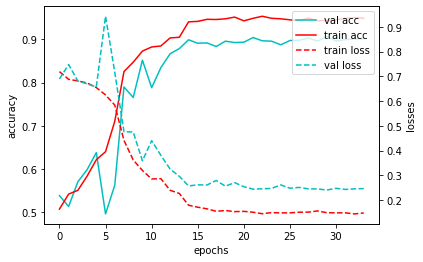

getting accuracies...



Train accuracy: 0.9394778481012658
Validation accuracy: 0.8951740506329114
Holdout accuracy: 0.9058544303797469

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.005_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7269 Acc: 0.4905
Validation Loss: 0.6920 Acc: 0.5228
took 0m 49s

Epoch 1/49
----------
Training Loss: 0.6942 Acc: 0.5075
Validation Loss: 0.6922 Acc: 0.5212
took 0m 31s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6940 Acc: 0.5024
Validation Loss: 0.6902 Acc: 0.5364
took 0m 37s

Epoch 3/49
----------
Training Loss: 0.6903 Acc: 0.5273
Validation Loss: 0.6911 Acc: 0.5328
took 0m 30s

Epoch 4/49
----------
Training Loss: 0.6889 Acc: 0.5372
Validation Loss: 0.6904 Acc: 0.5228
took 0m 29s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6878 Acc: 0.5487
Validation Loss: 0.6874 Acc: 0.5388
took 0m 37s

Epoch 6/49

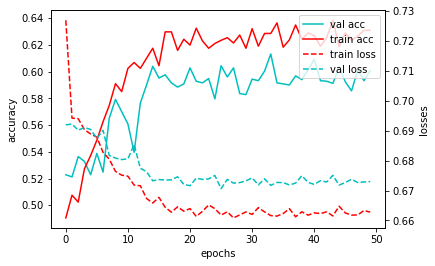

getting accuracies...



Train accuracy: 0.6384493670886076
Validation accuracy: 0.584256329113924
Holdout accuracy: 0.6174841772151899

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.005_98794515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7176 Acc: 0.5162
Validation Loss: 0.6914 Acc: 0.5232
took 0m 49s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6870 Acc: 0.5522
Validation Loss: 0.6858 Acc: 0.5372
took 0m 38s

Epoch 2/49
----------
Training Loss: 0.6824 Acc: 0.5597
Validation Loss: 0.6939 Acc: 0.5340
took 0m 29s

Epoch 3/49
----------
Training Loss: 0.6667 Acc: 0.5886
Validation Loss: 0.7105 Acc: 0.5268
took 0m 29s

Epoch 4/49
----------
Training Loss: 0.6589 Acc: 0.6072
Validation Loss: 0.8535 Acc: 0.4916
took 0m 31s

Epoch 5/49
----------
Training Loss: 0.6322 Acc: 0.6468
Validation Loss: 0.5840 Acc: 0.7244
took 0m 30s

Epoch 6/49
----------
	 	 	 	 *** best

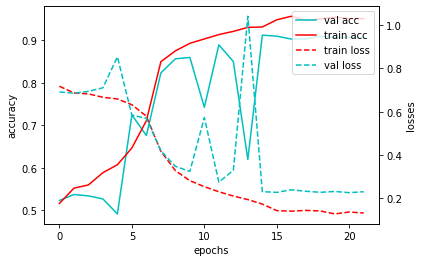

getting accuracies...



Train accuracy: 0.9485759493670886
Validation accuracy: 0.90625
Holdout accuracy: 0.9117879746835443

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.005_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7155 Acc: 0.4960
Validation Loss: 0.6989 Acc: 0.5136
took 0m 46s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6913 Acc: 0.5372
Validation Loss: 0.7000 Acc: 0.5184
took 0m 38s

Epoch 2/49
----------
Training Loss: 0.6855 Acc: 0.5506
Validation Loss: 0.7115 Acc: 0.5168
took 0m 28s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6747 Acc: 0.5799
Validation Loss: 0.6965 Acc: 0.5364
took 0m 38s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6654 Acc: 0.6068
Validation Loss: 0.6690 Acc: 0.5888
took 0m 38s

Epoch 5/49
----------
Training Loss: 0.6376 Acc: 0.6511
Validation Loss: 0.6950 Acc: 0.5260
took 0m 29

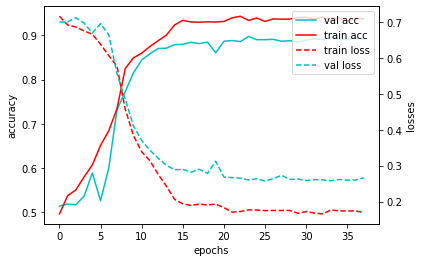

getting accuracies...



Train accuracy: 0.9359177215189873
Validation accuracy: 0.8924050632911392
Holdout accuracy: 0.8959651898734177

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.01_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7078 Acc: 0.5036
Validation Loss: 0.7167 Acc: 0.5140
took 0m 47s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6943 Acc: 0.5198
Validation Loss: 0.6863 Acc: 0.5400
took 0m 39s

Epoch 2/49
----------
Training Loss: 0.6863 Acc: 0.5400
Validation Loss: 0.6926 Acc: 0.5100
took 0m 31s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6753 Acc: 0.5740
Validation Loss: 0.6769 Acc: 0.5624
took 0m 41s

Epoch 4/49
----------
Training Loss: 0.6540 Acc: 0.6226
Validation Loss: 0.6803 Acc: 0.5508
took 0m 30s

Epoch 5/49
----------
Training Loss: 0.6574 Acc: 0.6060
Validation Loss: 0.7040 Acc: 0.4880
took 0m 30s

Epoch 6/49

In [ ]:
batch_size=32
acc_dif=0.06
stop_value=0.004
EPOCHS = 50
MRI = 1

LRs=[0.005,0.01,0.02,0.03,0.04]
blocks = ['3conv','4conv','all']

for block in blocks:
    for LR in LRs:
        for SEED in [116560000, 55168461, 18464876, 98794515, 58461]:
            training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                            LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

116560000
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_1conv_0.5_MRI_new_2500_0.038_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7126 Acc: 0.5222
Validation Loss: 0.9039 Acc: 0.5132
took 0m 35s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6867 Acc: 0.5562
Validation Loss: 0.6791 Acc: 0.5616
took 0m 26s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6669 Acc: 0.5961
Validation Loss: 0.6585 Acc: 0.5968
took 0m 25s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6440 Acc: 0.6313
Validation Loss: 0.6518 Acc: 0.6024
took 0m 26s

Epoch 4/49
----------
Training Loss: 0.5770 Acc: 0.6934
Validation Loss: 0.6865 Acc: 0.5872
took 0m 16s

Epoch 5/49
----------
Training Loss: 0.5330 Acc: 0.7286
Validation Loss: 0.8851 Acc: 0.4920
took 0m 17s

Epoch 6/49
----------
Training Loss: 0.4174 Acc: 0.8097
Validation Loss: 1.2140 Acc: 0.5548
took 0m 17s

Epo

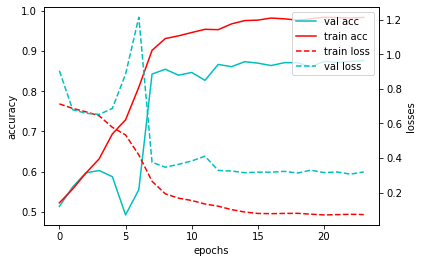

getting accuracies...



Train accuracy: 0.9236550632911392
Validation accuracy: 0.8453322784810127
Holdout accuracy: 0.8397943037974683

18464876
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_1conv_0.5_MRI_new_2500_0.038_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7169 Acc: 0.5146
Validation Loss: 0.6901 Acc: 0.5316
took 0m 35s

Epoch 1/49
----------
Training Loss: 0.6888 Acc: 0.5439
Validation Loss: 0.6924 Acc: 0.5064
took 0m 16s

Epoch 2/49
----------
Training Loss: 0.6792 Acc: 0.5799
Validation Loss: 0.6872 Acc: 0.5164
took 0m 16s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6620 Acc: 0.6028
Validation Loss: 0.6467 Acc: 0.6608
took 0m 27s

Epoch 4/49
----------
Training Loss: 0.6242 Acc: 0.6527
Validation Loss: 0.9734 Acc: 0.5132
took 0m 17s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.5494 Acc: 0.7199
Validation Loss: 0.5055 Acc: 0.7508
took 0m 26s


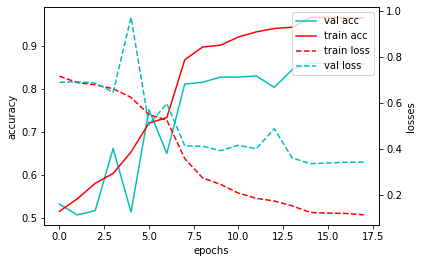

getting accuracies...



Train accuracy: 0.8963607594936709
Validation accuracy: 0.8152689873417721
Holdout accuracy: 0.817246835443038

32323548
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_1conv_0.5_MRI_new_2500_0.038_32323548 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7373 Acc: 0.5194
Validation Loss: 0.6891 Acc: 0.5392
took 0m 35s

Epoch 1/49
----------
Training Loss: 0.6919 Acc: 0.5186
Validation Loss: 0.6899 Acc: 0.5228
took 0m 17s

Epoch 2/49
----------
Training Loss: 0.6833 Acc: 0.5621
Validation Loss: 0.8035 Acc: 0.5132
took 0m 16s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6674 Acc: 0.5922
Validation Loss: 0.6573 Acc: 0.5908
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6306 Acc: 0.6472
Validation Loss: 0.7721 Acc: 0.5336
took 0m 17s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6106 Acc: 0.6717
Validation Loss: 0.5914 Acc: 0.7000
took 0m 24s



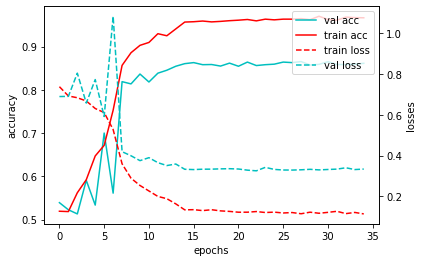

getting accuracies...



Train accuracy: 0.8833069620253164
Validation accuracy: 0.8136867088607594
Holdout accuracy: 0.8184335443037974

116560000
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_2conv_0.5_MRI_new_2500_0.03_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7139 Acc: 0.5142
Validation Loss: 0.8189 Acc: 0.5132
took 0m 37s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6915 Acc: 0.5289
Validation Loss: 0.6825 Acc: 0.5764
took 0m 27s

Epoch 2/49
----------
Training Loss: 0.6742 Acc: 0.5854
Validation Loss: 0.6687 Acc: 0.5360
took 0m 18s

Epoch 3/49
----------
Training Loss: 0.6277 Acc: 0.6475
Validation Loss: 1.0417 Acc: 0.5140
took 0m 19s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6180 Acc: 0.6574
Validation Loss: 0.6526 Acc: 0.6012
took 0m 27s

Epoch 5/49
----------
Training Loss: 0.4439 Acc: 0.7892
Validation Loss: 0.6488 Acc: 0.5908
took 0m 18s

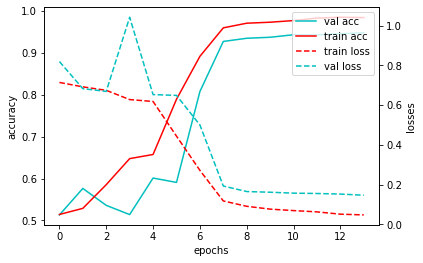

getting accuracies...



Train accuracy: 0.9881329113924051
Validation accuracy: 0.9493670886075949
Holdout accuracy: 0.9438291139240507

18464876
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_2conv_0.5_MRI_new_2500_0.03_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7154 Acc: 0.5186
Validation Loss: 0.6913 Acc: 0.5292
took 0m 35s

Epoch 1/49
----------
Training Loss: 0.6896 Acc: 0.5427
Validation Loss: 0.6878 Acc: 0.5164
took 0m 19s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6780 Acc: 0.5744
Validation Loss: 0.6597 Acc: 0.5464
took 0m 26s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6236 Acc: 0.6460
Validation Loss: 0.5608 Acc: 0.6896
took 0m 27s

Epoch 4/49
----------
Training Loss: 0.5019 Acc: 0.7579
Validation Loss: 3.8893 Acc: 0.5132
took 0m 19s

Epoch 5/49
----------
Training Loss: 0.7462 Acc: 0.5059
Validation Loss: 0.7034 Acc: 0.5136
took 0m 18s



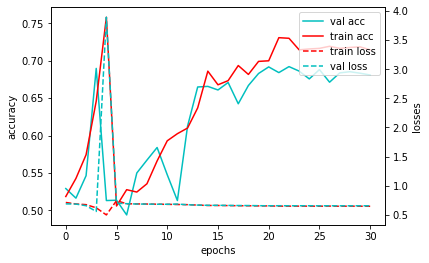

getting accuracies...



Train accuracy: 0.7072784810126582
Validation accuracy: 0.6890822784810127
Holdout accuracy: 0.6997626582278481

94515
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_2conv_0.5_MRI_new_2500_0.03_94515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7195 Acc: 0.4937
Validation Loss: 0.6912 Acc: 0.5248
took 0m 36s

Epoch 1/49
----------
Training Loss: 0.6908 Acc: 0.5257
Validation Loss: 0.7023 Acc: 0.5132
took 0m 18s

Epoch 2/49
----------
Training Loss: 0.6730 Acc: 0.5815
Validation Loss: 0.7322 Acc: 0.5132
took 0m 19s

Epoch 3/49
----------
Training Loss: 0.6737 Acc: 0.5752
Validation Loss: 0.6979 Acc: 0.4892
took 0m 19s

Epoch 4/49
----------
Training Loss: 0.6632 Acc: 0.6139
Validation Loss: 0.6628 Acc: 0.5384
took 0m 18s

Epoch 5/49
----------
Training Loss: 0.5866 Acc: 0.7061
Validation Loss: 0.8273 Acc: 0.4988
took 0m 19s

Epoch 6/49
----------
	 	 	 	 *** best model ***
Training Lo

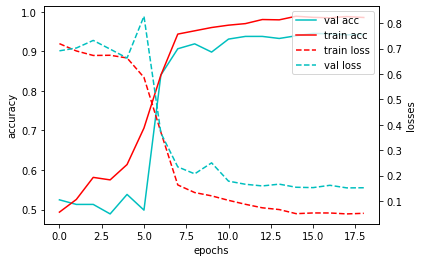

getting accuracies...



Train accuracy: 0.9869462025316456
Validation accuracy: 0.9442246835443038
Holdout accuracy: 0.944620253164557

116560000
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7114 Acc: 0.5063
Validation Loss: 0.7365 Acc: 0.5132
took 0m 37s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6946 Acc: 0.5067
Validation Loss: 0.6892 Acc: 0.5332
took 0m 30s

Epoch 2/49
----------
Training Loss: 0.6892 Acc: 0.5348
Validation Loss: 0.6935 Acc: 0.4952
took 0m 21s

Epoch 3/49
----------
Training Loss: 0.6800 Acc: 0.5621
Validation Loss: 0.6754 Acc: 0.5288
took 0m 21s

Epoch 4/49
----------
Training Loss: 0.6534 Acc: 0.6258
Validation Loss: 0.6633 Acc: 0.5444
took 0m 21s

Epoch 5/49
----------
Training Loss: 0.6777 Acc: 0.5882
Validation Loss: 0.6866 Acc: 0.4876
took 0m 22s

Epoch 6/49
----------
Trai

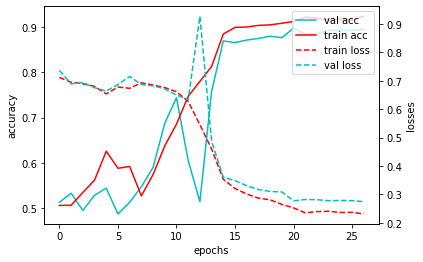

getting accuracies...



Train accuracy: 0.9169303797468354
Validation accuracy: 0.8884493670886076
Holdout accuracy: 0.901503164556962

18464876
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_18464876 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7130 Acc: 0.5095
Validation Loss: 0.6943 Acc: 0.4972
took 0m 38s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6930 Acc: 0.5134
Validation Loss: 0.6935 Acc: 0.5052
took 0m 29s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6916 Acc: 0.5166
Validation Loss: 0.6868 Acc: 0.5372
took 0m 29s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6803 Acc: 0.5732
Validation Loss: 0.6770 Acc: 0.6112
took 0m 28s

Epoch 4/49
----------
Training Loss: 0.6593 Acc: 0.6127
Validation Loss: 0.6633 Acc: 0.5224
took 0m 20s

Epoch 5/49
----------
Training Loss: 0.5876 Acc: 0.6883
Validation Loss: 0.8895

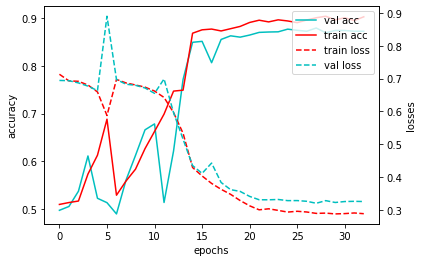

getting accuracies...



Train accuracy: 0.8924050632911392
Validation accuracy: 0.8809335443037974
Holdout accuracy: 0.8829113924050633

58461
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_3conv_0.5_MRI_new_2500_0.02_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7116 Acc: 0.5044
Validation Loss: 0.7133 Acc: 0.5132
took 0m 38s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6928 Acc: 0.5297
Validation Loss: 0.7075 Acc: 0.5144
took 0m 28s

Epoch 2/49
----------
Training Loss: 0.6902 Acc: 0.5431
Validation Loss: 0.7282 Acc: 0.5132
took 0m 20s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6761 Acc: 0.5854
Validation Loss: 0.6788 Acc: 0.5512
took 0m 28s

Epoch 4/49
----------
Training Loss: 0.6618 Acc: 0.6183
Validation Loss: 0.7276 Acc: 0.5064
took 0m 22s

Epoch 5/49
----------
Training Loss: 0.6875 Acc: 0.5542
Validation Loss: 0.6945 Acc: 0.5132
took 0m 21s

Epoch 

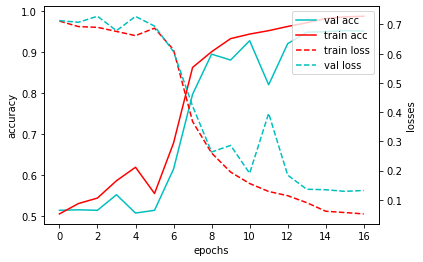

getting accuracies...



Train accuracy: 0.9865506329113924
Validation accuracy: 0.9553006329113924
Holdout accuracy: 0.9489715189873418

116560000
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7091 Acc: 0.5091
Validation Loss: 0.7407 Acc: 0.5132
took 0m 39s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6957 Acc: 0.5040
Validation Loss: 0.6902 Acc: 0.5316
took 0m 31s

Epoch 2/49
----------
Training Loss: 0.6916 Acc: 0.5218
Validation Loss: 0.6941 Acc: 0.4952
took 0m 23s

Epoch 3/49
----------
Training Loss: 0.6866 Acc: 0.5431
Validation Loss: 0.6868 Acc: 0.5168
took 0m 23s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6751 Acc: 0.5961
Validation Loss: 0.6652 Acc: 0.5976
took 0m 31s

Epoch 5/49
----------
Training Loss: 0.6456 Acc: 0.6392
Validation Loss: 0.7113 Acc: 0.4868
took 0m 23s

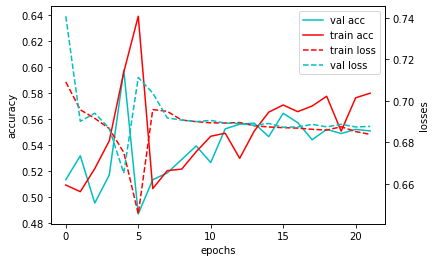

getting accuracies...



Train accuracy: 0.617879746835443
Validation accuracy: 0.6052215189873418
Holdout accuracy: 0.6190664556962026

58461
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_58461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7113 Acc: 0.5040
Validation Loss: 0.7089 Acc: 0.5140
took 0m 39s

Epoch 1/49
----------
Training Loss: 0.6932 Acc: 0.5142
Validation Loss: 0.7082 Acc: 0.5132
took 0m 23s

Epoch 2/49
----------
Training Loss: 0.6916 Acc: 0.5396
Validation Loss: 0.7155 Acc: 0.5132
took 0m 23s

Epoch 3/49
----------
	 	 	 	 *** best model ***
out
Training Loss: 0.6851 Acc: 0.5491
Validation Loss: 0.6972 Acc: 0.5168
took 0m 32s

Training complete in 1m 57s
Best val Acc: 0.516800



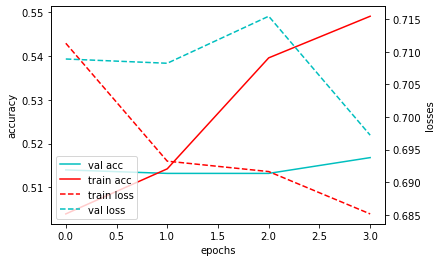

getting accuracies...



Train accuracy: 0.5189873417721519
Validation accuracy: 0.5174050632911392
Holdout accuracy: 0.49723101265822783

18464
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.02_18464 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7137 Acc: 0.4968
Validation Loss: 0.6934 Acc: 0.5076
took 0m 40s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6943 Acc: 0.5119
Validation Loss: 0.6912 Acc: 0.5340
took 0m 32s

Epoch 2/49
----------
Training Loss: 0.6925 Acc: 0.5071
Validation Loss: 0.6921 Acc: 0.5144
took 0m 23s

Epoch 3/49
----------
Training Loss: 0.6852 Acc: 0.5538
Validation Loss: 0.7107 Acc: 0.5132
took 0m 24s

Epoch 4/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6950 Acc: 0.5131
Validation Loss: 0.6895 Acc: 0.5452
took 0m 32s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6876 Acc: 0.5356
Validation Loss: 0.6776 Acc

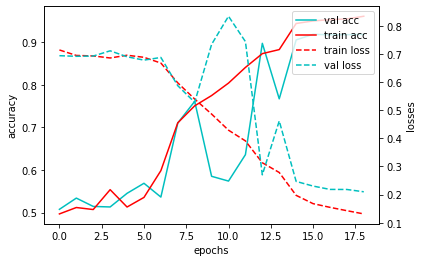

getting accuracies...



Train accuracy: 0.9533227848101266
Validation accuracy: 0.9177215189873418
Holdout accuracy: 0.9113924050632911

116560000
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.01_116560000 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7080 Acc: 0.5123
Validation Loss: 0.7186 Acc: 0.5124
took 0m 48s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6925 Acc: 0.5194
Validation Loss: 0.6867 Acc: 0.5392
took 0m 39s

Epoch 2/49
----------
Training Loss: 0.6849 Acc: 0.5427
Validation Loss: 0.7000 Acc: 0.4996
took 0m 28s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6744 Acc: 0.5775
Validation Loss: 0.6821 Acc: 0.5568
took 0m 37s

Epoch 4/49
----------
Training Loss: 0.6517 Acc: 0.6274
Validation Loss: 0.6770 Acc: 0.5568
took 0m 29s

Epoch 5/49
----------
Training Loss: 0.6807 Acc: 0.5625
Validation Loss: 0.7022 Acc: 0.4912
took 0m 30s



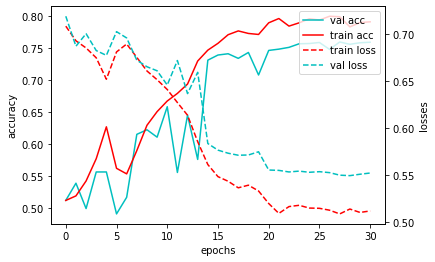

getting accuracies...



Train accuracy: 0.7899525316455697
Validation accuracy: 0.7531645569620253
Holdout accuracy: 0.7543512658227848

18464
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.01_18464 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7144 Acc: 0.4881
Validation Loss: 0.6929 Acc: 0.5068
took 0m 45s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6938 Acc: 0.5127
Validation Loss: 0.6887 Acc: 0.5488
took 0m 37s

Epoch 2/49
----------
Training Loss: 0.6896 Acc: 0.5210
Validation Loss: 0.6902 Acc: 0.5200
took 0m 29s

Epoch 3/49
----------
Training Loss: 0.6794 Acc: 0.5708
Validation Loss: 0.7086 Acc: 0.5124
took 0m 29s

Epoch 4/49
----------
Training Loss: 0.6872 Acc: 0.5427
Validation Loss: 0.6847 Acc: 0.5408
took 0m 29s

Epoch 5/49
----------
Training Loss: 0.6720 Acc: 0.5823
Validation Loss: 0.6410 Acc: 0.6572
took 0m 29s

Epoch 6/49
----------
Training Loss

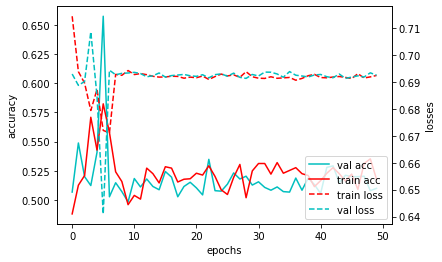

getting accuracies...



Train accuracy: 0.5431170886075949
Validation accuracy: 0.5537974683544303
Holdout accuracy: 0.5446993670886076

94515
creating dataloaders...
loading MRI model...
############## zz_new_finetuning_all_0.5_MRI_new_2500_0.01_94515 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7148 Acc: 0.5020
Validation Loss: 0.6888 Acc: 0.5448
took 0m 45s

Epoch 1/49
----------
Training Loss: 0.6911 Acc: 0.5305
Validation Loss: 0.6953 Acc: 0.5184
took 0m 29s

Epoch 2/49
----------
Training Loss: 0.6840 Acc: 0.5396
Validation Loss: 0.6940 Acc: 0.5232
took 0m 29s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6643 Acc: 0.5997
Validation Loss: 0.6693 Acc: 0.5840
took 0m 37s

Epoch 4/49
----------
Training Loss: 0.6425 Acc: 0.6203
Validation Loss: 0.6753 Acc: 0.5640
took 0m 29s

Epoch 5/49
----------
Training Loss: 0.6796 Acc: 0.5459
Validation Loss: 0.6941 Acc: 0.5052
took 0m 29s

Epoch 6/49
----------
Training Loss

KeyboardInterrupt: 

In [47]:
seeds=[116560000,18464876,32323548,98794515,58461,18464,23548,94515]

batch_size=32
acc_dif=0.06
stop_value=0.004
EPOCHS = 50
MRI = 1

args = {#'1conv':[0,0.038],
       # '2conv':[0.0018,0.03],
      # '3conv':[0.0008,0.02],
       '4conv':[0.0006,0.03],
       'all':[0.0006,0.01]}

for block in list(args.keys()):
    for SEED in seeds:
        print(SEED)
        MRI = 1
        LR = args[block][MRI]

        acc = training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                            LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_6497 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7143 Acc: 0.4901
Validation Loss: 0.6959 Acc: 0.5132
took 0m 40s

Epoch 1/49
----------
Training Loss: 0.6932 Acc: 0.5051
Validation Loss: 0.6920 Acc: 0.5132
took 0m 23s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6925 Acc: 0.5194
Validation Loss: 0.6922 Acc: 0.5320
took 0m 33s

Epoch 3/49
----------
Training Loss: 0.6920 Acc: 0.5245
Validation Loss: 0.6944 Acc: 0.5136
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6939 Acc: 0.5166
Validation Loss: 0.6906 Acc: 0.5260
took 0m 24s

Epoch 5/49
----------
Training Loss: 0.6890 Acc: 0.5316
Validation Loss: 0.7004 Acc: 0.5132
took 0m 23s

Epoch 6/49
----------
Training Loss: 0.6874 Acc: 0.5471
Validation Loss: 0.7115 Acc: 0.5132
took 0m 25s

Epoch 7/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6813 Ac

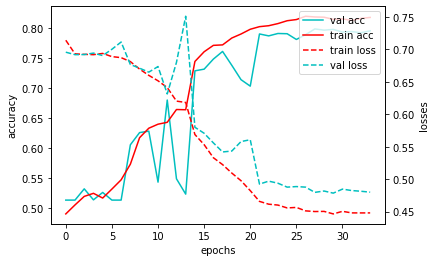

getting accuracies...



Train accuracy: 0.8160601265822784
Validation accuracy: 0.7935126582278481
Holdout accuracy: 0.805379746835443

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_123456 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7331 Acc: 0.4893
Validation Loss: 0.6933 Acc: 0.5020
took 0m 39s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6943 Acc: 0.5036
Validation Loss: 0.6928 Acc: 0.5164
took 0m 32s

Epoch 2/49
----------
Training Loss: 0.6937 Acc: 0.5150
Validation Loss: 0.6926 Acc: 0.5112
took 0m 23s

Epoch 3/49
----------
Training Loss: 0.6924 Acc: 0.5233
Validation Loss: 0.6977 Acc: 0.5132
took 0m 23s

Epoch 4/49
----------
Training Loss: 0.6923 Acc: 0.5237
Validation Loss: 0.6940 Acc: 0.4864
took 0m 25s

Epoch 5/49
----------
Training Loss: 0.6922 Acc: 0.5222
Validation Loss: 0.6948 Acc: 0.5132
took 0m 23s

Epoch 6/49
----------
	 	 	 	 *** best 

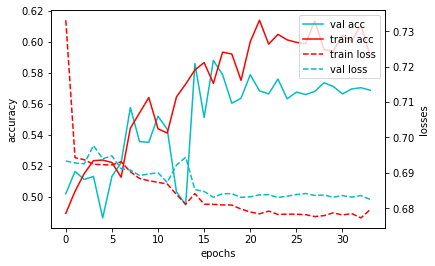

getting accuracies...



Train accuracy: 0.6119462025316456
Validation accuracy: 0.5858386075949367
Holdout accuracy: 0.5795094936708861

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_4687687 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7245 Acc: 0.4798
Validation Loss: 0.6948 Acc: 0.4868
took 0m 41s

Epoch 1/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6949 Acc: 0.5170
Validation Loss: 0.6929 Acc: 0.5116
took 0m 32s

Epoch 2/49
----------
Training Loss: 0.6942 Acc: 0.4881
Validation Loss: 0.6928 Acc: 0.5048
took 0m 23s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6925 Acc: 0.5103
Validation Loss: 0.6924 Acc: 0.5140
took 0m 34s

Epoch 4/49
----------
Training Loss: 0.6932 Acc: 0.5111
Validation Loss: 0.6926 Acc: 0.5108
took 0m 23s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6940 Acc: 0.5016
Validation Loss: 0.6921 Acc: 0.5

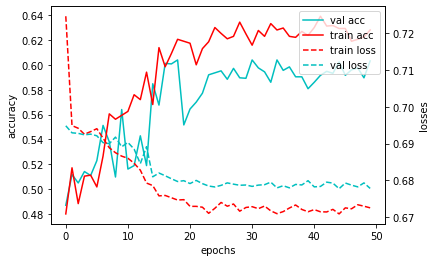

getting accuracies...



Train accuracy: 0.6317246835443038
Validation accuracy: 0.5977056962025317
Holdout accuracy: 0.6115506329113924

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_77777 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7180 Acc: 0.4771
Validation Loss: 0.6932 Acc: 0.5116
took 0m 42s

Epoch 1/49
----------
Training Loss: 0.6940 Acc: 0.5127
Validation Loss: 0.6952 Acc: 0.4876
took 0m 23s

Epoch 2/49
----------
Training Loss: 0.6935 Acc: 0.5047
Validation Loss: 0.6937 Acc: 0.5004
took 0m 23s

Epoch 3/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6920 Acc: 0.5178
Validation Loss: 0.6927 Acc: 0.5140
took 0m 33s

Epoch 4/49
----------
Training Loss: 0.6920 Acc: 0.5166
Validation Loss: 0.6937 Acc: 0.5048
took 0m 23s

Epoch 5/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6911 Acc: 0.5281
Validation Loss: 0.6881 Acc: 0.5496
took 0m 33s

Epoch 6/49
-

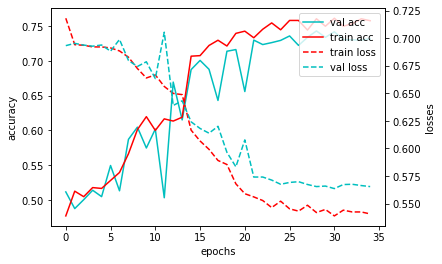

getting accuracies...



Train accuracy: 0.7527689873417721
Validation accuracy: 0.7286392405063291
Holdout accuracy: 0.7492088607594937



In [13]:
batch_size=32
acc_dif=0.06
stop_value=0.004
EPOCHS = 50
MRI = 1
LR = 0.03
block = '4conv'

seeds =[6497,123456,4687687,77777]


for SEED in seeds:
    training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7119 Acc: 0.5000
Validation Loss: 0.6917 Acc: 0.5168
took 0m 44s

Epoch 1/49
----------
Training Loss: 0.6925 Acc: 0.5174
Validation Loss: 0.7493 Acc: 0.5132
took 0m 25s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6920 Acc: 0.5229
Validation Loss: 0.6918 Acc: 0.5252
took 0m 34s

Epoch 3/49
----------
Training Loss: 0.6889 Acc: 0.5328
Validation Loss: 0.6845 Acc: 0.5228
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6746 Acc: 0.5882
Validation Loss: 0.6925 Acc: 0.5140
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6961 Acc: 0.5059
Validation Loss: 0.6915 Acc: 0.5152
took 0m 25s

Epoch 6/49
----------
Training Loss: 0.6892 Acc: 0.5301
Validation Loss: 0.6959 Acc: 0.5132
took 0m 25s

Epoch 7/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.668

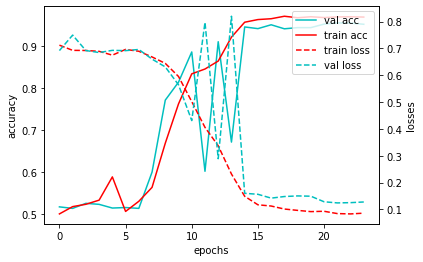

getting accuracies...



Train accuracy: 0.9715189873417721
Validation accuracy: 0.9513449367088608
Holdout accuracy: 0.9584651898734177



In [30]:
batch_size=32
acc_dif=0.06
stop_value=0.004
EPOCHS = 50
MRI = 1
LR = 0.03
block = '4conv'

seeds =[55168461]


for SEED in seeds:
    training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)